In [ ]:
# ===========================================================
## 1. 데이터 전처리 ##
#============================================================

In [1]:
import pandas as pd
import numpy as np
import io, os, re
from google.colab import files

pd.options.display.float_format = "{:.6g}".format

# =========================
# ✨금속 선택 옵션
# =========================
USE_METAL_FILTER = True  # True면 아래 목록에 있는 금속만 사용
METAL_NAME_FILTER = ["Cr", "Co", "Ni", "As", "Sb", "Pb"]  # ✨분석 대상 금속들만 적기

# =========================
# 설정값
# =========================
CONFIRM_DETECTED_COLUMNS = True

# 음수→NaN
NEGATIVE_TO_NAN = True

# IQR 셀-마스킹 적용 + 완화 기준(IQR_K=3.0)
APPLY_IQR_FILTER = True
IQR_K = 3.0  # Tukey 기본 1.5보다 완화 → 피크 이벤트 보존

# 대상 전부 NaN인 행만 삭제
DROP_EMPTY_TARGET = True

# =========================
# 유틸 함수들
# =========================
def _safe_basename(name: str) -> str:
    base, ext = os.path.splitext(name)
    base = re.sub(r"[^\w\-]+", "_", base).strip("_")
    return base, ext

def normalize_colname(c: str) -> str:
    """
    컬럼명 정규화:
    - 양쪽 공백 제거
    - 중간 공백 제거 (As (ng/m3) → As(ng/m3))
    - ㎥를 m3로 통일 (ng/㎥ → ng/m3)
    """
    c2 = str(c).strip()
    c2 = c2.replace(" ", "")
    c2 = c2.replace("㎥", "m3")
    return c2

# =========================
# 파일 업로드 + 여러 파일 병합
# =========================
print("엑셀 파일(.xlsx) 1개 이상 업로드하세요.")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("업로드된 파일이 없습니다. 다시 실행하여 업로드하세요.")

# .xlsx 파일 목록 추출
xlsx_names = [k for k in uploaded.keys() if k.lower().endswith(".xlsx")]
if not xlsx_names:
    raise RuntimeError("업로드된 파일 중 .xlsx 확장자가 없습니다.")

print(f"업로드된 .xlsx 파일 목록 ({len(xlsx_names)}개):")
for name in xlsx_names:
    print(" -", name)

# 여러 파일을 모두 읽어서 하나의 DataFrame으로 병합
df_list = []
for name in xlsx_names:
    print(f"Reading: {name}")
    bytes_io = io.BytesIO(uploaded[name])
    df_tmp = pd.read_excel(bytes_io)
    # 컬럼명 정규화 적용
    df_tmp.columns = [normalize_colname(c) for c in df_tmp.columns]
    df_list.append(df_tmp)

# 세로 병합 (row-wise)
df_raw = pd.concat(df_list, axis=0, ignore_index=True)

# =========================
# ✨불필요 컬럼 지정 삭제
#  - 예: "Number-of-Split", "Alarms" 등
# =========================
DROP_COL_EXACT = ["Number-of-split","Alarms", "ElemError", "BP_Mass(ugC)", "BP_Conc(ugC/m3)"] # ✨여기에 불필요 컬럼 추가

# 부분 문자열로 걸러서 지우고 싶을 때 사용
DROP_COL_CONTAINS = ["number-of-split","alarms", "elemerror", "bp_mass(ugC)", "bp_conc(ugC/m3)"]

cols_to_drop = []
for c in df_raw.columns:
    c_lower = c.lower()
    if (c in DROP_COL_EXACT) or any(key in c_lower for key in DROP_COL_CONTAINS):
        cols_to_drop.append(c)

print("Dropping extra non-needed columns:", cols_to_drop)
df_raw = df_raw.drop(columns=cols_to_drop, errors="ignore")


# 원본 파일명 기반 산출물 경로 자동 설정
# - 1개면 그 파일명 기준
# - 2개 이상이면 첫 파일명 + "_merged"
if len(xlsx_names) == 1:
    base0, _ = _safe_basename(xlsx_names[0])
    _base = base0
else:
    base0, _ = _safe_basename(xlsx_names[0])
    _base = f"{base0}_merged"

RAW_REPORT_PATH   = f"{_base}_QA_raw.xlsx"     # 전처리 전 QA
CLEAN_REPORT_PATH = f"{_base}_QA_clean.xlsx"   # 전처리 후 QA
CLEAN_DATA_PATH   = f"{_base}_clean.xlsx"      # 전처리 후 데이터(엑셀)
CLEAN_DATA_CSV    = f"{_base}_clean.csv"       # 전처리 후 데이터(CSV)

print("Output paths set:")
print(" RAW_REPORT_PATH   =", RAW_REPORT_PATH)
print(" CLEAN_REPORT_PATH =", CLEAN_REPORT_PATH)
print(" CLEAN_DATA_PATH   =", CLEAN_DATA_PATH)
print(" CLEAN_DATA_CSV    =", CLEAN_DATA_CSV)

# =========================
# 유틸: 컬럼 자동 검출
# =========================
def detect_columns(df: pd.DataFrame):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]

    # 시간 후보
    time_candidates = [
        c for c in df.columns
        if any(k in c.lower() for k in ["pump-begin", "date", "datetime", "time", "측정일시"])]
    time_col = time_candidates[0] if len(time_candidates) > 0 else None

    # PM2.5 후보
    pm25_candidates = [
        c for c in df.columns
        if ("pm2.5" in c.lower())
        or ("con(ug/m3)" in c.lower())
        or ("ug/m3" in c.lower() and "con" in c.lower())]
    pm25_col = pm25_candidates[0] if len(pm25_candidates) > 0 else None

    # 금속 단위 패턴
    metal_markers = ["(ng/m3)", "ng/m3", "(ng/㎥)", "ng/㎥"]
    metal_cols = [c for c in df.columns if any(m.lower() in c.lower() for m in metal_markers)]

    # 숫자형 후보(참고용)
    numeric_cols = []
    for c in df.columns:
        ser = pd.to_numeric(df[c], errors="coerce")
        if ser.notna().mean() >= 0.7:
            numeric_cols.append(c)

    return {
        "time_col": time_col,
        "pm25_col": pm25_col,
        "metal_cols": metal_cols,
        "numeric_cols": numeric_cols}

# =========================
# 로드 & 자동 검출 결과 출력
# =========================
detected = detect_columns(df_raw)
time_col   = detected["time_col"]
pm25_col   = detected["pm25_col"]
metal_cols = detected["metal_cols"]
numeric_cols = detected["numeric_cols"]

# 전체 금속 후보를 따로 보관
all_metal_candidates = metal_cols.copy()

# 지정 금속 필터 적용
if USE_METAL_FILTER and METAL_NAME_FILTER:
    metal_cols = [
        c for c in metal_cols
        if any(c.lower().startswith(sym.lower() + "(") for sym in METAL_NAME_FILTER)]

print("Detected time_col:", time_col)
print("Detected pm25_col:", pm25_col)
print("Detected metal_cols (first 10):", metal_cols[:10])
print("Detected numeric_cols (first 10):", numeric_cols[:10])

if not CONFIRM_DETECTED_COLUMNS:
    raise RuntimeError("자동 검출된 컬럼 확인 후, 맞으면 CONFIRM_DETECTED_COLUMNS=True로 설정하세요.")

# =========================
# QA 리포트 함수
# =========================
def summarize_series(s: pd.Series, name: str):
    s_num = pd.to_numeric(s, errors="coerce")
    return pd.Series({
        "col": name,
        "count_total": int(s_num.shape[0]),
        "count_valid": int(s_num.notna().sum()),
        "valid_pct": float(s_num.notna().mean()),
        "mean": float(s_num.mean(skipna=True)) if s_num.notna().any() else np.nan,
        "std": float(s_num.std(skipna=True)) if s_num.notna().any() else np.nan,
        "p5": float(s_num.quantile(0.05)) if s_num.notna().any() else np.nan,
        "p50": float(s_num.quantile(0.50)) if s_num.notna().any() else np.nan,
        "p95": float(s_num.quantile(0.95)) if s_num.notna().any() else np.nan,
        "min": float(s_num.min(skipna=True)) if s_num.notna().any() else np.nan,
        "max": float(s_num.max(skipna=True)) if s_num.notna().any() else np.nan})

def build_qc_table(df: pd.DataFrame, targets: list):
    rows = []
    for c in targets:
        if c in df.columns:
            rows.append(summarize_series(df[c], c))
    return pd.DataFrame(rows)

# =========================
# 대상 컬럼 정의
# =========================
target_cols = []
if pm25_col:
    target_cols.append(pm25_col)
if isinstance(metal_cols, (list, tuple)):
    target_cols += list(metal_cols)
target_cols = [c for c in target_cols if c in df_raw.columns]
assert len(target_cols) > 0, "PM2.5 또는 금속 대상 컬럼을 찾지 못했습니다."

# =========================
# 선택 금속 + PM2.5 외 모든 금속/컬럼 제거
# =========================
drop_metal_cols = [c for c in all_metal_candidates if c not in target_cols]

df_raw = df_raw.drop(columns=drop_metal_cols, errors="ignore")

print("Removed non-target metal columns:", drop_metal_cols)

# =========================
# QA 리포트(전처리 전)
# =========================
qc_raw = build_qc_table(df_raw, target_cols)
with pd.ExcelWriter(RAW_REPORT_PATH, engine="openpyxl") as w:
    qc_raw.to_excel(w, index=False, sheet_name="RAW_QA")

# =========================
# 전처리
# =========================
df_clean = df_raw.copy()

# 시간 정렬
if (time_col is not None) and (time_col in df_clean.columns):
    df_clean[time_col] = pd.to_datetime(df_clean[time_col], errors="coerce")
    df_clean = df_clean.sort_values(time_col).reset_index(drop=True)

# 대상만 숫자화(별도 프레임 보관)
num_targets = df_clean[target_cols].apply(pd.to_numeric, errors="coerce")

# --- 음수 → NaN ---
neg_before = int((num_targets < 0).sum().sum())
if NEGATIVE_TO_NAN:
    num_targets = num_targets.mask(num_targets < 0, np.nan)

# --- IQR 셀-마스킹 (행 삭제 금지) ---
cells_masked = 0
if APPLY_IQR_FILTER:
    Q1 = num_targets.quantile(0.25)
    Q3 = num_targets.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - IQR_K * IQR
    upper = Q3 + IQR_K * IQR

    low_mask  = num_targets.lt(lower, axis=1)
    high_mask = num_targets.gt(upper, axis=1)
    outlier_mask = low_mask | high_mask

    cells_masked = int(outlier_mask.sum().sum())
    num_targets = num_targets.mask(outlier_mask, np.nan)

# 대상 컬럼 적용
df_clean[target_cols] = num_targets

# --- 대상 전부 NaN 행 삭제 ---
rows_before_drop_empty = len(df_clean)
if DROP_EMPTY_TARGET:
    df_clean = df_clean.dropna(subset=target_cols, how="all").reset_index(drop=True)
rows_dropped_empty = rows_before_drop_empty - len(df_clean)

neg_after = int((df_clean[target_cols].apply(pd.to_numeric, errors="coerce") < 0).sum().sum())

# =========================
# 요약 출력
# =========================
print("=== Cleaning Summary ===")
print(f"Target columns (n={len(target_cols)}): {target_cols[:6]}{' ...' if len(target_cols)>6 else ''}")
print(f"Negatives (before -> after): {neg_before} -> {neg_after}")
print(f"IQR masked cells (k={IQR_K}): {cells_masked}")
print(f"Empty-target dropped rows: {rows_dropped_empty}")
print(f"Shape: raw {df_raw.shape} -> clean {df_clean.shape}")

# =========================
# QA 리포트(전처리 후)
# =========================
qc_clean = build_qc_table(df_clean, target_cols)
with pd.ExcelWriter(CLEAN_REPORT_PATH, engine="openpyxl") as w:
    qc_clean.to_excel(w, index=False, sheet_name="CLEAN_QA")

# =========================
# 저장 + 다운로드
# =========================
df_clean.to_excel(CLEAN_DATA_PATH, index=False)
df_clean.to_csv(CLEAN_DATA_CSV, index=False)

files.download(CLEAN_DATA_PATH)
files.download(CLEAN_REPORT_PATH)
files.download(RAW_REPORT_PATH)

# CSV 필요 시 활성화
# files.download(CLEAN_DATA_CSV)

엑셀 파일(.xlsx) 1개 이상 업로드하세요.


Saving 202501.xlsx to 202501.xlsx
Saving 202502.xlsx to 202502.xlsx
Saving 202503.xlsx to 202503.xlsx
Saving 202504.xlsx to 202504.xlsx
업로드된 .xlsx 파일 목록 (4개):
 - 202501.xlsx
 - 202502.xlsx
 - 202503.xlsx
 - 202504.xlsx
Reading: 202501.xlsx
Reading: 202502.xlsx
Reading: 202503.xlsx
Reading: 202504.xlsx
Dropping extra non-needed columns: ['Number-of-Split', 'Alarms', 'ElemError', 'BP_Mass(ugC)', 'BP_Conc(ugC/m3)']
Output paths set:
 RAW_REPORT_PATH   = 202501_merged_QA_raw.xlsx
 CLEAN_REPORT_PATH = 202501_merged_QA_clean.xlsx
 CLEAN_DATA_PATH   = 202501_merged_clean.xlsx
 CLEAN_DATA_CSV    = 202501_merged_clean.csv
Detected time_col: Pump-Begin
Detected pm25_col: Conc(ug/m3)
Detected metal_cols (first 10): ['Cr(ng/m3)', 'Co(ng/m3)', 'Ni(ng/m3)', 'As(ng/m3)', 'Sb(ng/m3)', 'Pb(ng/m3)']
Detected numeric_cols (first 10): ['Pump-Begin', 'Pump-End', 'MassResetTime', 'Analysis-Id', 'Mass(ug)', 'Conc(ug/m3)', 'Al(ng/m3)', 'Si(ng/m3)', 'S(ng/m3)', 'K(ng/m3)']
Removed non-target metal columns: ['A

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===========================================================
## 2. 산점도 그래프 생성 ##
# ===========================================================

Saving 202501_merged_clean.xlsx to 202501_merged_clean (1).xlsx


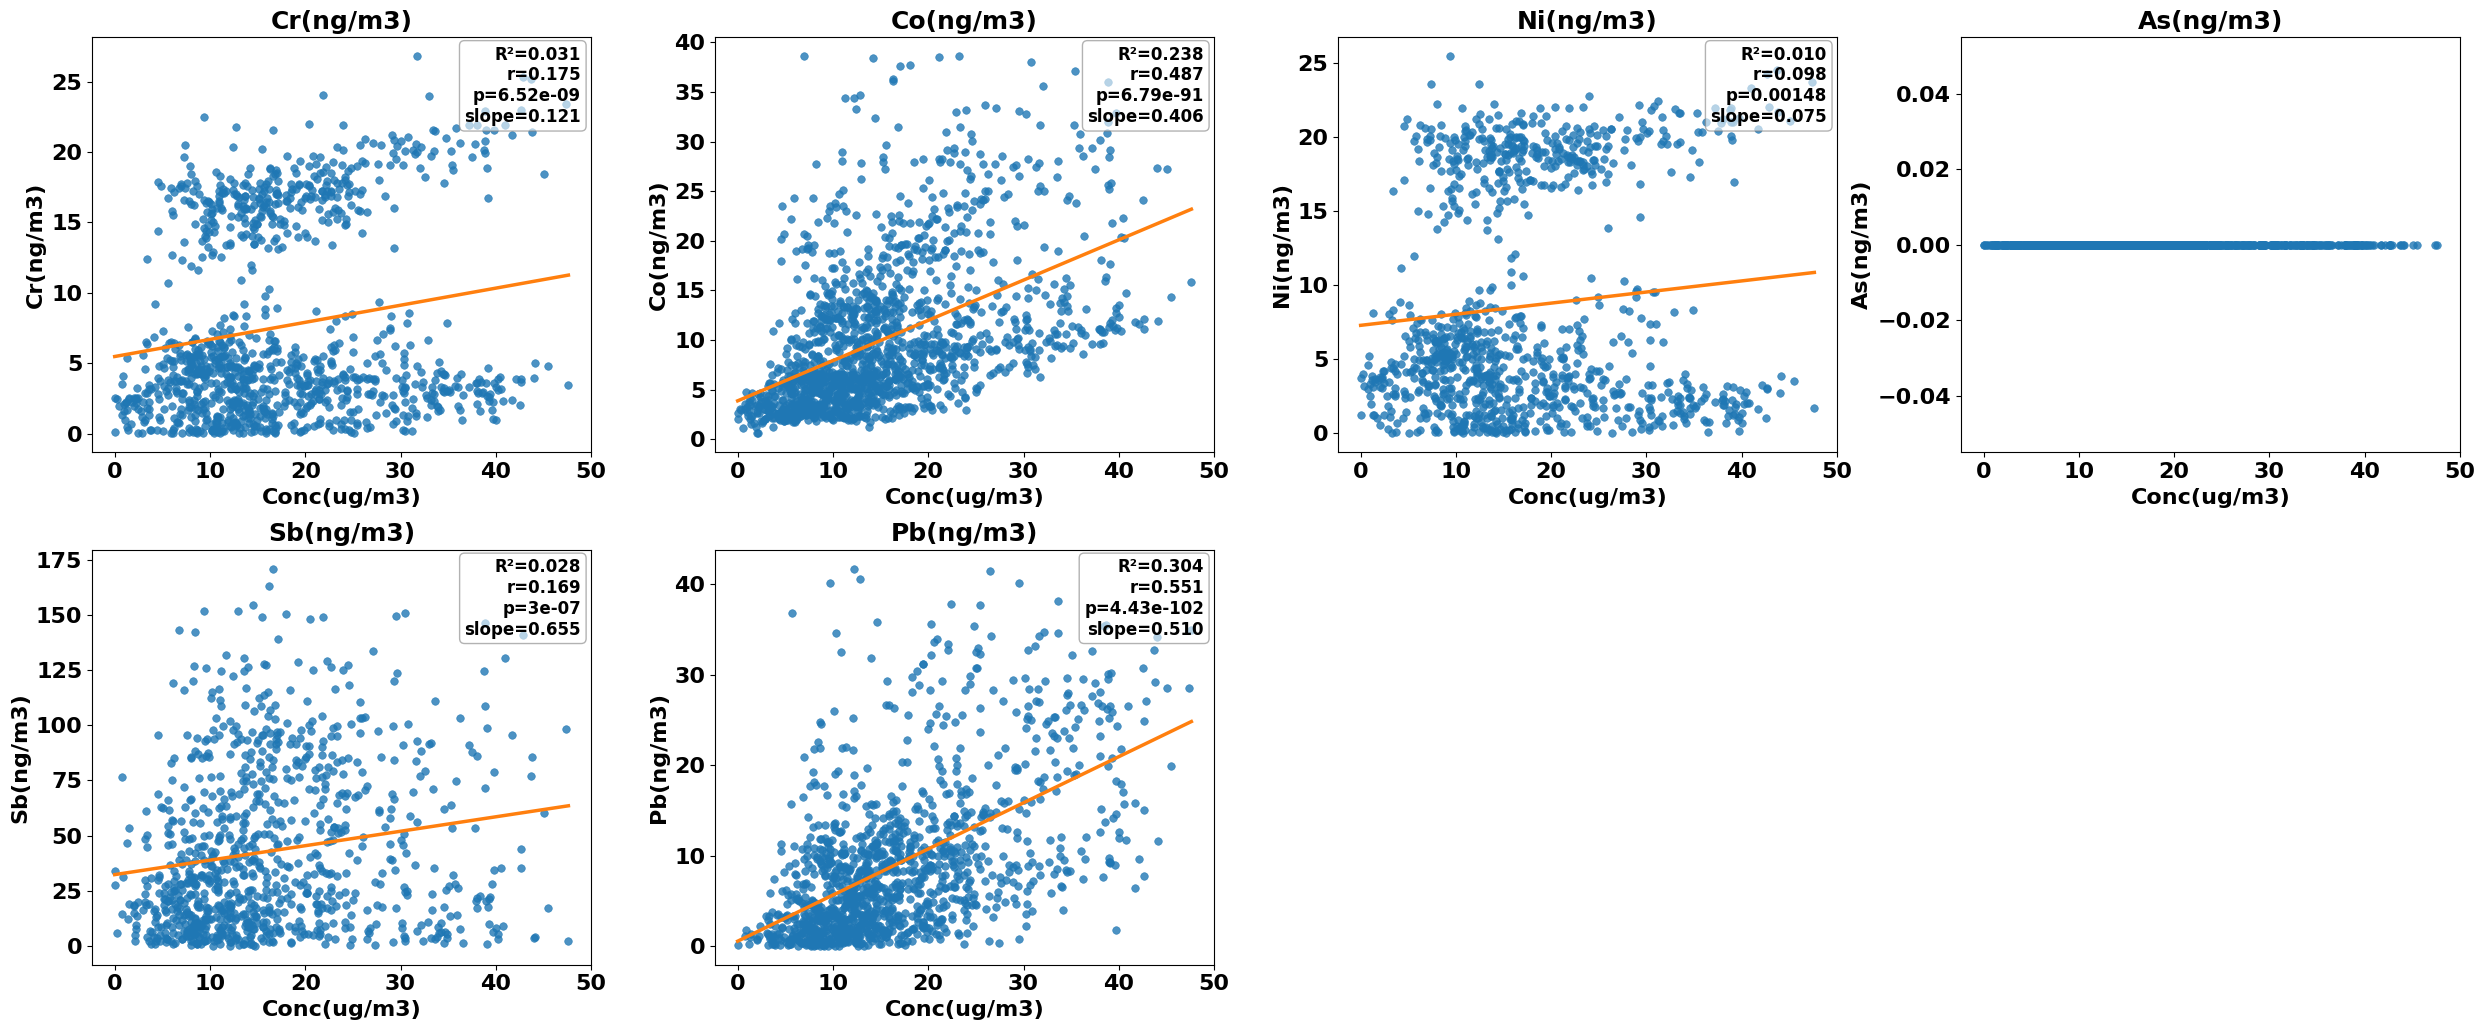

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from google.colab import files

# ===== 파일 업로드 =====
uploaded = files.upload()
fname = next(iter(uploaded.keys()))
df = pd.read_excel(fname)

# ===== 분석 대상 컬럼 추출 =====
unit_patterns = ['(ng/m3)', '(ug/m3)', '(µg/m³)', '(μg/m3)']
columns_to_analyze = [c for c in df.columns if any(p in str(c) for p in unit_patterns)]

# X축 후보
x_candidates = ['Conc(ug/m3)', 'PM2.5(ug/m3)', 'PM2.5 (ug/m3)', 'Con(ug/m3)']
xcol = next((c for c in x_candidates if c in df.columns), None)
if xcol is None:
    raise ValueError("X-axis column not found. Check the actual column name for PM2.5 mass.")

# Y축 후보
ycols = [c for c in columns_to_analyze if c != xcol]
if len(ycols) == 0:
    raise ValueError("No Y columns to plot. Check filter logic.")

# ===== 데이터 클린 함수 =====
def clean_series(s: pd.Series) -> pd.Series:
    s_num = pd.to_numeric(s, errors='coerce')
    return s_num.mask(s_num < 0)

# ===== 전역 스타일 =====
TITLE_FT = 18   # subplot 제목
LABEL_FT = 16   # 축 라벨
TICK_FT  = 16   # 축 숫자
ANN_FT   = 12   # 주석 폰트

plt.rcParams.update({
    "axes.titlesize": TITLE_FT,
    "axes.titleweight": "bold",
    "axes.labelsize": LABEL_FT,
    "axes.labelweight": "bold",
    "xtick.labelsize": TICK_FT,
    "ytick.labelsize": TICK_FT})

# ===== 산점도 + 회귀 함수 =====
def plot_scatter_with_regression(x: str, y: str, data: pd.DataFrame, ax):
    title = f"{y}"
    x_ser = clean_series(data[x])
    y_ser = clean_series(data[y])
    df_xy = pd.concat([x_ser.rename(x), y_ser.rename(y)], axis=1).dropna()

    # 예외 처리
    if len(df_xy) < 3 or df_xy[x].std() == 0 or df_xy[y].std() == 0:
        sns.scatterplot(data=df_xy, x=x, y=y, ax=ax, s=30, alpha=0.8, edgecolor=None)
        ax.set_xlabel(x, fontweight='bold'); ax.set_ylabel(y, fontweight='bold')
        ax.set_title(title, fontweight='bold')
        # 축 숫자 크기/볼드
        ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontsize(TICK_FT)
            label.set_fontweight('bold')
        return None

    # 산점도
    sns.scatterplot(data=df_xy, x=x, y=y, ax=ax, s=30, alpha=0.8, edgecolor=None)

    # 선형 회귀
    X_vals = df_xy[[x]].to_numpy()
    y_vals = df_xy[y].to_numpy()
    model = LinearRegression().fit(X_vals, y_vals)
    y_pred = model.predict(X_vals)
    r2 = float(model.score(X_vals, y_vals))
    slope = float(model.coef_[0])
    r, p = pearsonr(df_xy[x].to_numpy(), df_xy[y].to_numpy())

    # 회귀선
    order = np.argsort(X_vals.ravel())
    ax.plot(X_vals.ravel()[order], y_pred[order], linewidth=2.5, color='C1')

    # 라벨/제목
    ax.set_xlabel(x, fontsize=LABEL_FT, fontweight='bold')
    ax.set_ylabel(y, fontsize=LABEL_FT, fontweight='bold')
    ax.set_title(title, fontsize=TITLE_FT, fontweight='bold')

    # 축 숫자 크기/볼드
    ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(TICK_FT)
        label.set_fontweight('bold')

    # 라벨/제목
    ax.set_xlabel(x, fontsize=LABEL_FT, fontweight='bold')
    ax.set_ylabel(y, fontsize=LABEL_FT, fontweight='bold')
    ax.set_title(title, fontsize=TITLE_FT, fontweight='bold')

    # 축 숫자 크기/볼드
    ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(TICK_FT)
        label.set_fontweight('bold')

    # 주석 박스
    note = (f"R²={r2:.3f}\nr={r:.3f}\np={p:.3g}\n"
            f"slope={slope:.3f}")
    ax.text(0.98, 0.98, note, transform=ax.transAxes,
            ha='right', va='top',
            fontsize=ANN_FT, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='0.5',
                      boxstyle='round,pad=0.3', alpha=0.6))

# ===== 서브플롯 배치 =====
n = len(ycols)
ncols = 4
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6.2*ncols, 5.2*nrows))
axes = np.atleast_1d(axes).ravel()

# 여백 조정
fig.subplots_adjust(right=0.96, wspace=0.40, hspace=0.55)

# 플롯 생성
for i, metal in enumerate(ycols):
    plot_scatter_with_regression(xcol, metal, df, axes[i])

# 남는 축 숨김
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# ===========================================================
## 3. Pearson 상관관계 분석 & 표 생성 ##
# ===========================================================

Saving 202501_merged_clean.xlsx to 202501_merged_clean (3).xlsx
▶ 상관관계 분석표 (*: p<0.05, **: p<0.01)


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),1,,,,,,
Cr(ng/m3),0.175**,1,,,,,
Co(ng/m3),0.487**,0.738**,1,,,,
Ni(ng/m3),0.098**,0.988**,0.695**,1,,,
As(ng/m3),NaN,NaN,NaN,NaN,1,,
Sb(ng/m3),0.169**,0.791**,0.589**,0.800**,NaN,1,
Pb(ng/m3),0.551**,0.267**,0.480**,0.189**,NaN,0.242**,1


▶ 상관계수 행렬(r)


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),1,0.175,0.487,0.098,NaN,0.169,0.551
Cr(ng/m3),0.175,1,0.738,0.988,NaN,0.791,0.267
Co(ng/m3),0.487,0.738,1,0.695,NaN,0.589,0.48
Ni(ng/m3),0.098,0.988,0.695,1,NaN,0.8,0.189
As(ng/m3),NaN,NaN,NaN,NaN,1,NaN,NaN
Sb(ng/m3),0.169,0.791,0.589,0.8,NaN,1,0.242
Pb(ng/m3),0.551,0.267,0.48,0.189,NaN,0.242,1


▶ p값 행렬(p)


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),0,0,0,0.001,NaN,0,0
Cr(ng/m3),0,0,0,0,NaN,0,0
Co(ng/m3),0,0,0,0,NaN,0,0
Ni(ng/m3),0.001,0,0,0,NaN,0,0
As(ng/m3),NaN,NaN,NaN,NaN,0,NaN,NaN
Sb(ng/m3),0,0,0,0,NaN,0,0
Pb(ng/m3),0,0,0,0,NaN,0,0


▶ 쌍별 표본수(N)


,Conc(ug/m3),Cr(ng/m3),Co(ng/m3),Ni(ng/m3),As(ng/m3),Sb(ng/m3),Pb(ng/m3)
Conc(ug/m3),1672,1083,1510,1042,1499,911,1273
Cr(ng/m3),1083,1092,1073,1023,1070,796,999
Co(ng/m3),1510,1073,1520,1032,1489,899,1258
Ni(ng/m3),1042,1023,1032,1051,1036,781,951
As(ng/m3),1499,1070,1489,1036,1509,909,1253
Sb(ng/m3),911,796,899,781,909,918,821
Pb(ng/m3),1273,999,1258,951,1253,821,1277


▶ 유의(p<0.05) & 표본수≥30 상위 20쌍


,var1,var2,r,p,n,abs_r
4,Ni(ng/m3),Cr(ng/m3),0.988,0,1023,0.988
13,Sb(ng/m3),Ni(ng/m3),0.8,0,781,0.8
11,Sb(ng/m3),Cr(ng/m3),0.791,0,796,0.791
2,Co(ng/m3),Cr(ng/m3),0.738,0,1073,0.738
5,Ni(ng/m3),Co(ng/m3),0.695,0,1032,0.695
12,Sb(ng/m3),Co(ng/m3),0.589,0,899,0.589
15,Pb(ng/m3),Conc(ug/m3),0.551,0,1273,0.551
1,Co(ng/m3),Conc(ug/m3),0.487,0,1510,0.487
17,Pb(ng/m3),Co(ng/m3),0.48,0,1258,0.48
16,Pb(ng/m3),Cr(ng/m3),0.267,0,999,0.267


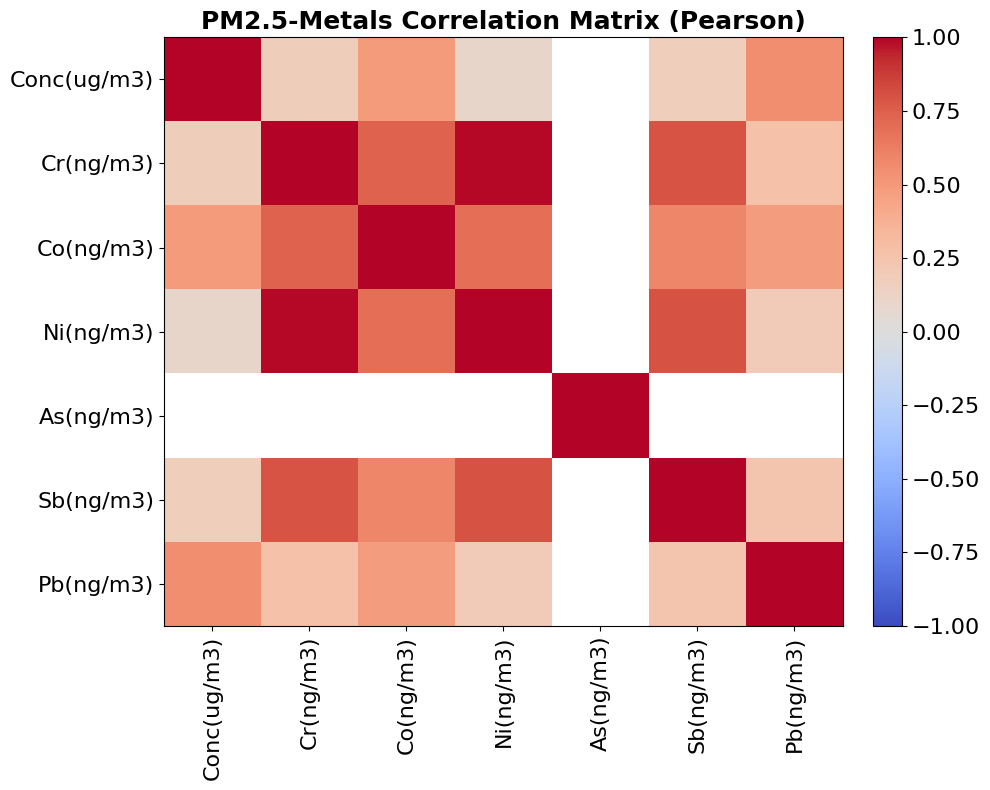

In [7]:
# =========================
# Pearson 상관관계 분석
# =========================
import re
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from google.colab import files
from IPython.display import display
import matplotlib.pyplot as plt

# --- 업로드 & 로드 ---
uploaded = files.upload()
fname = next(iter(uploaded.keys()))
df = pd.read_excel(fname)

# 1) 중복 열 제거(첫 번째만 유지)
if df.columns.duplicated().any():
    dup_names = df.columns[df.columns.duplicated()].unique().tolist()
    print(f"[warn] duplicated columns dropped (keeping first): {dup_names}")
    df = df.loc[:, ~df.columns.duplicated()].copy()

# 2) 대상 열 선택: (ng|ug|µg|μg)/(m3|m³|㎥) 단위 포함
unit_pat = re.compile(r"\((?:ng|ug|µg|μg)/(?:m3|m³|㎥)\)", flags=re.I)
target_cols = [c for c in df.columns if unit_pat.search(str(c))]
target_cols = pd.Index(target_cols).drop_duplicates().tolist()
if not target_cols:
    raise ValueError("단위 패턴에 맞는 열이 없습니다. 열명/단위를 확인하세요.")

# 3) 숫자화 (전처리 데이터 신뢰: 추가 마스킹/클리닝 금지)
df_num = df.loc[:, target_cols].apply(pd.to_numeric, errors="coerce")

# 4) 상관계수/유의확률/표본수 테이블
rmat = pd.DataFrame(index=target_cols, columns=target_cols, dtype=float)
pmat = pd.DataFrame(index=target_cols, columns=target_cols, dtype=float)
nmat = pd.DataFrame(index=target_cols, columns=target_cols, dtype=int)

for i, c1 in enumerate(target_cols):
    s1 = df_num[c1]
    for j, c2 in enumerate(target_cols):
        if j > i:
            continue  # 하삼각만 채움
        if i == j:
            rmat.iat[i, j] = 1.0
            pmat.iat[i, j] = 0.0
            nmat.iat[i, j] = s1.notna().sum()
            continue

        pair = pd.concat([s1, df_num[c2]], axis=1).dropna()
        n = len(pair)
        nmat.iat[i, j] = n

        if n < 3 or pair.iloc[:, 0].nunique() < 2 or pair.iloc[:, 1].nunique() < 2:
            rmat.iat[i, j] = np.nan
            pmat.iat[i, j] = np.nan
            continue

        r, p = pearsonr(pair.iloc[:, 0].values, pair.iloc[:, 1].values)
        rmat.iat[i, j] = r
        pmat.iat[i, j] = p

# 하삼각만 채운 행렬을 대칭 보정(표/히트맵에서 NaN처럼 보이는 문제 방지)
rmat = rmat.combine_first(rmat.T)
pmat = pmat.combine_first(pmat.T)
nmat = nmat.combine_first(nmat.T)

# 5) 포맷/라운드
DECIMALS = 3
rmat_round = rmat.round(DECIMALS)
pmat_round = pmat.round(DECIMALS)

def stars(p):
    if pd.isna(p): return ""
    return "**" if p < 0.01 else ("*" if p < 0.05 else "")

out_fmt = pd.DataFrame("", index=rmat.index, columns=rmat.columns, dtype=object)
for i in range(len(rmat.index)):
    for j in range(len(rmat.columns)):
        if j > i:                      # 상삼각은 비움
            out_fmt.iat[i, j] = ""
        elif i == j:                   # 대각선은 1
            out_fmt.iat[i, j] = "1"
        else:                          # 하삼각만 값/별표 표시
            rij = rmat.iat[i, j]
            pij = pmat.iat[i, j]
            out_fmt.iat[i, j] = "NaN" if pd.isna(rij) else f"{rij:.{DECIMALS}f}{stars(pij)}"

# (선택) p값 0.000을 "<0.001"로 표시하고 싶으면:
pmat_disp = pmat.map(lambda x: "<0.001" if pd.notna(x) and x < 0.001 else (f"{x:.3f}" if pd.notna(x) else "NaN"))

# 6) 결과 확인/표시
try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
except Exception as e:
    print("[info] data_table 사용 불가:", e)

print("▶ 상관관계 분석표 (*: p<0.05, **: p<0.01)")
display(out_fmt)

print("▶ 상관계수 행렬(r)")
display(rmat_round)

print("▶ p값 행렬(p)")
display(pmat_round)  # 또는 display(pmat_disp)

print("▶ 쌍별 표본수(N)")
display(nmat)

# 7) 납작화 요약 / 유의쌍
def melt_lower(rmat: pd.DataFrame, pmat: pd.DataFrame, nmat: pd.DataFrame) -> pd.DataFrame:
    cols = rmat.columns.tolist()
    recs = []
    for i in range(len(cols)):
        for j in range(i):
            r = rmat.iat[i, j]; p = pmat.iat[i, j]; n = nmat.iat[i, j]
            recs.append({
                "var1": cols[i], "var2": cols[j],
                "r": r, "p": p, "n": int(n) if pd.notna(n) else np.nan,
                "abs_r": abs(r) if pd.notna(r) else np.nan})
    return pd.DataFrame(recs)

pairs = melt_lower(rmat, pmat, nmat)

ALPHA = 0.05
MIN_N = 30
sig_pairs = pairs[(pairs["p"] < ALPHA) & (pairs["n"] >= MIN_N)].sort_values("abs_r", ascending=False)

pairs_round = pairs.copy()
for c in ["r", "p", "abs_r"]:
    if c in pairs_round.columns:
        pairs_round[c] = pairs_round[c].round(DECIMALS)

sig_pairs_round = sig_pairs.copy()
for c in ["r", "p", "abs_r"]:
    if c in sig_pairs_round.columns:
        sig_pairs_round[c] = sig_pairs_round[c].round(DECIMALS)

print(f"▶ 유의(p<{ALPHA}) & 표본수≥{MIN_N} 상위 20쌍")
display(sig_pairs_round.head(20))

# 8) 히트맵
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(rmat_round.values, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
ax.set_title("PM2.5-Metals Correlation Matrix (Pearson)", fontsize=18, fontweight='bold')
ax.set_xticks(range(len(target_cols))); ax.set_yticks(range(len(target_cols)))
ax.set_xticklabels(target_cols, rotation=90); ax.set_yticklabels(target_cols)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# 9) 저장
with pd.ExcelWriter("상관관계분석표.xlsx") as w:
    out_fmt.to_excel(w, sheet_name="pearson_r_fmt")
    rmat.to_excel(w, sheet_name="pearson_r_raw")
    pmat.to_excel(w, sheet_name="p_values")
    nmat.to_excel(w, sheet_name="pair_N")

with pd.ExcelWriter("상관분석_요약.xlsx") as w:
    pairs.to_excel(w, index=False, sheet_name="all_pairs")
    sig_pairs.to_excel(w, index=False, sheet_name=f"sig_pairs_p<{ALPHA}_N>={MIN_N}")

# 다운로드
#files.download("상관관계분석표.xlsx")
#files.download("상관분석_요약.xlsx")

In [ ]:
# ===========================================================
## 4. Single) 금속별 농도 예측 + Monte Carlo 기반 LECR 산정 ##
# ===========================================================

In [ ]:
# ============================================================
## 4. Single) 금속별 농도 예측 + Monte Carlo 기반 LECR 산정 ##
# ============================================================

# ============================================================
# 통합 파이프라인  (Best single-fit + MC + LECR)
# ============================================================

# ---------- Imports ----------
from google.colab import files
import os, re, json, math, warnings, glob
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import (
    gumbel_r, gumbel_l, lognorm, weibull_min, logistic,
    norm, gamma, beta, triang, expon, pareto, uniform, chi2)
from scipy.stats import t as student_t
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.worksheet.table import Table, TableStyleInfo
warnings.filterwarnings("ignore")
from matplotlib.ticker import FuncFormatter

# === 전역 폰트 기본값(크기/굵기) 지정 ===
plt.rcParams.update({
    "font.size": 11,             # 기본 폰트
    "axes.titlesize": 14,        # 축 제목(각 패널) 크기
    "axes.titleweight": "bold",  # 축 제목 굵기
    "axes.labelsize": 12,        # x/y 라벨 크기
    "axes.labelweight": "bold",  # x/y 라벨 굵기
    "legend.fontsize": 11        # 범례 크기
})

# ---------- 사용자 설정 ----------
np.random.seed(20250912)
N_SIM       = 10_000
BOOTSTRAP_B = 200
SAVE_DIR    = "outputs"
EXCLUDE_METALS = ["Cr", "Cd"] # 제외금속  ← 문자열로 표기

# ---------- 고정 상수 ----------
IUR = {"Cr(VI)":1.20e-02,"Co":9.00e-03,"Ni":2.40e-04,"As":4.30e-03,"Cd":1.80e-03,"Sb":2.29e-06,"Pb":1.20e-05}
ORDER = ['Cr','Cr(VI)','Co','Ni','As','Cd','Sb','Pb']

# 제외 설정
EXCLUDE_SET  = set(m.strip() for m in EXCLUDE_METALS)
ACTIVE_ORDER = [m for m in ORDER if m not in EXCLUDE_SET]

ENG_NAME = {
    '로그 정규':'Lognormal', '와이블':'Weibull', '감마':'Gamma', '지수':'Exponential',
    '최대 극값':'Gumbel Max', '최소 극값':'Gumbel Min', '정규':'Normal', '로지스틱':'Logistic',
    "스튜던트의 t":"Student's t", '베타':'Beta', 'BetaPERT':'BetaPERT',
    '삼각형':'Triangular', '균일':'Uniform', '파레토':'Pareto'}

# ===== 분포별 라인 색상 팔레트 =====
DIST_COLOR = {
    'Lognormal': 'tab:orange',
    'Weibull': 'tab:green',
    'Gamma': 'tab:purple',
    'Exponential': 'tab:red',
    'Gumbel Max': 'tab:olive',
    'Gumbel Min': 'tab:cyan',
    'Normal': 'tab:blue',
    'Logistic': 'tab:pink',
    "Student's t": 'tab:brown',
    'Beta': 'tab:gray',
    'BetaPERT': 'tab:purple',
    'Triangular': 'tab:teal',
    'Uniform': 'tab:cyan',
    'Pareto': 'tab:red'}

# --- 패턴 ---
PAT = {
    "Cr(VI)": r"(?:\bCr\s*VI\b|\bCr[-\s]*VI\b|\bCr\s*6\+\b|Cr[-\s]*6\+|Hexa(?:valent)?\s*Chrom(?:ium)?|6가\s*크롬|육가\s*크롬|육가크롬)",
    "Cr"    : r"(?:\bCr\b(?!\s*(?:VI|6\+))|Chromium|크롬)",
    "Co"    : r"(?:\bCo\b|\bC\s*o\b|Cobalt|코발트)",
    "Ni"    : r"(?:\bNi\b|\bN\s*i\b|Nickel|니켈)",
    "As"    : r"(?:\bA\s*s\b|\bAs\b(?=[\s\(\[]|$)|Arsenic|비소)",
    "Cd"    : r"(?:\bCd\b|\bC\s*d\b|Cadmium|카드뮴)",
    "Sb"    : r"(?:\bS[bB]\b|\bS\s*B\b|Stibium|Antimon(?:y)?|안티몬)",
    "Pb"    : r"(?:\bPb\b|\bP\s*b\b|Lead|납)"}

# Excel 스타일
HEADER_BLUE = '2F5597'; BEST_FILL='FFF2CC'; THIN_GRAY='999999'; TABLE_STYLE="TableStyleMedium9"

# 노출 파라미터
EF_days_per_year = 350; EF = EF_days_per_year/365.0
LT_years = 78.6
ACT_POINT = {"0-<1":24,"1-<2":84,"2-<3":120,"3-<6":108,"6-<11":132,"11-<16":102,"16-<18":102}
ACT_LN_P5_P95 = {"18-<25":(14.455,250.0),"25-<35":(6.516,220.0),"35-<45":(5.789,195.0),
                 "45-<55":(6.401,260.0),"55-<65":(8.083,350.0),"65-<78.6":(6.094,390.0)}
ED_years = {"0-<1":1,"1-<2":1,"2-<3":1,"3-<6":3,"6-<11":5,"11-<16":5,"16-<18":2,
            "18-<25":7,"25-<35":10,"35-<45":10,"45-<55":10,"55-<65":10,"65-<78.6":13.6}
AGE_ORDER=["0-<1","1-<2","2-<3","3-<6","6-<11","11-<16","16-<18","18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]
INFANT = ["0-<1","1-<2"]; CHILD=["2-<3","3-<6","6-<11","11-<16","16-<18"]; ADULT=["18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]

# RNG helpers
_master_rs = np.random.RandomState(20250912)
def child_rs(): return np.random.RandomState(_master_rs.randint(0, 2**31-1))
_mdl_rs = child_rs()  # ND/MDL 치환용 난수원

# ============================================================
# 유틸
# ============================================================
def freedman_diaconis_bins(x, min_bins=30, max_bins=70):
    x = np.asarray(x, float); x = x[np.isfinite(x)]
    n = x.size
    if n < 2: return max(2, min_bins)
    q75, q25 = np.percentile(x, [75, 25]); iqr = q75 - q25
    if iqr <= 0: return max(min_bins, min(max_bins, int(np.sqrt(n))))
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0: return max(min_bins, min(max_bins, int(np.sqrt(n))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(2, max(min_bins, min(max_bins, bins)))

# --- ND/<MDL> 수치화 ---
MDL_POLICY = "uniform"  # "half" | "nan" | "uniform"
def coerce_numeric_with_mdl(s):
    s = pd.Series(s).astype(str).str.strip().str.replace(',', '', regex=False)

    # <a or ≤a → half*a / NaN / Uniform(0,a)
    m = s.str.match(r'^[<≤]\s*([0-9]*\.?[0-9]+)$')
    if m.any():
        vals = s[m].str.replace('≤','<',regex=False).str.replace('<','',regex=False).astype(float).values
        if MDL_POLICY == 'half':
            s.loc[m] = (vals/2.0)
        elif MDL_POLICY == 'nan':
            s.loc[m] = np.nan
        elif MDL_POLICY == 'uniform':
            # Uniform(0, a) 샘플
            u = _mdl_rs.uniform(0.0, 1.0, size=len(vals))
            s.loc[m] = vals * u
        else:
            s.loc[m] = (vals/2.0)

    # common tokens → NaN
    s = s.replace({'ND':np.nan,'N.D.':np.nan,'MDL':np.nan,'BDL':np.nan,'-':np.nan,'--':np.nan,'':np.nan}, regex=False)
    return pd.to_numeric(s, errors='coerce')

def hist_mode_estimate(x):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    if x.size<2: return float(np.nanmedian(x)) if x.size else np.nan
    iqr=np.subtract(*np.percentile(x,[75,25]))
    bins=max(10,int(np.sqrt(x.size))) if iqr<=0 else max(10,int(np.ceil((x.max()-x.min())/(2*iqr*x.size**(-1/3)))) )
    cnt,edges=np.histogram(x,bins=bins); i=int(cnt.argmax())
    return float((edges[i]+edges[i+1])/2)

def apply_pretty_xticks(ax, min_ticks=4, max_ticks=7):
    x_lo, x_hi = ax.get_xlim()
    if not np.isfinite(x_lo) or not np.isfinite(x_hi):
        return
    if x_hi <= x_lo:
        return

    x_range = x_hi - x_lo

    # 1) 가능한 step 후보 생성 (1,2,2.5,5 × 10^k)
    base = np.array([1.0, 2.0, 2.5, 5.0])
    steps = []
    for k in range(-6, 2):   # 10^-6 ~ 10^1 정도까지면 충분
        steps.extend(base * (10.0 ** k))
    steps = np.array(sorted(steps))

    # 2) 현재 범위에 맞는 step 선택
    best_step = None
    best_diff = None

    for step in steps:
        if step <= 0:
            continue
        start = np.ceil(x_lo / step) * step
        end   = np.floor(x_hi / step) * step
        if end < start:
            continue

        n_ticks = int(np.floor((end - start) / step)) + 1

        # min~max 사이면 바로 채택
        if min_ticks <= n_ticks <= max_ticks:
            best_step = step
            break

        # 아니면, 차이가 가장 적은 후보를 기억
        if n_ticks < min_ticks:
            diff = min_ticks - n_ticks
        else:
            diff = n_ticks - max_ticks

        if best_diff is None or diff < best_diff:
            best_diff = diff
            best_step = step

    if best_step is None:
        return

    step = best_step

    # 3) 실제 tick 계산
    start = np.ceil(x_lo / step) * step
    end   = np.floor(x_hi / step) * step
    if end < start:
        return

    ticks = np.arange(start, end + step*0.5, step)
    ticks[np.isclose(ticks, 0.0, atol=step*0.01)] = 0.0  # -0 보정

    ax.set_xticks(ticks)

    # 4) 라벨 포맷 (과학표기 제거)
    def _smart_fmt(v, pos):
        s = f"{v:.6f}".rstrip('0').rstrip('.')
        return "0" if s in ("", "-0") else s

    ax.xaxis.set_major_formatter(FuncFormatter(_smart_fmt))
    ax.grid(True, alpha=0.25)

# ============================================================
# 1) 파일 업로드 & 시트 자동 선택
# ============================================================
print("엑셀 파일 업로드(.xlsx/.xls)")
up = files.upload()
INPUT = next((k for k in up if k.lower().endswith(('.xlsx','.xls'))), None)
if INPUT is None:
    cand = sorted(glob.glob("*.xlsx"))
    if not cand: raise FileNotFoundError("엑셀 파일을 찾지 못했습니다.")
    INPUT = cand[-1]

xls = pd.ExcelFile(INPUT)
sheet_scores=[]
for sh in xls.sheet_names:
    try:
        df_head = pd.read_excel(INPUT, sheet_name=sh, nrows=3)
    except Exception:
        df_head = pd.DataFrame()
    score=0
    for c in df_head.columns:
        s=str(c)
        score += sum(bool(re.search(p, s, flags=re.I)) for p in PAT.values())
    sheet_scores.append((sh,score))
sheet_scores.sort(key=lambda x:x[1], reverse=True)
SHEET = sheet_scores[0][0]
raw = pd.read_excel(INPUT, sheet_name=SHEET)
print(f"선택된 시트: {SHEET}")

# ============================================================
# 2) 단위 통일 & 열 자동 매칭 (+ Cr(VI) 파생)
# ============================================================
def find_col(df, regex):
    for c in df.columns:
        if re.search(regex, str(c), flags=re.I): return c
    return None

def to_ug(series, name):
    header = str(name)
    s = coerce_numeric_with_mdl(series).replace([np.inf, -np.inf], np.nan)
    has_ug = bool(re.search(r'(?i)[µμu]\s*g\s*/?\s*m\^?3', header))
    has_ng = bool(re.search(r'(?i)n\s*g\s*/?\s*m\^?3', header))
    if has_ug: return (s, 'as_is_ug')
    if has_ng: return (s/1000.0, 'converted_from_ng')
    return (s, 'as_is_ug')

series_map, log_rows = {}, []
for m in ORDER:
    if m in EXCLUDE_SET:
        log_rows.append((m, None, 'excluded_by_user', 0, np.nan))
        continue
    c = find_col(raw, PAT.get(m, r"^"))
    if c is None:
        log_rows.append((m, None, 'missing', 0, np.nan)); continue
    v, how = to_ug(raw[c], c); series_map[m]=v
    n_nonna = int(pd.to_numeric(v, errors='coerce').notna().sum())
    log_rows.append((m, c, how, n_nonna, float(np.nanmean(v))))
log = pd.DataFrame(log_rows, columns=['Metal','Matched_Column','Unit_Status','N_nonNa','Mean(ug/m3)'])

# 디버그 요약
print("\n[DEBUG] 유효 표본수 요약:", {m:int(pd.to_numeric(series_map[m],errors='coerce').notna().sum()) for m in series_map})

# Cr은 제외하더라도 파생만은 허용 (원자료에 Cr 열이 있을 때)
if ('Cr(VI)' not in series_map):
    c_col = find_col(raw, PAT.get("Cr", r"^"))
    if c_col is not None:
        cr_series, _ = to_ug(raw[c_col], c_col)
        series_map['Cr(VI)'] = cr_series/7.0
        log.loc[len(log)] = ['Cr(VI)','(derived from Cr/7 even if Cr excluded)','derived',
                             int(pd.to_numeric(series_map['Cr(VI)'],errors='coerce').notna().sum()),
                             float(np.nanmean(series_map['Cr(VI)']))]

# ============================================================
# 3) 14개 분포 래퍼 + 적합도 함수
# ============================================================
class D:
    def __init__(self,name): self.name=name; self.p={}; self.np=None; self.valid=False
    def ok(self,p,np_): self.p=p; self.np=np_; self.valid=True; return self
    def cdf(self,z): raise NotImplementedError
    def ppf(self,q): raise NotImplementedError
    def rvs(self,n,rs=None): raise NotImplementedError

class LogNormal(D):
    def __init__(self): super().__init__('로그 정규')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: s,loc,sc=lognorm.fit(x)
        except: return self
        if s>0 and sc>0 and np.isfinite(loc): return self.ok({'s':s,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return lognorm.cdf(z, s=self.p['s'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return lognorm.ppf(q, s=self.p['s'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return lognorm.rvs(self.p['s'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class Weibull(D):
    def __init__(self): super().__init__('와이블')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: c,loc,sc=weibull_min.fit(x)
        except: return self
        if c>0 and sc>0 and np.isfinite(loc): return self.ok({'c':c,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return weibull_min.cdf(z, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return weibull_min.ppf(q, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return weibull_min.rvs(self.p['c'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class Gamma_(D):
    def __init__(self): super().__init__('감마')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: a,loc,sc=gamma.fit(x)
        except: return self
        if a>0 and sc>0 and np.isfinite(loc): return self.ok({'a':a,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return gamma.cdf(z, a=self.p['a'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return gamma.ppf(q, a=self.p['a'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return gamma.rvs(self.p['a'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class LogisticD(D):
    def __init__(self): super().__init__('로지스틱')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=logistic.fit(x)
        except: return self
        if sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return logistic.cdf(z, **self.p)
    def ppf(self,q): return logistic.ppf(q, **self.p)
    def rvs(self,n,rs=None): return logistic.rvs(size=n, **self.p, random_state=rs)

class NormalD(D):
    def __init__(self): super().__init__('정규')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: mu,sig=norm.fit(x)
        except: return self
        if sig>0: return self.ok({'loc':mu,'scale':sig},2)
        return self
    def cdf(self,z): return norm.cdf(z, **self.p)
    def ppf(self,q): return norm.ppf(q, **self.p)
    def rvs(self,n,rs=None): return norm.rvs(size=n, **self.p, random_state=rs)

class StudentT(D):
    def __init__(self): super().__init__('스튜던트의 t')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: df_,loc,sc=student_t.fit(x)
        except: return self
        if df_>0 and sc>0: return self.ok({'df':df_,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return student_t.cdf(z, **self.p)
    def ppf(self,q): return student_t.ppf(q, **self.p)
    def rvs(self,n,rs=None): return student_t.rvs(size=n, **self.p, random_state=rs)

class Exponential_(D):
    def __init__(self): super().__init__('지수')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=expon.fit(x)
        except: return self
        if sc>0 and np.isfinite(loc): return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return expon.cdf(z, loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return expon.ppf(q, loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return expon.rvs(size=n, loc=self.p['loc'], scale=self.p['scale'], random_state=rs)

class BetaPERT_(D):
    def __init__(self,lam=4.0): super().__init__('BetaPERT'); self.lam=lam
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        al=1+self.lam*(m-a)/(b-a); be=1+self.lam*(b-m)/(b-a)
        if al<=0 or be<=0: return self
        return self.ok({'a':a,'b':b,'alpha':al,'beta':be,'m':m},2)
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,1e-9,1-1e-9), self.p['alpha'], self.p['beta'])
    def ppf(self,q): return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Triangular_(D):
    def __init__(self): super().__init__('삼각형')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        c=(m-a)/(b-a)
        if not(0.0 < c < 1.0): return self
        return self.ok({'c':c,'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return triang.cdf(z, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return triang.ppf(q, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return triang.rvs(self.p['c'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

class Uniform_(D):
    def __init__(self): super().__init__('균일')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<2: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        return self.ok({'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return uniform.cdf(z, **self.p)
    def ppf(self,q): return uniform.ppf(q, **self.p)
    def rvs(self,n,rs=None): return uniform.rvs(size=n, **self.p, random_state=rs)

class GumbelR_(D):
    def __init__(self): super().__init__('최대 극값')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=gumbel_r.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_r.cdf(z, **self.p)
    def ppf(self,q): return gumbel_r.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_r.rvs(size=n, **self.p, random_state=rs)

class GumbelL_(D):
    def __init__(self): super().__init__('최소 극값')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: loc,sc=gumbel_l.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_l.cdf(z, **self.p)
    def ppf(self,q): return gumbel_l.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_l.rvs(size=n, random_state=rs, **self.p)

class Beta_(D):
    def __init__(self): super().__init__('베타')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        z=np.clip((x-a)/(b-a), 1e-9, 1-1e-9)
        try: al,be,_,_ = beta.fit(z, floc=0, fscale=1)
        except: return self
        if (al>0) and (be>0): return self.ok({'a':a,'b':b,'alpha':al,'beta':be},2)
        return self
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,1e-9,1-1e-9), self.p['alpha'], self.p['beta'])
    def ppf(self,q):
        return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r

class Pareto_(D):
    def __init__(self): super().__init__('파레토')
    def fit(self,x):
        x=np.asarray(x,float); x=x[np.isfinite(x)]
        if x.size<3: return self
        try: b,loc,sc=pareto.fit(x)
        except: return self
        if b>0 and sc>0 and np.isfinite(loc): return self.ok({'b':b,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return pareto.cdf(z, b=self.p['b'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return pareto.ppf(q, b=self.p['b'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return pareto.rvs(self.p['b'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)

# 적합도 통계
def AD_stat(x, cdf, eps=1e-12):
    x=np.sort(np.asarray(x,float)); n=x.size
    if n<5: return np.inf
    u=np.clip(cdf(x),eps,1-eps); i=np.arange(1,n+1)
    return float(-n - np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))/n)

def AD_p_boot_refit(x, dist_obj, B=BOOTSTRAP_B):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    n=x.size
    if n<5 or (not dist_obj.valid): return np.nan
    A2_obs=AD_stat(x, dist_obj.cdf); ge=0; m=0
    for _ in range(B):
        rs=child_rs(); xs=dist_obj.rvs(n, rs=rs)
        d=type(dist_obj)(); d.fit(xs)
        if not d.valid: continue
        A2_bs=AD_stat(xs, d.cdf); ge+=(A2_bs>=A2_obs); m+=1
    return float((ge+1)/(m+1)) if m>0 else np.nan

def KS_stat_p(x, d):
    try:
        D, p = kstest(x, lambda z: d.cdf(z))
        return float(D), float(p)
    except:
        return np.nan, np.nan

def Chi2_stat_p(x,d):
    try:
        n=len(x); N=max(5,min(50,n//5)); eps=1e-6
        qs=np.linspace(eps,1-eps,N+1); edges=np.unique(d.ppf(qs))
        if len(edges)<3: return np.nan,np.nan
        obs,_=np.histogram(x,bins=edges); exp=np.diff(qs)*n
        k=d.np or 0; df=len(obs)-1-k
        if df<=0: return np.nan,np.nan
        exp=np.maximum(exp[:len(obs)],1e-9)
        chi=np.sum((obs-exp)**2/exp); p=1.0-chi2.cdf(chi,df)
        return float(chi), float(p)
    except: return np.nan,np.nan

def pstr(name,p):
    try:
        if name=='정규':         return f"평균={p['loc']:.5g}, 표준 편차={p['scale']:.5g}"
        if name=='로지스틱':     return f"평균={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='최대 극값':    return f"최고가능성={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='최소 극값':    return f"최고가능성={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='지수':         return f"위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='로그 정규':    return f"형태={p['s']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='와이블':       return f"형태={p['c']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='감마':         return f"형태={p['a']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='스튜던트의 t': return f"자유도={p['df']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='베타':         return f"최소={p['a']:.5g}, 최대={p['b']:.5g}, 알파={p['alpha']:.5g}, 베타={p['beta']:.5g}"
        if name=='BetaPERT':    return f"최소={p['a']:.5g}, 최빈값={p['m']:.5g}, 최대={p['b']:.5g}, 알파={p['alpha']:.5g}, 베타={p['beta']:.5g}"
        if name=='삼각형':       return f"최소={p['loc']:.5g}, 최빈값={(p['loc']+p['c']*p['scale']):.5g}, 최대={(p['loc']+p['scale']):.5g}"
        if name=='균일':         return f"최소={p['loc']:.5g}, 최대={(p['loc']+p['scale']):.5g}"
        if name=='파레토':       return f"위치={p['loc']:.5g}, 스케일={p['scale']:.5g}, 형태={p['b']:.5g}"
        return json.dumps(p, ensure_ascii=False)
    except Exception:
        return json.dumps(p, ensure_ascii=False)

# ============================================================
# 4) 분포 피팅 & 랭킹
# ============================================================
def fit_one(x):
    x=pd.Series(x, dtype=float).replace([np.inf,-np.inf], np.nan).dropna().values
    if x.size < 8: return None
    if np.unique(x).size < 3:
        return None
    cands=[LogNormal(),Gamma_(),Weibull(),LogisticD(),NormalD(),StudentT(),
           Exponential_(),BetaPERT_(),Triangular_(),Uniform_(),GumbelR_(),GumbelL_(),
           Beta_(), Pareto_()]
    rows=[]
    for d in cands:
        d.fit(x)
        if not d.valid:
            rows.append({'분포':d.name,'AD':np.inf,'ADp':np.nan,'KS':np.nan,'KSp':np.nan,
                         'Chi2':np.nan,'Chi2p':np.nan,'np':1e9,'obj':d})
            continue
        A2=AD_stat(x, d.cdf); pAD=AD_p_boot_refit(x, d, BOOTSTRAP_B)
        D,pks=KS_stat_p(x,d); chi,pchi=Chi2_stat_p(x,d)
        rows.append({'분포':d.name,'AD':A2,'ADp':pAD,'KS':D,'KSp':pks,
                     'Chi2':chi,'Chi2p':pchi,'np':d.np or 9,'obj':d})
    df=pd.DataFrame(rows)
    ksp_key  = -df['KSp'].fillna(-np.inf)
    chi2_key = -df['Chi2p'].fillna(-np.inf)
    df['_key'] = list(zip(df['AD'].fillna(np.inf), ksp_key, chi2_key, df['np'].fillna(np.inf)))
    df=df.sort_values('_key', kind='mergesort').drop(columns=['_key']).reset_index(drop=True)
    best=df.iloc[0]
    return best, df

fit_tables={}
for m in ACTIVE_ORDER:
    s = series_map.get(m, None)
    if s is None:
        fit_tables[m]={'best':None,'table':pd.DataFrame()}; continue
    res=fit_one(s.values)
    fit_tables[m] = {'best':None,'table':pd.DataFrame()} if res is None else {'best':res[0],'table':res[1]}

# ============================================================
# 5) 히스토그램 + 최적 PDF
# ============================================================
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f"{SAVE_DIR}/plots", exist_ok=True)

def plot_hist_with_fit(ax, data, dist_obj, title, bins=None):
    x = np.asarray(pd.to_numeric(data, errors='coerce'), float)
    x = x[np.isfinite(x)]
    n = x.size
    ax.cla()

    if n == 0:
        ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=10)
        ax.set_title(title); ax.set_xlabel("Concentration (µg/m³)"); ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.25); return

    if (bins is None) or (isinstance(bins, int) and bins <= 0):
        bins = freedman_diaconis_bins(x, 30, 70)

    counts, edges, _ = ax.hist(x, bins=bins, density=False, alpha=0.5, edgecolor='k')
    bin_width = np.diff(edges).mean()

    if (dist_obj is not None) and getattr(dist_obj, 'valid', False):

        q_lo, q_hi = 0.0005, 0.9995
        try:
            lo_q = float(dist_obj.ppf(q_lo))
            hi_q = float(dist_obj.ppf(q_hi))
        except Exception:
            lo_q, hi_q = np.nan, np.nan
        lo = edges[0]  if (not np.isfinite(lo_q)) else max(edges[0],  lo_q)
        hi = edges[-1] if (not np.isfinite(hi_q)) else min(edges[-1], hi_q)
        if not (np.isfinite(lo) and np.isfinite(hi) and hi > lo):
            lo, hi = edges[0], edges[-1]

        xs = np.linspace(lo, hi, 600)

        pdf = None
        EPS = 1e-9
        try:
            name = dist_obj.name; p = dist_obj.p
            if name == '로그 정규':
                pdf = lognorm.pdf(xs, s=p['s'], loc=p['loc'], scale=p['scale'])
            elif name == '와이블':
                pdf = weibull_min.pdf(xs, c=p['c'], loc=p['loc'], scale=p['scale'])
            elif name == '감마':
                pdf = gamma.pdf(xs, a=p['a'], loc=p['loc'], scale=p['scale'])
            elif name == '지수':
                pdf = expon.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '최대 극값':
                pdf = gumbel_r.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '최소 극값':
                pdf = gumbel_l.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '정규':
                pdf = norm.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '로지스틱':
                pdf = logistic.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '스튜던트의 t':
                pdf = student_t.pdf(xs, df=p['df'], loc=p['loc'], scale=p['scale'])
            elif name in ('베타','BetaPERT'):
                zz = np.clip((xs - p['a'])/(p['b']-p['a']), EPS, 1 - EPS)
                pdf = beta.pdf(zz, p['alpha'], p['beta']) / (p['b']-p['a'])
            elif name == '삼각형':
                pdf = triang.pdf(xs, c=p['c'], loc=p['loc'], scale=p['scale'])
            elif name == '균일':
                pdf = uniform.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '파레토':
                pdf = pareto.pdf(xs, b=p['b'], loc=p['loc'], scale=p['scale'])
        except Exception:
            pdf = None

        if pdf is None:
            cdf_vals = dist_obj.cdf(xs)
            pdf = np.gradient(cdf_vals, xs)

        y_pdf = pdf * (n * bin_width)

        disp_name = ENG_NAME.get(dist_obj.name, dist_obj.name)
        color = DIST_COLOR.get(disp_name, None)
        ax.plot(xs, y_pdf, lw=4, label=disp_name, color=color)

        y_hist_max = float(np.max(counts)) if len(counts) else 1.0
        y_pdf_max  = float(np.nanmax(y_pdf)) if np.all(np.isfinite(y_pdf)) else y_hist_max
        ax.set_ylim(0, min(max(y_hist_max, y_pdf_max)*1.2, y_hist_max*20.0))

    # ----- 글꼴 크기 & 굵기 일괄 지정 -----
    TITLE_FONTSIZE = 17
    LABEL_FONTSIZE = 15
    TICK_FONTSIZE  = 14
    LEGEND_FONTSIZE = 14

    ax.set_title(title, fontsize=TITLE_FONTSIZE, fontweight='bold')
    ax.set_xlabel("Concentration (µg/m³)", fontsize=LABEL_FONTSIZE, fontweight='bold')
    ax.set_ylabel("Frequency",              fontsize=LABEL_FONTSIZE, fontweight='bold')

    # 틱 라벨 크기/굵기
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    for lab in (list(ax.get_xticklabels()) + list(ax.get_yticklabels())):
        lab.set_fontweight('bold')

    # 범례(있는 경우) 크기/굵기
    leg = ax.legend()
    if leg is not None:
        for txt in leg.get_texts():
            txt.set_fontsize(LEGEND_FONTSIZE)
            txt.set_fontweight('bold')

    # ---------- x축 눈금: 숫자 + 개수 자동 조정 ----------
    apply_pretty_xticks(ax, min_ticks=4, max_ticks=7)


# 4x2 패널 요약 그림
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.ravel()
idx = 0

for m in ACTIVE_ORDER:
    data = series_map.get(m, pd.Series(dtype=float))
    best = fit_tables.get(m, {}).get('best')
    obj  = best['obj'] if (best is not None and best.get('obj') is not None and best['obj'].valid) else None
    plot_hist_with_fit(axes[idx], data, obj, m)
    idx += 1
    if idx >= 8:
        break

# 빈 패널 끄기 (여기서 ':7' 제거 + 들여쓰기 정상화)
while idx < 8:
    axes[idx].axis('off')
    idx += 1

fig.suptitle("Histograms with Best-Fit Distribution", fontsize=20, fontweight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig(f"{SAVE_DIR}/plots/Tx_fitting_summary.png", dpi=200)
plt.show()

# 개별 그림
for m in ACTIVE_ORDER:
    data = series_map.get(m, pd.Series(dtype=float))
    best = fit_tables.get(m, {}).get('best')
    obj  = best['obj'] if (best is not None and best.get('obj') is not None and best['obj'].valid) else None
    fig, ax = plt.subplots(figsize=(6, 4))
    plot_hist_with_fit(ax, data, obj, m)
    fig.tight_layout()
    fig.savefig(f"{SAVE_DIR}/plots/{m}_fit.png", dpi=200)
    plt.close(fig)

# ============================================================
# 6) 피팅 결과 엑셀 저장
# ============================================================
suffix = ("excl_" + "_".join(sorted(EXCLUDE_SET))) if EXCLUDE_SET else "all"
fit_xlsx = os.path.join(SAVE_DIR, f"Tx_fit_result_{suffix}.xlsx")
wb=Workbook()
ws=wb.active; ws.title="Tx-적합도 보고서"

def set_col_widths(ws, widths):
    for col,w in widths.items(): ws.column_dimensions[col].width = w
def styled_header(ws, row, headers, start_col=1, fill_color=HEADER_BLUE):
    fill = PatternFill('solid', fgColor=fill_color); white = Font(color='FFFFFF', bold=True)
    center = Alignment(horizontal='center', vertical='center', wrap_text=True)
    thin = Border(left=Side(style='thin', color=THIN_GRAY), right=Side(style='thin', color=THIN_GRAY),
                  top=Side(style='thin', color=THIN_GRAY), bottom=Side(style='thin', color=THIN_GRAY))
    for j,h in enumerate(headers, start=start_col):
        c = ws.cell(row=row, column=j, value=h)
        c.fill = fill; c.font = white; c.alignment = center; c.border = thin
def write_num(ws, r, c, v, fmt='0.0000'):
    cell=ws.cell(row=r, column=c)
    if v is None or (isinstance(v,float) and (np.isnan(v) or np.isinf(v))): cell.value='---'
    else:
        cell.value=float(v) if isinstance(v,(int,float,np.floating)) else v
        if isinstance(v,(int,float,np.floating)): cell.number_format = fmt

set_col_widths(ws, {'A':18,'B':12,'C':12,'D':12,'E':12,'F':12,'G':12,'H':12,'I':64})
ws.freeze_panes = 'B3'
ws['A1'] = '순위: AD↓ → KS p↑ → χ² p↑ → #params↓'; ws['A2']='데이터 계열'

row=3; table_idx=1
for m in ACTIVE_ORDER:
    ws.cell(row=row, column=1, value=m).font = Font(bold=True); row += 1
    headers=['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','매개 변수']
    styled_header(ws,row,headers,start_col=2); start_row=row; row+=1

    tbl = fit_tables.get(m,{}).get('table', pd.DataFrame())
    if tbl is None or tbl.empty:
        ws.cell(row=row, column=2, value="(no data or <8 or <3 uniques)"); row+=2; continue

    for i,r_ in tbl.iterrows():
        rr=row+i
        ws.cell(row=rr, column=2, value=r_['분포'])
        write_num(ws, rr,3, r_['AD'])
        write_num(ws, rr,4, r_['ADp'])
        write_num(ws, rr,5, r_['KS'])
        write_num(ws, rr,6, r_['KSp'])
        write_num(ws, rr,7, r_['Chi2'])
        write_num(ws, rr,8, r_['Chi2p'])
        ws.cell(row=rr, column=9, value=pstr(r_['분포'], r_['obj'].p))

    end_row = row + len(tbl) - 1
    try:
        t = Table(displayName=f"T_{table_idx}", ref=f"B{start_row}:I{end_row}")
        t.tableStyleInfo = TableStyleInfo(name=TABLE_STYLE, showFirstColumn=False, showLastColumn=False,
                                          showRowStripes=True, showColumnStripes=False)
        ws.add_table(t); table_idx+=1
    except Exception: pass
    fill = PatternFill('solid', fgColor=BEST_FILL)
    if len(tbl)>0:
        for c in range(2,10): ws.cell(row=start_row+1, column=c).fill=fill
    row=end_row+2

# --- 시트2: Tx-일괄 분포 적합 가정 (데이터≥1이면 표기) ---
wsS = wb.create_sheet("Tx-일괄 분포 적합 가정")
metals = [m for m in ACTIVE_ORDER if (m in series_map) and (pd.to_numeric(series_map[m], errors='coerce').notna().sum()>=1)]

# 행 라벨(공통)
rows_hdr = ["E[X] (µg/m³)", "Best-fit", "Anderson–Darling", "A–D p-value"]
for i, label in enumerate(rows_hdr, start=2):  # 2~5행에 라벨
    wsS.cell(row=i, column=1, value=label).font = Font(bold=True)

# 금속 헤더(1행) + 값(2~5행)
for j, m in enumerate(metals, start=2):
    wsS.cell(row=1, column=j, value=m).font = Font(bold=True)

    best = fit_tables.get(m, {}).get('best')

    # E[X] 산정(가능하면 적합분포로부터, 아니면 원자료 평균)
    def safe_EX(best_, m_):
        if best_ is not None and best_.get('obj') is not None and best_['obj'].valid:
            try:
                return float(np.mean(best_['obj'].rvs(200000, rs=child_rs())))
            except Exception:
                pass
        if m_ in series_map:
            return float(np.nanmean(pd.to_numeric(series_map[m_], errors='coerce')))
        return np.nan

    ex = safe_EX(best, m); cell = wsS.cell(row=2, column=j, value=ex); cell.number_format = '0.0000'

    wsS.cell(row=3, column=j, value=(best['분포'] if best is not None else '---'))

    ad_val = float(best['AD']) if (best is not None and np.isfinite(best['AD'])) else np.nan
    cell = wsS.cell(row=4, column=j, value=ad_val); cell.number_format = '0.0000'

    adp_val = float(best['ADp']) if (best is not None and np.isfinite(best['ADp'])) else np.nan
    cell = wsS.cell(row=5, column=j, value=adp_val); cell.number_format = '0.0000'

# 상관행렬
start_r = 6
wsS.cell(row=start_r, column=1, value="상관관계:").font = Font(bold=True)
if metals:
    df_corr = pd.DataFrame({m: pd.to_numeric(series_map[m], errors='coerce') for m in metals}).corr()
    for i, m in enumerate(metals, start=2):
        wsS.cell(row=start_r+1, column=i, value=m).font = Font(bold=True)
        wsS.cell(row=start_r+1+i-1, column=1, value=m).font = Font(bold=True)
    for r, m in enumerate(metals, start=0):
        for c, n in enumerate(metals, start=0):
            v = float(df_corr.iloc[r, c]) if np.isfinite(df_corr.iloc[r, c]) else np.nan
            cell = wsS.cell(row=start_r+2+r, column=2+c, value=v); cell.number_format='0.000'

# --- 시트3: Log ---
wsL = wb.create_sheet("Log")
wsL.append(list(log.columns))
for _,r in log.iterrows(): wsL.append(list(r.values))

wb.save(fit_xlsx)
print("Saved:", fit_xlsx)

# ============================================================
# 7) 몬테카를로: 농도 난수 + 검증(ECDF/QQ)
# ============================================================
C_sims={}
for m in ACTIVE_ORDER:
    s = series_map.get(m, None)
    if s is None: continue
    info=fit_tables[m]['best']
    if (info is not None) and (info.get('obj') is not None) and (info['obj'].valid):
        C_sims[m]=info['obj'].rvs(N_SIM, rs=child_rs())
    else:
        x = pd.to_numeric(s, errors='coerce').dropna().values
        if x.size>=1:
            idx=np.random.randint(0,len(x), size=N_SIM); C_sims[m]=x[idx]

# Cr(VI) 시뮬 파생 — 제외되지 않았을 때만
if ('Cr(VI)' not in EXCLUDE_SET) and ('Cr(VI)' not in C_sims) and ('Cr' in C_sims):
    C_sims['Cr(VI)']=C_sims['Cr']/7.0

print("\n===== Monte Carlo 난수 샘플 (금속별 농도, µg/m³) =====")
for m in ACTIVE_ORDER:
    if m in C_sims:
        arr = np.array(C_sims[m]); print(f"{m}: {np.array2string(arr[:10], precision=6, separator=', ')}")

def qstats(x):
    x=np.asarray(x, float); x=x[np.isfinite(x)]
    return {'mean': float(np.mean(x)), 'median': float(np.median(x)),
            'p5': float(np.percentile(x,5)), 'p95': float(np.percentile(x,95))}
def print_row(label, d):
    print(f"{label:<18} mean={d['mean']:.3e}, median={d['median']:.3e}, p5={d['p5']:.3e}, p95={d['p95']:.3e}")
def fitted_ppf_summary(dist_obj):
    p5  = float(dist_obj.ppf(0.05)); p50 = float(dist_obj.ppf(0.50)); p95 = float(dist_obj.ppf(0.95))
    xs  = dist_obj.rvs(200000, rs=child_rs()); mean = float(np.mean(xs))
    return {'mean':mean, 'median':p50, 'p5':p5, 'p95':p95}
def ecdf(x):
    x=np.asarray(x,float); x=x[np.isfinite(x)]; x=np.sort(x); n=x.size
    if n==0: return x, x
    y=np.arange(1,n+1)/n; return x,y

def qq_plot_raw_vs_single(ax, raw_sample, dist_obj, title):
    """
    Q–Q: Raw vs Single
    - x축: Raw quantiles
    - y축: Single(선택된 단일분포) 이론 quantiles
    """
    x = np.asarray(raw_sample, float)
    x = x[np.isfinite(x)]

    if x.size < 5:
        ax.text(0.5, 0.5, "(표본부족)", ha='center', va='center')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        return

    # Raw quantiles
    x = np.sort(x)
    n = x.size
    probs = (np.arange(1, n + 1) - 0.5) / n

    # Single 분포 이론 quantiles
    try:
        theo = dist_obj.ppf(probs)
    except Exception:
        ax.text(0.5, 0.5, "(PPF 계산 실패)", ha='center', va='center')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        return

    # 산점도 + 1:1 선
    ax.scatter(x, theo, s=6, alpha=0.6)

    both = np.concatenate([x, theo])
    lo, hi = np.nanpercentile(both, [1, 99])
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = np.nanmin(both), np.nanmax(both)

    ax.plot([lo, hi], [lo, hi], lw=1, linestyle='--')

    ax.set_xlabel("Raw quantiles")
    ax.set_ylabel("Single quantiles")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

def validate_C_distributions():
    metals_to_check = [m for m in ACTIVE_ORDER if m in C_sims]
    for m in metals_to_check:
        print("\n" + "="*76); print(f"[C 검증] {m}")
        raw_trim = pd.to_numeric(series_map.get(m, pd.Series(dtype=float)), errors='coerce')
        raw_trim = raw_trim[np.isfinite(raw_trim)]
        s_raw = qstats(raw_trim) if raw_trim.size>0 else None

        best = fit_tables.get(m, {}).get('best')
        dist = best['obj'] if (best is not None and best.get('obj') is not None) else None
        s_fit = fitted_ppf_summary(dist) if (dist is not None and dist.valid) else None

        csim = np.asarray(C_sims[m], float); s_sim = qstats(csim)
        if s_raw: print_row("Raw(trimmed)", s_raw)
        else: print("Raw(trimmed)     없음/표본부족")
        if s_fit: print_row("Fitted(theory)", s_fit)
        else: print("Fitted(theory)   없음/피팅불가")
        print_row("Simulated(C_sims)", s_sim)

        plt.figure(figsize=(10,4))
        ax1 = plt.subplot(1,2,1)
        if raw_trim.size>0:
            x,y = ecdf(raw_trim); ax1.step(x,y, where='post', label='Raw', alpha=0.8)
        xs,ys = ecdf(csim); ax1.step(xs,ys, where='post', label='Simulated', alpha=0.8)
        try:
            spread = np.nanpercentile(xs,95)/max(1e-12,np.nanpercentile(xs,5))
            if spread>20: ax1.set_xscale('log')
        except: pass
        ax1.set_title(f"{m} – ECDF"); ax1.set_xlabel("Concentration (µg/m³)"); ax1.set_ylabel("Cumulative probability")
        ax1.grid(True, alpha=0.3); ax1.legend()

        ax2 = plt.subplot(1, 2, 2)
        if (dist is not None) and dist.valid and (raw_trim.size > 0):
            # Q–Q: Raw vs Single (선택된 단일분포)
            qq_plot_raw_vs_single(ax2, raw_trim, dist, f"{m} – Q–Q (Raw vs Single)")
        else:
            ax2.text(0.5, 0.5, "피팅없음/표본부족", ha='center', va='center')
            ax2.axis('off')

        plt.tight_layout()
        plt.show()

validate_C_distributions()

# ============================================================
# 8) Time-outdoors 난수 → K 계산 + 검증 표
# ============================================================
_Z95=1.6448536269514722
def mu_sigma_from_p5p95(p5,p95):
    p5=max(1e-9,float(p5)); p95=max(1e-9,float(p95))
    if p95<=p5: p95=p5*1.01
    ln5,ln95=np.log(p5),np.log(p95); sigma=(ln95-ln5)/(2*_Z95); mu=(ln5+ln95)/2; return mu,sigma
def sample_AcTout(age, n):
    if age in ACT_POINT: return np.full(n, float(ACT_POINT[age]), dtype=float)
    p5,p95=ACT_LN_P5_P95[age]; mu,sg=mu_sigma_from_p5p95(p5,p95)
    return np.random.lognormal(mu,sg,size=n)
def K_by_group(n):
    Kg = {'Infant':np.zeros(n), 'Child':np.zeros(n), 'Adult':np.zeros(n)}
    for age in INFANT+CHILD+ADULT:
        act = sample_AcTout(age, n)
        act_dayfrac = act / 1440.0
        add = act_dayfrac * EF * (ED_years[age]/LT_years) * (10.0 if age in INFANT else (3.0 if age in CHILD else 1.0))
        if age in INFANT: Kg['Infant'] += add
        elif age in CHILD: Kg['Child'] += add
        else: Kg['Adult'] += add
    Kg['Lifetime'] = Kg['Infant'] + Kg['Child'] + Kg['Adult']
    return Kg
Kg = K_by_group(N_SIM)

print("\n===== Time outdoors 난수 샘플 (min/day) =====")
for age in AGE_ORDER:
    arr = sample_AcTout(age, 10)
    print(f"{age}: {np.array2string(arr, precision=3, separator=', ')}")

def check_time_out_samples():
    print("\n===== Time outdoors 난수 분포 검증 =====")
    print(f"{'Age':<10} {'Mean(sample)':>12} {'P5(sample)':>12} {'P95(sample)':>12} {'Target Mean':>12} {'Target 95th':>12}")
    for age in AGE_ORDER:
        n=200000
        s=sample_AcTout(age, n)
        mean_s=np.mean(s); p5_s=np.percentile(s,5); p95_s=np.percentile(s,95)
        if age in ACT_POINT: t_mean=ACT_POINT[age]; t_p95=ACT_POINT[age]
        else: t_mean=None; t_p95=ACT_LN_P5_P95[age][1]
        t_mean_str = f"{t_mean:,.1f}" if t_mean is not None else "---"
        print(f"{age:<10} {mean_s:12.3f} {p5_s:12.3f} {p95_s:12.3f} {t_mean_str:>12} {t_p95:12.1f}")
check_time_out_samples()

# ============================================================
# 9) LECR 계산 (Infant/Child/Adult 분리) + 요약 출력
# ============================================================
def _stats(v: np.ndarray):
    v = np.asarray(v, float)
    v = v[np.isfinite(v)]
    return dict(
        mean=float(np.mean(v)),
        median=float(np.median(v)),
        p95=float(np.percentile(v, 95)),
        p99=float(np.percentile(v, 99)))

def summarize_risk_by_stage(C_sims: dict, Kg: dict):
    out_rows = []
    cum_vec  = np.zeros(N_SIM, float)

    for m in ACTIVE_ORDER:
        if (m not in IUR) or (m not in C_sims):
            continue

        C = np.asarray(C_sims[m], float)
        lecr_inf   = C * Kg['Infant'] * float(IUR[m])
        lecr_child = C * Kg['Child']  * float(IUR[m])
        lecr_adult = C * Kg['Adult']  * float(IUR[m])
        lecr_tot   = lecr_inf + lecr_child + lecr_adult

        cum_vec += lecr_tot

        out_rows.append({
            'Metal': m,
            'Infant': _stats(lecr_inf),
            'Child':  _stats(lecr_child),
            'Adult':  _stats(lecr_adult),
            'LECR (per metal)': _stats(lecr_tot)})

    cum_stats = {
        'Total LECR': {
            'mean':   float(np.mean(cum_vec)),
            'median': float(np.median(cum_vec)),
            'p95':    float(np.percentile(cum_vec, 95)),
            'p99':    float(np.percentile(cum_vec, 99))}}
    return out_rows, cum_stats

# 계산 및 콘솔 출력
risk_rows, cum_stats = summarize_risk_by_stage(C_sims, Kg)

print("\n===== LECR 요약 (Infant / Child / Adult / LECR (per metal)) =====")
for r in risk_rows:
    m = r['Metal']
    si, sc, sa, st = r['Infant'], r['Child'], r['Adult'], r['LECR (per metal)']
    print(f"\n[{m}]")
    print(f"  Infant          : mean={si['mean']:.5e}, median={si['median']:.5e}, P95={si['p95']:.5e}, P99={si['p99']:.5e}")
    print(f"  Child           : mean={sc['mean']:.5e}, median={sc['median']:.5e}, P95={sc['p95']:.5e}, P99={sc['p99']:.5e}")
    print(f"  Adult           : mean={sa['mean']:.5e}, median={sa['median']:.5e}, P95={sa['p95']:.5e}, P99={sa['p99']:.5e}")
    print(f"  LECR (per metal): mean={st['mean']:.5e}, median={st['median']:.5e}, P95={st['p95']:.5e}, P99={st['p99']:.5e}")

print("\n===== Total LECR (Lifetime, across metals) =====")
cs = cum_stats['Total LECR']
print(f"  mean={cs['mean']:.3e}, median={cs['median']:.3e}, P95={cs['p95']:.3e}, P99={cs['p99']:.3e}")

# 엑셀 저장
os.makedirs(SAVE_DIR, exist_ok=True)
lecr_xlsx = os.path.join(SAVE_DIR, "Tx.xlsx")
wb2 = Workbook(); wsR=wb2.active; wsR.title="LECR 결과 요약"
wsR.append(["Metal","mean","median","P95","P99"])
for r in risk_rows:
    m=r['Metal']; s=r['LECR (per metal)']; wsR.append([m,s['mean'],s['median'],s['p95'],s['p99']])
wsR2 = wb2.create_sheet("Total LECR")
wsR2.append(["metric","value"])
for k,v in cum_stats['Total LECR'].items(): wsR2.append([k,v])
wb2.save(lecr_xlsx)

print("\n=== 완료 ===")
print(f"- 피팅 엑셀: {fit_xlsx}")
print(f"- LECR 엑셀: {lecr_xlsx}")
print(f"- 그림 폴더: {SAVE_DIR}/plots")
files.download(fit_xlsx); files.download(lecr_xlsx)

In [ ]:
# ===========================================================
## 5. Single) 5단위 예측농도 + LECR 값 생성 ##
# ===========================================================

In [ ]:
PCT_LIST = list(range(5, 100, 5))  # 5,10,...,95

def _finite(arr):
    arr = np.asarray(arr, float)
    return arr[np.isfinite(arr)]

def _pct_dict(arr, pct_list=PCT_LIST):
    arr = _finite(arr)
    if arr.size == 0:
        return {f"P{p:02d}": np.nan for p in pct_list}
    return {f"P{p:02d}": float(np.percentile(arr, p)) for p in pct_list}

def compute_lecr_samples_single(C_sims: dict, Kg: dict, IUR: dict):
    """
    금속별 LECR 샘플(Infant/Child/Adult/Lifetime)과 Total LECR 샘플 생성
    반환:
      lecr_by_metal[m] = {'Infant':vec, 'Child':vec, 'Adult':vec, 'Lifetime':vec}
      total_lecr_vec   = vec
    """
    lecr_by_metal = {}
    total_vec = np.zeros(N_SIM, float)

    for m in ACTIVE_ORDER:
        if (m not in C_sims) or (m not in IUR):
            continue

        C = np.asarray(C_sims[m], float)
        C = np.where(np.isfinite(C), C, np.nan)

        # stage별
        inf   = C * np.asarray(Kg['Infant'], float) * float(IUR[m])
        child = C * np.asarray(Kg['Child'],  float) * float(IUR[m])
        adult = C * np.asarray(Kg['Adult'],  float) * float(IUR[m])
        life  = inf + child + adult

        lecr_by_metal[m] = {
            'Infant': inf,
            'Child': child,
            'Adult': adult,
            'Lifetime': life}

        # Total(금속 합)
        life_f = np.where(np.isfinite(life), life, 0.0)
        total_vec += life_f

    return lecr_by_metal, total_vec

# (1) LECR 샘플 벡터 재구성 (Single)
lecr_by_metal_single, total_lecr_single = compute_lecr_samples_single(C_sims, Kg, IUR)

# (2) 분위수 표 생성: 금속별
rows = []
for m in ACTIVE_ORDER:
    if m not in C_sims:
        continue

    conc_pct = _pct_dict(C_sims[m], PCT_LIST)

    # 금속별 lifetime LECR
    if m in lecr_by_metal_single:
        lecr_life_pct = _pct_dict(lecr_by_metal_single[m]['Lifetime'], PCT_LIST)
    else:
        lecr_life_pct = {f"P{p:02d}": np.nan for p in PCT_LIST}

    for p in PCT_LIST:
        key = f"P{p:02d}"
        rows.append({
            "Metal": m,
            "Percentile": key,
            "PredConc_Single(ug/m3)": conc_pct[key],
            "LECR_Single(Lifetime)": lecr_life_pct[key]})

df_quant_single = pd.DataFrame(rows)

# (3) Total LECR 분위수 표
total_pct = _pct_dict(total_lecr_single, PCT_LIST)
df_total_single = pd.DataFrame([{
    "Percentile": f"P{p:02d}",
    "Total_LECR_Single": total_pct[f"P{p:02d}"]} for p in PCT_LIST])

# (4) 콘솔 출력(전체 분위수 표)
print("\n===== [Single] 금속별 분위수표 (PredConc + LECR) =====")

# 지수표현용 포맷터
fmt_sci = lambda x: f"{x:.2e}"

for m in [x for x in ACTIVE_ORDER if x in C_sims]:
    sub = df_quant_single[df_quant_single["Metal"] == m].copy()

    # Percentile 정렬
    sub["P_num"] = sub["Percentile"].str.replace("P", "", regex=False).astype(int)
    sub = sub.sort_values("P_num").drop(columns=["P_num"])

    # 필요한 열만 추출
    sub_show = sub[["Percentile", "PredConc_Single(ug/m3)", "LECR_Single(Lifetime)"]].copy()

    print(f"\n[{m}]")
    print(
        sub_show.to_string(
            index=False,
            formatters={
                "PredConc_Single(ug/m3)": fmt_sci,
                "LECR_Single(Lifetime)": fmt_sci}))

print("\n===== [Single] Total 분위수표 (LECR) =====")
print(
    df_total_single.to_string(
        index=False,
        formatters={"Total_LECR_Single": lambda x: f"{x:.2e}"}))

In [ ]:
# ===========================================================
## 6. Single) Median vs 95th 그래프 생성 ##
# ===========================================================

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------ 제외 금속 설정 ------------------
# 전역에서 EXCLUDE_SET 정의되어 있으면 그대로 사용
EXCLUDE_SET = set(globals().get('EXCLUDE_SET', set()))

# 그래프에서만 추가로 제외할 금속이 있다면 여기에 지정
LOCAL_EXCLUDE = {'As'}  # 필요 시 {'As', 'Cd'} 추가

# 두 집합 합쳐서 최종 제외 대상
ALL_EXCLUDE = EXCLUDE_SET.union(LOCAL_EXCLUDE)
# ----------------------------------------------------

# --- 데이터 준비 ---
filtered_rows = [r for r in risk_rows if r['Metal'] not in ALL_EXCLUDE]

metals = [r['Metal'] for r in filtered_rows]
median_vals = [r['LECR (per metal)']['median'] for r in filtered_rows]
p95_vals = [r['LECR (per metal)']['p95'] for r in filtered_rows]

# Total 추가
metals.append("Total")
median_vals.append(cum_stats['Total LECR']['median'])
p95_vals.append(cum_stats['Total LECR']['p95'])

# --- P95 기준으로 정렬 (내림차순) ---
sorted_idx = np.argsort(p95_vals)[::-1]
metals_sorted = [metals[i] for i in sorted_idx]
median_sorted = [median_vals[i] for i in sorted_idx]
p95_sorted = [p95_vals[i] for i in sorted_idx]

# --- 그래프 ---
y = np.arange(len(metals_sorted))
plt.figure(figsize=(6, 7))
bar_height = 0.35

plt.barh(y - bar_height/2, median_sorted, height=bar_height,
         color='#00263A', label='Median')

plt.barh(y + bar_height/2, p95_sorted, height=bar_height,
         color='#6FA8D6', edgecolor='black', label='95th')

plt.yticks(y, metals_sorted, fontsize=18, fontweight='bold')
plt.tick_params(axis='x', labelsize=18)
for label in plt.gca().get_xticklabels():
    label.set_fontweight('bold')

plt.xscale('log')
plt.xlabel("Lifetime Excess Cancer Risk", fontsize=16, fontweight='bold')
plt.ylabel("Metal", fontsize=16, fontweight='bold')
plt.title(f"LECR (Median vs 95th)", fontsize=18, fontweight='bold', pad=6)

legend = plt.legend(fontsize=13)
for text in legend.get_texts():
    text.set_fontweight('bold')

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ===========================================================
## 7. Single) 성인 연령대 Time-outdoors 그래프 생성 ##
# ===========================================================

In [ ]:
# ============================================================
# 성인 연령대 Time-outdoors 밴드 그래프
# (Mean + 5~95 percentile 범위)
# ============================================================

from matplotlib.font_manager import FontProperties

# 1) 연령 순서
ages = list(ACT_LN_P5_P95.keys())

# 2) 표에 있는 5th, 95th 그대로 사용
p5_vals  = [ACT_LN_P5_P95[a][0] for a in ages]
p95_vals = [ACT_LN_P5_P95[a][1] for a in ages]

# 3) 5th·95th에서 lognormal 평균을 이론값으로 계산
mean_vals = []
for a in ages:
    p5, p95 = ACT_LN_P5_P95[a]
    mu, sigma = mu_sigma_from_p5p95(p5, p95)
    mean_vals.append(np.exp(mu + 0.5 * sigma**2))   # lognormal mean

bold_font = FontProperties(weight='bold', size=14)

plt.figure(figsize=(8,6))
plt.plot(ages, mean_vals, marker='o', linewidth=3, label='Mean')
plt.fill_between(ages, p5_vals, p95_vals, alpha=0.3, label='5–95%')

plt.xlabel("Age group", fontsize=14, fontweight='bold')
plt.ylabel("Time outdoors (min/day)", fontsize=14, fontweight='bold')
plt.title("Adult Outdoor Exposure Time", fontsize=18, fontweight='bold')

plt.grid(alpha=0.3)
plt.legend(prop=bold_font)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

plt.show()

In [ ]:
# ===========================================================
## 8. Single) 금속별 LECR 기여도 파이차트 생성 - 평균기준 ##
# ===========================================================

In [ ]:
# ============================================================
# 금속별 LECR 기여도 파이차트
# 기준: LECR (per metal)의 mean 값 비율
# ============================================================

# 1) pie chart에 쓸 데이터 정리
pie_labels = []
pie_values = []

for r in risk_rows:
    m   = r['Metal']
    val = r['LECR (per metal)']['mean']  # 기여도는 mean 기준
    if (val is None) or (not np.isfinite(val)) or (val <= 0):
        continue
    pie_labels.append(m)
    pie_values.append(val)

pie_values = np.array(pie_values, float)
total_mean_lecr = pie_values.sum()

# 2) 색상 팔레트
BASE_COLORS = [
    "#87A8D0",  # Cr(VI) – 파스텔 블루
    "#A9CFC6",  # Co – 파스텔 민트
    "#D8A8A1",  # Ni – 저채도 레드/로즈
    "#C7C5E0",  # Sb – 라이트 라벤더
    "#D9D9D9",  # Pb – 소프트 그레이
]
colors = BASE_COLORS[:len(pie_labels)]

# 3) 파이 차트 생성
fig, ax = plt.subplots(figsize=(6, 6))

wedges, texts, autotexts = ax.pie(
    pie_values,
    labels=None,
    colors=colors,
    startangle=90,
    counterclock=False,
    autopct=' ',
    wedgeprops=dict(edgecolor="white", linewidth=1))

# 각 조각별 비율 계산
pie_values = np.array(pie_values, float)
total_mean_lecr = pie_values.sum()
pct_array = pie_values / total_mean_lecr * 100.0

# --- 파이차트 설정 ---
THRESH_PCT = 3.0   # 3% 미만이면 텍스트 생략

for i, t in enumerate(autotexts):
    pct = pct_array[i]
    if pct < THRESH_PCT:
        t.set_text('')                           # 너무 작은 조각 → 표시 안함
    else:
        metal = pie_labels[i]                    # 금속 이름
        t.set_text(f"{metal}\n{pct:.1f}%")       # 이름 + 퍼센트
        t.set_fontsize(16)
        t.set_fontweight('bold')

# 외곽 texts
for t in texts:
    t.set_text('')

# 범례 설정
legend = ax.legend(
    wedges,
    pie_labels,
    title="Metals",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=16)
legend.get_title().set_fontsize(18)
legend.get_title().set_fontweight('bold')

# 범례 항목 글씨 Bold 적용
for text in legend.get_texts():
    text.set_fontweight('bold')

ax.set_title(
    "Mean LECR Contribution by Metal",
    fontsize=18,
    fontweight='bold',
    pad=0,
    y=0.87)

ax.axis('equal')  # 원형 유지
plt.tight_layout()
fig.savefig(f"{SAVE_DIR}/plots/LECR_contribution_pie.png", dpi=300)
plt.show()

print(f"총 평균 LECR (sum of metals, mean 기준) = {total_mean_lecr:.3e}")

print("\n=== Metal-wise LECR Mean Contribution (%) ===")
for m, p in sorted(zip(pie_labels, pct_array), key=lambda x: -x[1]):
    print(f"{m:>6}: {p:5.2f}%")

In [ ]:
# ===========================================================
## 9. Single) 연령별 LECR 기여도 파이차트 생성 - 평균기준 ##
# ===========================================================

In [ ]:
# ============================================================
# 연령별 LECR 기여도 파이차트
# 기준: LECR (per metal)의 mean 값 비율
# ============================================================
from matplotlib.patches import Rectangle

# 1) 연령대별 LECR mean 계산
age_lecr = {age: 0.0 for age in AGE_ORDER}

for r in risk_rows:
    m = r['Metal']
    if m not in C_sims or m not in IUR:
        continue

    C = np.asarray(C_sims[m], float)
    iur = IUR[m]

    for age in AGE_ORDER:
        act = sample_AcTout(age, N_SIM)
        act_dayfrac = act / 1440.0

        if age in INFANT:
            AF = 10.0
        elif age in CHILD:
            AF = 3.0
        else:
            AF = 1.0

        K_age = act_dayfrac * EF * (ED_years[age] / LT_years) * AF

        # ---- LECR 부분 ----
        ladd_age = C * K_age
        lecr_age = ladd_age * iur
        age_lecr[age] += float(np.mean(lecr_age))
        # --------------------------------

# 2) 그룹 구성
infant_sum = sum(age_lecr[a] for a in INFANT)
child_sum  = sum(age_lecr[a] for a in CHILD)
adult_sums = [age_lecr[a] for a in ADULT]

pie_labels_grouped = ["Infant", "Child"] + ADULT
pie_values_grouped = np.array([infant_sum, child_sum] + adult_sums, float)
pie_values_grouped /= pie_values_grouped.sum()

# 색상 옵션
color_infant = "#49516F"   # Dusty Navy
color_child  = "#6EA7A1"   # Soft Teal

adult_colors = [
    "#8D89A6",  # Muted Violet Gray
    "#A3C9C7",  # Pale Teal
    "#C5BCE3",  # Light Violet
    "#DFD9EC",  # Very Light Violet
    "#B1CCD6",  # Grayish Light Blue
    "#C7DDE2"]

pie_colors_grouped = [color_infant, color_child] + adult_colors

# -------------------- Figure Layout --------------------
fig = plt.figure(figsize=(12, 6))

# 메인 파이 위치 수정
ax_main   = fig.add_axes([0.10, 0.10, 0.46, 0.80])

# detail 박스 위치 수정
ax_detail = fig.add_axes([0.60, 0.20, 0.13, 0.60])

# -------------------- 메인 파이 --------------------
wedges, label_texts, autotexts = ax_main.pie(
    pie_values_grouped,
    labels=pie_labels_grouped,     # 연령 라벨은 pie에 직접 지정
    colors=pie_colors_grouped,
    startangle=90,
    counterclock=False,
    autopct='%1.1f%%',             # % 안쪽
    pctdistance=0.7,
    labeldistance=1.12,            # 라벨 바깥으로 (겹침 방지 핵심)
    wedgeprops=dict(edgecolor="white", linewidth=1.5))

# % 글자 스타일
for at in autotexts:
    at.set_fontsize(17)
    at.set_fontweight('bold')

# 라벨 글씨 스타일
for lt in label_texts:
    lt.set_fontsize(16)
    lt.set_fontweight('bold')

ax_main.set_title("Mean LECR Contribution by Age Group",
                  fontsize=20, fontweight='bold', pad=25)

ax_main.axis('equal')

# -------------------- Child detail 박스 --------------------
detail_ages = CHILD
detail_vals = np.array([age_lecr[a] for a in detail_ages], float)
detail_vals /= detail_vals.sum()

detail_colors = [
    "#6EA7A1",  # Soft Teal
    "#A3C9C7",  # Pale Teal
    "#8D89A6",  # Muted Violet
    "#DFD9EC",  # Light Violet
    "#B1CCD6"]

ax_detail.set_xlim(0, 1)
ax_detail.set_ylim(0, 100)

bottom = 0.0
for age, pct, col in zip(detail_ages, detail_vals * 100, detail_colors):
    h = pct
    rect = Rectangle((0, bottom), 1.0, h, facecolor=col, edgecolor='white')
    ax_detail.add_patch(rect)

    ax_detail.text(
        0.5, bottom + h/2,
        age,
        ha='center', va='center',
        fontsize=16, fontweight='bold',
        color='black')
    bottom += h

ax_detail.set_xticks([])
ax_detail.set_yticks([])
ax_detail.set_title("Child age detail", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# ===========================================================
## 10. Single) LECR 누적확률분포 그래프 생성 ##
# ===========================================================

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 색상 팔레트
COLORS = {
    'Cr(VI)': '#1f77b4',  # blue
    'Co':     '#ff7f0e',  # orange
    'Ni':     '#2ca02c',  # green
    'Cd':     '#d62728',  # red
    'As':     '#17becf',  # cyan
    'Sb':     '#9467bd',  # purple
    'Pb':     '#8c564b',  # brown
    'Total':  '#000000'   # black
    }

REFLINE_COLOR = "#003366" # 기준선

def ecdf(arr: np.ndarray):
    x = np.asarray(arr, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([]), np.array([])
    x = np.sort(x)
    n = x.size
    F = np.arange(1, n+1) / n
    return x, F

def make_positive_for_log(x: np.ndarray, fallback=1e-18):
    x = np.asarray(x, dtype=float)
    pos = x[x > 0]
    if pos.size == 0:
        return np.full_like(x, fallback)
    eps = float(np.min(pos)) * 0.5
    eps = eps if eps > 0 else float(fallback)
    return np.where(x > 0, x, eps)

# ====== 금속 선택 로직: 메인 파이프라인과 동기화 ======
EXCLUDE_SET = set(globals().get('EXCLUDE_SET', set()))
ORDER = globals().get('ORDER', [])
ACTIVE_ORDER = list(globals().get('ACTIVE_ORDER', [m for m in ORDER if m not in EXCLUDE_SET]))

IUR = globals().get('IUR', {})
C_sims = globals().get('C_sims', {})
Kg = globals().get('Kg', {})
assert 'Lifetime' in Kg, "Kg['Lifetime']가 필요합니다."

# 플로팅에 쓸 금속 = 활성 금속 중 IUR과 C_sims가 모두 존재하는 항목
PLOT_METALS = [m for m in ACTIVE_ORDER if (m in IUR) and (m in C_sims) and (np.asarray(C_sims[m]).size > 0)]

# === 특정 금속(예: As)만 그래프에서 제외하고 싶을 때 ===
EXCLUDE_LOCAL = {'As'}   # 여기에 제외 금속 추가 / 예: {'As', 'Cd'}
PLOT_METALS = [m for m in PLOT_METALS if m not in EXCLUDE_LOCAL]

# 1) 금속별 LECR (활성 금속만)
lecr_per_metal = {}
for m in PLOT_METALS:
    lecr_per_metal[m] = C_sims[m] * Kg['Lifetime'] * IUR[m]

# 2) Total LECR (금속별 합; 활성 금속만)
cumulative_lecr = None
if lecr_per_metal:
    cumulative_lecr = np.sum(list(lecr_per_metal.values()), axis=0)

# 2-1) P95 계산 (금속별 + Total)
lecr_p95 = {}
for m, v in lecr_per_metal.items():
    vv = np.asarray(v, float)
    vv = vv[np.isfinite(vv)]
    if vv.size > 0:
        lecr_p95[m] = float(np.percentile(vv, 95))

if cumulative_lecr is not None:
    vt = np.asarray(cumulative_lecr, float)
    vt = vt[np.isfinite(vt)]
    if vt.size > 0:
        lecr_p95['Total'] = float(np.percentile(vt, 95))

# 3) ECDF 그리기
TITLE_FT = 17   # 그래프 제목
LABEL_FT = 17   # 축 제목
TICK_FT  = 17   # 축 숫자

plt.figure(figsize=(9, 6))
ax = plt.gca()

# 금속별
for m, v in lecr_per_metal.items():
    v_plot = make_positive_for_log(v)
    x, y = ecdf(v_plot)
    if x.size > 0:
        plt.step(x, y, where='post', label=m, alpha=0.9,
                 color=COLORS.get(m, None), linewidth=4.0)

# Total LECR (금속별 합)
if cumulative_lecr is not None:
    v_total = make_positive_for_log(cumulative_lecr)
    x_all, y_all = ecdf(v_total)
    if x_all.size > 0:
        plt.step(x_all, y_all, where='post', label="Total",
                 linewidth=4.0, color=COLORS.get('Total', 'black'))

# 기준선 (1e-6, 1e-4)
for ref in [1e-6, 1e-4]:
    ax.axvline(ref, linestyle='--', linewidth=3.5, alpha=0.9,
               color=REFLINE_COLOR, zorder=1)
    plt.text(ref, 0.02, f"{ref:.0e}", rotation=90, va='bottom', ha='right')

# --- P95 세로선만 표시 ---
for m, p95 in lecr_p95.items():
    if np.isfinite(p95):
        ax.axvline(p95,
                   color=COLORS.get(m, 'black'),
                   linestyle=':', linewidth=2.0, alpha=0.8,
                   label=None)  # label=None

# 서식 설정
plt.xscale('log')
plt.xlabel('Lifetime Excess Cancer Risk', fontsize=LABEL_FT)
plt.ylabel('Cumulative probability', fontsize=LABEL_FT)
plt.title("ECDF of LECR (per metal & Total)", fontsize=LABEL_FT, pad=8)

plt.grid(False)
ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# 범례
leg = ax.legend(
    title='Metals',
    title_fontsize=15, fontsize=13,
    loc='upper left',
    bbox_to_anchor=(0.02, 0.98),
    bbox_transform=ax.transAxes,
    frameon=True, fancybox=True, framealpha=1.0,
    borderpad=0.6, handlelength=2.0)
leg.get_title().set_fontweight('bold')
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_frame().set_edgecolor('0.3')

plt.tight_layout()
plt.show()

# 콘솔에 P95 요약만 출력
print("=== LECR 95th percentile ===")
for k, v in lecr_p95.items():
    print(f"{k}: {v:.3e}")

In [ ]:
# ===========================================================
## 11. Single) 전체 민감도 분석 ##
# ===========================================================

In [ ]:
# ============================================================
# 민감도 분석 (VarShare / Corr / ΔP95 + Spearman + PRCC + 표 출력)
# ============================================================
import numpy as np, pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, rankdata
from matplotlib.ticker import ScalarFormatter
from IPython.display import display

# ------------------------------------------------------------
# 안전한 전역 기본값 가드
# ------------------------------------------------------------
SAVE_DIR    = globals().get("SAVE_DIR", "./outputs")
EXCLUDE_SET = globals().get("EXCLUDE_SET", set())
C_sims      = globals().get("C_sims", {})     # dict[str]->array-like (금속별 농도 시뮬)
IUR         = globals().get("IUR", {})        # dict[str]->float
Kg          = globals().get("Kg", {})         # dict[Stage]->array-like (호흡계수 등)
if "ACTIVE_ORDER" in globals():
    ACTIVE_ORDER = list(globals()["ACTIVE_ORDER"])
else:
    # C_sims ∩ IUR 순서를 기본으로
    ACTIVE_ORDER = [m for m in C_sims.keys() if m in IUR]

# 저장 경로 보장
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(f"{SAVE_DIR}/plots", exist_ok=True)

# ------------------------------------------------------------
# 설정
# ------------------------------------------------------------
# 히트맵/요약표에서 제외할 금속 지정
EXCLUDE_HEATMAP = globals().get("EXCLUDE_HEATMAP", {"As"}) # 필요시 추가
if not isinstance(EXCLUDE_HEATMAP, set):
    EXCLUDE_HEATMAP = set(EXCLUDE_HEATMAP)

# 히트맵 사이즈/비율/색상
HEATMAP_CFG = {
    "width_per_var": 1.5,
    "height_per_var": 1.0,
    "aspect": "equal",
    "cmap": "coolwarm",
    "vmin": -1.0,
    "vmax":  1.0}

# 바차트 패널별 색상
BAR_COLORS = {
    "varshare": "tab:blue",
    "pearson":  "tab:green",
    "dp95":     "tab:orange",
    "spearman": "tab:purple"}

# ------------------------------------------------------------
# pandas Styler 버전 호환 (hide_index)
# ------------------------------------------------------------
def _styler_hide_index(sty):
    if hasattr(sty, "hide_index"):
        try: return sty.hide_index()
        except Exception: pass
    if hasattr(sty, "hide"):
        try: return sty.hide(axis="index")
        except Exception: pass
    # 최후의 수단: CSS
    return sty.set_table_styles([
        {'selector': 'th.row_heading', 'props': 'display: none;'},
        {'selector': 'th.blank',       'props': 'display: none;'}])

# ------------------------------------------------------------
# 내부 계산 함수
# ------------------------------------------------------------
def _build_Xi_and_T(Kvec, metals):
    Kvec = np.asarray(Kvec, float); Kvec = Kvec[np.isfinite(Kvec)]
    Xi = {}
    N = len(Kvec)
    for m in metals:
        if (m in C_sims) and (m in IUR):
            c = np.asarray(C_sims[m], float); c = c[np.isfinite(c)]
            if c.size == 0: continue
            if c.size != N:
                n = min(c.size, N); c = c[:n]; k = Kvec[:n]
            else:
                k = Kvec
            Xi[m] = c * k * float(IUR[m])
    if not Xi: return {}, np.array([], float)

    common = min(v.size for v in Xi.values())
    for m in list(Xi.keys()):
        Xi[m] = Xi[m][:common]
    T = np.sum([Xi[m] for m in Xi], axis=0)
    return Xi, T

def _variance_share_corr_dP95(Xi, T):
    varT = float(np.var(T, ddof=1)); sdT = float(np.std(T, ddof=1))
    p95_T = float(np.percentile(T, 95))
    rows = []
    for m, x in Xi.items():
        sdXi = float(np.std(x, ddof=1))
        cov  = float(np.cov(x, T, ddof=1)[0,1]) if (T.size>1) else np.nan
        share = (cov/varT) if (varT>0 and np.isfinite(cov)) else np.nan
        corr  = (cov/(sdXi*sdT)) if (sdXi>0 and sdT>0 and np.isfinite(cov)) else np.nan
        p95_wo = float(np.percentile(T - x, 95))
        dP95 = p95_T - p95_wo
        rows.append([m, share, corr, dP95, float(np.mean(x)), sdXi])
    return pd.DataFrame(rows, columns=['Metal','VarShare','Corr_T','DeltaP95','Mean_Xi','SD_Xi'])

def _spearman_block(Xi, T):
    rows = []
    for m, x in Xi.items():
        rho, p = spearmanr(x, T)
        rows.append([m, float(rho) if np.isfinite(rho) else np.nan,
                        float(p)   if np.isfinite(p)   else np.nan])
    return pd.DataFrame(rows, columns=['Metal','Spearman_rho','Spearman_p'])

def _prcc_block(Xi, T):
    if len(Xi) < 2 or T.size < 8:
        return pd.DataFrame({'Metal': list(Xi.keys()), 'PRCC':[np.nan]*len(Xi), 'PRCC_p':[np.nan]*len(Xi)})
    metals = list(Xi.keys())
    R = np.column_stack([rankdata(Xi[m]) for m in metals]).astype(float)
    RT = rankdata(T).astype(float)
    n, p = R.shape
    ridge = 1e-8*np.eye(p-1)
    out = []
    from scipy.stats import t as tdist
    for i, m in enumerate(metals):
        X_m = np.delete(R, i, axis=1)
        A = X_m.T @ X_m + ridge
        beta_m, *_ = np.linalg.lstsq(A, X_m.T @ R[:,i], rcond=None)
        resid_m = R[:,i] - X_m @ beta_m
        beta_t, *_ = np.linalg.lstsq(A, X_m.T @ RT, rcond=None)
        resid_t = RT - X_m @ beta_t
        r = np.corrcoef(resid_m, resid_t)[0,1]
        df = n - (p-1) - 2
        if np.isfinite(r) and df>0:
            tt = r * np.sqrt(df/(1-r*r))
            pval = 2*(1-tdist.cdf(abs(tt), df))
        else:
            pval = np.nan
        out.append([m, float(r) if np.isfinite(r) else np.nan, float(pval) if np.isfinite(pval) else np.nan])
    return pd.DataFrame(out, columns=['Metal','PRCC','PRCC_p'])

def _clip_small(v, tol=5e-4):
    v = np.asarray(v, float)
    return np.where(np.isfinite(v) & (np.abs(v) < tol), 0.0, v)

# ------------------------------------------------------------
# 메인 실행 함수
# ------------------------------------------------------------
def run_sensitivity_full(Kvec, label):
    metals_safe = [m for m in ACTIVE_ORDER if (m in C_sims) and (m in IUR)]
    Xi, T = _build_Xi_and_T(Kvec, metals_safe)
    if T.size == 0:
        print(f"[{label}] Xi/T 없음"); return None

    # 기본 3축
    df_base = _variance_share_corr_dP95(Xi, T)
    df_base['VarShare'] = _clip_small(df_base['VarShare'].values)
    df_base['Corr_T']   = _clip_small(df_base['Corr_T'].values)

    # Spearman, PRCC 병합
    df = (df_base
          .merge(_spearman_block(Xi, T), on='Metal', how='left')
          .merge(_prcc_block(Xi, T),     on='Metal', how='left'))

    # 정렬
    df = df.sort_values(['VarShare','Spearman_rho','PRCC'],
                        ascending=[False, False, False]).reset_index(drop=True)

    # 히트맵 제외 금속을 요약표/그래프에서도 제외
    df = df[~df['Metal'].isin(EXCLUDE_HEATMAP)].reset_index(drop=True)
    if df.empty:
        print(f"[{label}] 선택된 금속 없음(히트맵 제외 적용 결과). 그래프/표 생성을 건너뜁니다.")
        return df

    # 저장(원본 지표 버전)
    suffix  = ("excl_" + "_".join(sorted(EXCLUDE_SET))) if EXCLUDE_SET else "all"
    out_csv_raw = os.path.join(SAVE_DIR, f"sensitivity_{label}_{suffix}.csv")
    df.to_csv(out_csv_raw, index=False)

    # -----------------------------
    # 보기/저장용 요약 표 생성
    # -----------------------------
    df_out = (df[['Metal','VarShare','Corr_T','DeltaP95','Spearman_rho','PRCC']].copy())

    # VarShare 정규화 0-나눗셈 방지
    den = float(np.nansum(df_out['VarShare']))
    if den > 0:
        df_out['VarShare_norm'] = df_out['VarShare'] / den
    else:
        df_out['VarShare_norm'] = 0.0

    df_out['DeltaP95_e6'] = df_out['DeltaP95'] * 1e6
    df_out = df_out[['Metal','VarShare','Corr_T','Spearman_rho', 'DeltaP95_e6', 'PRCC']]

    # CSV 저장용 반올림
    csv_round_cols = ['VarShare','Corr_T','Spearman_rho','PRCC','DeltaP95_e6']
    for c in csv_round_cols:
        df_out[c] = df_out[c].round(3)

    # 화면 표시용: Styler 한 군데에서 자리수 제어
    sty = (df_out
           .copy()
           .style
           .format(precision=3)  # 숫자 표시 자리수
           .set_caption(f"Sensitivity – {label}"))
    sty = _styler_hide_index(sty)
    display(sty)

    # CSV 저장(요약 표 버전)
    out_csv_tbl = os.path.join(SAVE_DIR, f"sensitivity_table_{label}_{suffix}.csv")
    df_out.to_csv(out_csv_tbl, index=False)
    print(f"[{label}] Saved RAW CSV:   {out_csv_raw}")
    print(f"[{label}] Saved TABLE CSV:{out_csv_tbl}")

    # -----------------------------
    # 바차트 4패널 (각 패널 고유 색상)
    # -----------------------------
    metals = list(df['Metal'])
    if len(metals) == 0:
        print("Bar chart 건너뜀: metals 비어 있음")
    else:
        y = np.arange(len(metals))

        def _bar(ax, vals, title, xlabel, color=None, sci=False, xlim=None):
            ax.barh(y, vals, color=color, alpha=0.9)
            ax.set_yticks(y); ax.set_yticklabels(metals, fontsize=12, fontweight='bold')
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
            if sci:
                ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
                ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
            if xlim is not None: ax.set_xlim(*xlim)
            ax.tick_params(axis='x', labelsize=10, width=1.3)
            ax.tick_params(axis='y', width=1.3)
            for t in ax.get_xticklabels(): t.set_fontweight('bold')
            ax.xaxis.get_offset_text().set_fontsize(10)
            ax.xaxis.get_offset_text().set_fontweight('bold')
            ax.grid(axis='x', linestyle='--', alpha=0.3)

        fig, axes = plt.subplots(1, 4, figsize=(20, max(4.5, 0.5*len(metals)+1)), sharey=True)
        _bar(axes[0], df['VarShare'].values,     "Variance Contribution", "Variance Share",     color=BAR_COLORS["varshare"])
        _bar(axes[1], df['Corr_T'].values,       "Pearson Correlation",   "Corr(Xi, Total)",    color=BAR_COLORS["pearson"],  xlim=(-1,1))
        _bar(axes[2], df['Spearman_rho'].values, "Spearman (rank)",       "ρ",                  color=BAR_COLORS["spearman"], xlim=(-1,1))
        _bar(axes[3], df['DeltaP95'].values,     "Tail Impact (95th)",    "ΔP95",               color=BAR_COLORS["dp95"],     sci=True)
        fig.suptitle(f"Sensitivity Summary – {label}", fontsize=14, fontweight='bold', y=1.02)
        fig.tight_layout()
        out_png = os.path.join(SAVE_DIR, "plots", f"sensitivity_summary_{label}.png")
        fig.savefig(out_png, dpi=200, bbox_inches='tight'); plt.show()
        print(f"[{label}] Saved PNG: {out_png}")

    # ---------------------------------------------------------
    # Spearman 히트맵 (금속 + Total)  (4) 안전 가드
    # ---------------------------------------------------------
    try:
        metals_for_heatmap = [m for m in metals if m not in EXCLUDE_HEATMAP]
        if len(metals_for_heatmap) < 1:
            print("Heatmap 건너뜀: metals_for_heatmap 비어 있음")
        else:
            M = np.column_stack([Xi[m] for m in metals_for_heatmap] + [T])
            # Spearman을 위해 rank 변환
            M_rank = np.column_stack([rankdata(M[:, i]) for i in range(M.shape[1])]).astype(float)
            C = np.corrcoef(M_rank, rowvar=False)

            fig_w = HEATMAP_CFG["width_per_var"]  * (len(metals_for_heatmap) + 1)
            fig_h = HEATMAP_CFG["height_per_var"] * (len(metals_for_heatmap) + 1)
            plt.figure(figsize=(fig_w, fig_h))
            im = plt.imshow(C, aspect=HEATMAP_CFG["aspect"],
                            cmap=HEATMAP_CFG["cmap"], vmin=HEATMAP_CFG["vmin"], vmax=HEATMAP_CFG["vmax"])
            cb = plt.colorbar(im)
            cb.ax.tick_params(labelsize=12, width=1.5)
            for t in cb.ax.get_yticklabels(): t.set_fontweight('bold')

            ticks = list(range(len(metals_for_heatmap)+1))
            labels = metals_for_heatmap + ["Total LECR"]
            plt.xticks(ticks, labels, rotation=90, fontsize=12, fontweight='bold')
            plt.yticks(ticks, labels, fontsize=12, fontweight='bold')
            plt.title(f"Spearman Heatmap – {label}", fontsize=16, fontweight='bold')
            plt.tight_layout()
            out_hm = os.path.join(SAVE_DIR, "plots", f"sensitivity_heatmap_{label}.png")
            plt.savefig(out_hm, dpi=200, bbox_inches='tight'); plt.show()
            print(f"[{label}] Saved Heatmap: {out_hm}")
    except Exception as e:
        print("Heatmap 실패:", e)

    return df

# ------------------------------------------------------------
# 실행 (연령대별 + Lifetime)
# ------------------------------------------------------------
print("\n=== 민감도 분석 실행 ===")
sens_results = {}
for key in ['Infant','Child','Adult','Lifetime']:
    if key in Kg:
        print(f"\n--- {key} ---")
        sens_results[key] = run_sensitivity_full(Kg[key], key)

In [ ]:
# ===========================================================
## 12. Single) 금속별 & 성인 연령별 민감도 분석 ##
# ===========================================================

In [ ]:
# ============================================================
# 민감도 분석 (Metals + 성인 연령별 T_out)
# ============================================================
from scipy.stats import pearsonr

def run_sensitivity_metals_tout():
    # --- 성인 연령대 목록 ---
    adult_ages = ["18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]

    n = N_SIM

    # 1) 성인 연령대별 T_out 샘플 및 K_age(연령별 K 기여) 생성
    tout_samples = {}
    K_age = {}
    for age in adult_ages:
        tout = sample_AcTout(age, n)   # min/day
        tout_samples[age] = tout

        act_dayfrac = tout / 1440.0
        ADAF = 1.0   # 모두 Adult 구간
        add = act_dayfrac * EF * (ED_years[age]/LT_years) * ADAF
        K_age[age] = add

    # 2) 성인 연령대 T_out 전체 합 K_adult_sens
    K_adult_sens = np.zeros(n)
    for age in adult_ages:
        K_adult_sens += K_age[age]

    # 3) Total LECR
    T = np.zeros(n)

    active_metals = [m for m in ACTIVE_ORDER if (m in C_sims) and (m in IUR)]
    for m in active_metals:
        C = np.asarray(C_sims[m], float)

        # 기존 Infant, Child 기여 (이미 Kg에 들어 있음)
        base_inf   = C * Kg['Infant'] * float(IUR[m])
        base_child = C * Kg['Child']  * float(IUR[m])

        # 새로 생성한 Adult K를 써서 Adult 기여를 다시 계산
        lecr_adult = C * K_adult_sens * float(IUR[m])

        T += (base_inf + base_child + lecr_adult)

    # 4) 입력 변수 X_j 구성 (금속 농도 + 연령별 T_out)
    X = {}
    for m in active_metals:
        X[m] = np.asarray(C_sims[m], float)
    for age in adult_ages:
        X[f"T_out {age}"] = np.asarray(tout_samples[age], float)

    # 5) 각 변수별 Pearson r^2 계산 후 정규화
    rows = []
    T_arr = np.asarray(T, float)
    for name, arr in X.items():
        arr = np.asarray(arr, float)
        mask = np.isfinite(arr) & np.isfinite(T_arr)
        if mask.sum() < 20:
            r2 = 0.0
        else:
            r, _ = pearsonr(arr[mask], T_arr[mask])
            r2 = float(r*r)
        rows.append((name, r2))

    df = pd.DataFrame(rows, columns=["Variable","r2"])

    den = df["r2"].sum()
    if den > 0:
        df["Contribution_to_variance(%)"] = df["r2"] / den * 100.0
    else:
        df["Contribution_to_variance(%)"] = 0.0

    # 6) metals_df / tout_df 로 분리
    metals_mask = ~df["Variable"].str.startswith("T_out ")
    metals_df = df[metals_mask].copy()
    tout_df   = df[~metals_mask].copy()

    # 성인 T_out 정렬
    age_order = [
        "65-<78.6","55-<65","45-<55","35-<45","25-<35","18-<25"]
    tout_df["Age"] = tout_df["Variable"].str.replace("T_out ","")
    tout_df["Order"] = tout_df["Age"].apply(lambda x: age_order.index(x))
    tout_df = tout_df.sort_values("Order", ascending=True)

    # 7) 그림 그리기 (네가 보내준 코드 재사용)
    tout_labels  = tout_df["Age"].tolist()
    metal_labels = metals_df["Variable"].tolist()

    yticks = metal_labels + tout_labels
    y_pos  = np.arange(len(yticks))

    values = (
        metals_df["Contribution_to_variance(%)"].tolist()
        + tout_df["Contribution_to_variance(%)"].tolist())

    colors = (
        ["#80CBC4"] * len(metal_labels)   # Metals
        + ["#B0BEC5"] * len(tout_labels)  # T_out
    )

    fig, ax = plt.subplots(figsize=(6, 8))
    ax.barh(y_pos, values, color=colors, edgecolor="black")

    ax.set_yticks(y_pos)
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ax.set_xlabel("Contribution to variance (%)")

    # 그룹 라벨
    metals_center = (0 + (len(metal_labels)-1)) / 2
    tout_start    = len(metal_labels)
    tout_end      = len(yticks) - 1
    tout_center   = (tout_start + tout_end) / 2
    xpos = -0.33

    ax.text(
        xpos, metals_center,
        "Metals",
        transform=ax.get_yaxis_transform(),
        ha="left", va="center",
        fontsize=13, fontweight="bold")
    ax.text(
        xpos, tout_center,
        r"$\mathbf{T}_{\mathbf{out}}$",
        transform=ax.get_yaxis_transform(),
        ha="left", va="center",
        fontsize=13)

    ax.axhline(len(metal_labels)-0.5, color="black", linewidth=1)

    plt.tight_layout()
    out_png = os.path.join(SAVE_DIR, "plots",
                           "sensitivity_metals_plus_Tout_adult.png")
    plt.savefig(out_png, dpi=200, bbox_inches='tight')
    plt.show()
    print("[Metals + T_out(Adult)] PNG :", out_png)

    # 결과 테이블도 같이 저장
    out_csv = os.path.join(SAVE_DIR, "sensitivity_metals_plus_Tout_adult.csv")
    df.to_csv(out_csv, index=False)
    print("[Metals + T_out(Adult)] CSV :", out_csv)

    return metals_df, tout_df

print("\n=== [민감도 분석] Metals + 성인 연령별 T_out ===")
metals_df, tout_df = run_sensitivity_metals_tout()

In [ ]:
###########################################################################################

In [ ]:
## Single + GMM) 금속별 농도 예측 & 검증 ##

In [ ]:
# ============================================================
# 통합 파이프라인  (Best single-fit vs GMM(Log) + MC + LECR)
# - ADD: GMM (bimodal 또는 single 불안정일 때만 후보)
# - TUNE: GMM: AD 개선 10%/ΔBIC 6, bimodal에서는 완화 3%/10
# - ADD: 꼬리 폭주 방지(P95 rollback): GMM 채택 후 P95_sim/P95_raw > 2.0 이면 단일로 롤백
# - KEEP: AD bootstrap refit 시 GMM 설정 유지 / Chi-square에서 GMM 제외 / Tout QA
# - FIX: get_chosen_model_label() 미정의 → 함수 추가
# - FIX: ECDF 로그축에서 0 포함 시 에러/빈그래프 → 0을 EPS로 치환하여 로그축 안전화
# - FIX: 히스토그램/PDF 끊김(퍼센타일 컷 제거) → edges 전체구간(+pad)로 PDF 생성
# - ADD: (운영안정) GMM rvs에서 floor 미만 재샘플링(최대 20회) + 최후 floor 클램프
# ============================================================

# ---------- Imports ----------
from google.colab import files
import os, re, json, math, warnings, glob, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kstest
from scipy.stats import (
    gumbel_r, gumbel_l, lognorm, weibull_min, logistic,
    norm, gamma, beta, triang, expon, pareto, uniform, chi2)
from scipy.stats import t as student_t

from openpyxl import Workbook
from openpyxl.styles import Font, Alignment, PatternFill, Border, Side
from openpyxl.worksheet.table import Table, TableStyleInfo
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings("ignore")

# ---- sklearn GMM import ----
try:
    from sklearn.mixture import GaussianMixture
    _SKLEARN_OK = True
except Exception:
    _SKLEARN_OK = False


# ============================================================
# 0) 사용자 설정
# ============================================================
np.random.seed(20250912)

N_SIM       = 10_000
BOOTSTRAP_B = 200
SAVE_DIR    = "outputs"

# 제외 금속: 예) ["Cr", "Cd"]
EXCLUDE_METALS = ["Cr", "Cd"]

# ND/<MDL> 처리 정책: "half" | "nan" | "uniform"
MDL_POLICY = "uniform"

# GMM(Log) 컴포넌트 후보
GMM_K_LIST = (1, 2, 3, 4)

# ---- 운영 안정성 옵션 ----
RUN_TOUT_QA = True
TOUT_QA_N   = 50_000
FIT_MIN_N   = 8
GMM_MIN_N   = 30
GMM_W_MIN   = 0.02
DIAG_ENABLE = True

# ---- 모델 선택 정책(운영 안정성 추천값) ----
# 기본(단봉에서 GMM 억제)
GMM_AD_IMPROVE_RATIO = 0.10    # AD 개선률 10% 이상
GMM_BIC_DELTA_MAX    = 6.0     # ΔBIC 허용폭 6 이하

# bimodal(이중피크)일 때만 완화
GMM_AD_IMPROVE_BIMODAL = 0.03  # 3%만 개선돼도
GMM_BIC_DELTA_BIMODAL  = 10.0  # ΔBIC 허용폭 완화

# ---- GMM 후보 게이트 ----
# bimodal=True이면 GMM 후보, 또는 single 적합 불량(ADp<0.05) + GMM이 개선되면 후보
GMM_GATE_ADP_SINGLE_BAD = 0.05

# ---- 꼬리 폭주 방지: P95 롤백 ----
P95_ROLLBACK_RATIO = 2.0  # P95_sim / P95_raw > 2.0 이면 GMM 취소 -> 단일로 롤백

# ---- 다봉 판정 히스토그램 파라미터 ----
BIMODAL_BINS = 60
BIMODAL_SMOOTH = 2
BIMODAL_MIN_PROM_RATIO = 0.12

# ---- GMM near-zero 억제 + K 과민 억제 ----
GMM_FLOOR_Q   = 1.0    # 양수값 하위 q%를 floor로 두고 학습(권장 1~5)
GMM_SIGMA_MIN = 0.15   # log공간 sigma 최소(권장 0.1~0.25)
GMM_K_BIC_TOL = 10.0   # sklearn-bic 최저 대비 tol 이내면 동급 -> 작은 K 선택


# ============================================================
# 1) 고정 상수/매핑
# ============================================================
IUR = {"Cr(VI)":1.20e-02,"Co":9.00e-03,"Ni":2.40e-04,"As":4.30e-03,"Cd":1.80e-03,"Sb":2.29e-06,"Pb":1.20e-05}
ORDER = ['Cr','Cr(VI)','Co','Ni','As','Cd','Sb','Pb']

EXCLUDE_SET  = set(m.strip() for m in EXCLUDE_METALS)
ACTIVE_ORDER = [m for m in ORDER if m not in EXCLUDE_SET]

ENG_NAME = {
    '로그 정규':'Lognormal', '와이블':'Weibull', '감마':'Gamma', '지수':'Exponential',
    '최대 극값':'Gumbel Max', '최소 극값':'Gumbel Min', '정규':'Normal', '로지스틱':'Logistic',
    "스튜던트의 t":"Student's t", '베타':'Beta', 'BetaPERT':'BetaPERT',
    '삼각형':'Triangular', '균일':'Uniform', '파레토':'Pareto',
    'GMM(Log)':'GMM(Log)'}

DIST_COLOR = {
    'Lognormal': 'tab:orange',
    'Weibull': 'tab:green',
    'Gamma': 'tab:purple',
    'Exponential': 'tab:red',
    'Gumbel Max': 'tab:olive',
    'Gumbel Min': 'tab:cyan',
    'Normal': 'tab:blue',
    'Logistic': 'tab:pink',
    "Student's t": 'tab:brown',
    'Beta': 'tab:gray',
    'BetaPERT': 'tab:purple',
    'Triangular': 'tab:teal',
    'Uniform': 'tab:cyan',
    'Pareto': 'tab:red',
    'GMM(Log)': '#111111'}

PAT = {
    "Cr(VI)": r"(?:\bCr\s*VI\b|\bCr[-\s]*VI\b|\bCr\s*6\+\b|Cr[-\s]*6\+|Hexa(?:valent)?\s*Chrom(?:ium)?|6가\s*크롬|육가\s*크롬|육가크롬)",
    "Cr"    : r"(?:\bCr\b(?!\s*(?:VI|6\+))|Chromium|크롬)",
    "Co"    : r"(?:\bCo\b|\bC\s*o\b|Cobalt|코발트)",
    "Ni"    : r"(?:\bNi\b|\bN\s*i\b|Nickel|니켈)",
    "As"    : r"(?:\bA\s*s\b|\bAs\b(?=[\s\(\[]|$)|Arsenic|비소)",
    "Cd"    : r"(?:\bCd\b|\bC\s*d\b|Cadmium|카드뮴)",
    "Sb"    : r"(?:\bS[bB]\b|\bS\s*B\b|Stibium|Antimon(?:y)?|안티몬)",
    "Pb"    : r"(?:\bPb\b|\bP\s*b\b|Lead|납)"}

HEADER_BLUE = '2F5597'
BEST_FILL   = 'FFF2CC'
THIN_GRAY   = '999999'
TABLE_STYLE = "TableStyleMedium9"

EF_days_per_year = 350
EF = EF_days_per_year/365.0
LT_years = 78.6

ACT_POINT = {"0-<1":24,"1-<2":84,"2-<3":120,"3-<6":108,"6-<11":132,"11-<16":102,"16-<18":102}
ACT_LN_P5_P95 = {
    "18-<25":(14.455,250.0),"25-<35":(6.516,220.0),"35-<45":(5.789,195.0),
    "45-<55":(6.401,260.0),"55-<65":(8.083,350.0),"65-<78.6":(6.094,390.0)}
ED_years = {
    "0-<1":1,"1-<2":1,"2-<3":1,"3-<6":3,"6-<11":5,"11-<16":5,"16-<18":2,
    "18-<25":7,"25-<35":10,"35-<45":10,"45-<55":10,"55-<65":10,"65-<78.6":13.6}

AGE_ORDER=["0-<1","1-<2","2-<3","3-<6","6-<11","11-<16","16-<18","18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]
INFANT = ["0-<1","1-<2"]
CHILD  = ["2-<3","3-<6","6-<11","11-<16","16-<18"]
ADULT  = ["18-<25","25-<35","35-<45","45-<55","55-<65","65-<78.6"]

_master_rs = np.random.RandomState(20250912)
def child_rs():
    return np.random.RandomState(_master_rs.randint(0, 2**31-1))

_mdl_rs = child_rs()

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.labelsize": 12,
    "axes.labelweight": "bold",
    "legend.fontsize": 11})


# ============================================================
# 2) 유틸
# ============================================================
EPS = 1e-12

def clean_conc(arr, allow_zero=True, drop_nonfinite=True):
    """
    전처리 유틸
    - drop_nonfinite=True  : 피팅/진단용 → finite만 남기고 길이 줄어들 수 있음
    - drop_nonfinite=False : MC/LECR용(권장) → 길이 유지, non-finite는 0으로 치환

    allow_zero:
      - True  : 0 허용(음수는 0으로 치환)
      - False : 0도 불허(>0만 유지)
    """
    x = np.asarray(arr, float)

    if drop_nonfinite:
        x = x[np.isfinite(x)]
        if allow_zero:
            x = x[x >= 0]
        else:
            x = x[x > 0]
        return x

    x = np.where(np.isfinite(x), x, 0.0)

    if allow_zero:
        x = np.maximum(x, 0.0)
        return x
    else:
        x = x[x > 0]
        return x

def bic_from_loglik(loglik, n, k_params):
    n = max(int(n), 1)
    return float(-2.0*float(loglik) + float(k_params)*np.log(n))

def safe_logsum(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    return float(np.sum(x))

def freedman_diaconis_bins(x, min_bins=30, max_bins=70):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return max(2, min_bins)
    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    if iqr <= 0:
        return max(min_bins, min(max_bins, int(np.sqrt(n))))
    h = 2 * iqr * (n ** (-1/3))
    if h <= 0:
        return max(min_bins, min(max_bins, int(np.sqrt(n))))
    bins = int(np.ceil((x.max() - x.min()) / h))
    return max(2, max(min_bins, min(max_bins, bins)))

def coerce_numeric_with_mdl(s):
    s = pd.Series(s).astype(str).str.strip().str.replace(',', '', regex=False)
    m = s.str.match(r'^[<≤]\s*([0-9]*\.?[0-9]+)$')
    if m.any():
        vals = s[m].str.replace('≤','<',regex=False).str.replace('<','',regex=False).astype(float).values
        if MDL_POLICY == 'half':
            s.loc[m] = (vals/2.0)
        elif MDL_POLICY == 'nan':
            s.loc[m] = np.nan
        elif MDL_POLICY == 'uniform':
            u = _mdl_rs.uniform(0.0, 1.0, size=len(vals))
            s.loc[m] = vals * u
        else:
            s.loc[m] = (vals/2.0)
    s = s.replace({'ND':np.nan,'N.D.':np.nan,'MDL':np.nan,'BDL':np.nan,'-':np.nan,'--':np.nan,'':np.nan}, regex=False)
    return pd.to_numeric(s, errors='coerce')

def hist_mode_estimate(x):
    x=np.asarray(x,float)
    x=x[np.isfinite(x)]
    if x.size<2:
        return float(np.nanmedian(x)) if x.size else np.nan
    iqr=np.subtract(*np.percentile(x,[75,25]))
    bins=max(10,int(np.sqrt(x.size))) if iqr<=0 else max(10,int(np.ceil((x.max()-x.min())/(2*iqr*x.size**(-1/3)))))
    cnt,edges=np.histogram(x,bins=bins)
    i=int(cnt.argmax())
    return float((edges[i]+edges[i+1])/2)

def apply_pretty_xticks(ax, min_ticks=4, max_ticks=7):
    x_lo, x_hi = ax.get_xlim()
    if not np.isfinite(x_lo) or not np.isfinite(x_hi) or x_hi <= x_lo:
        return
    base = np.array([1.0, 2.0, 2.5, 5.0])
    steps=[]
    for k in range(-6, 2):
        steps.extend(base*(10.0**k))
    steps=np.array(sorted(steps))
    best_step, best_diff = None, None
    for step in steps:
        if step<=0: continue
        start=np.ceil(x_lo/step)*step
        end=np.floor(x_hi/step)*step
        if end<start: continue
        n_ticks=int(np.floor((end-start)/step))+1
        if min_ticks<=n_ticks<=max_ticks:
            best_step=step
            break
        diff=(min_ticks-n_ticks) if (n_ticks<min_ticks) else (n_ticks-max_ticks)
        if (best_diff is None) or (diff<best_diff):
            best_diff=diff
            best_step=step
    if best_step is None: return
    step=best_step
    start=np.ceil(x_lo/step)*step
    end=np.floor(x_hi/step)*step
    if end<start: return
    ticks=np.arange(start, end+step*0.5, step)
    ticks[np.isclose(ticks,0.0,atol=step*0.01)]=0.0
    ax.set_xticks(ticks)
    def _smart_fmt(v, pos):
        s=f"{v:.6f}".rstrip('0').rstrip('.')
        return "0" if s in ("","-0") else s
    ax.xaxis.set_major_formatter(FuncFormatter(_smart_fmt))
    ax.grid(True, alpha=0.25)

# ============================================================
# 히스토그램 기반 bimodal 진단
# ============================================================
def is_bimodal_hist(x_pos: np.ndarray,
                    nbins: int = 40,
                    smooth_k: int = 3,
                    peak_min_frac: float = 0.10,
                    min_sep_frac_iqr: float = 0.25,
                    return_info: bool = False):
    """
    x_pos: 양수 샘플 (log 변환 전 원공간)
    nbins: 히스토그램 bin 수
    smooth_k: 이동평균 스무딩 window
    peak_min_frac: 최대 높이 대비 최소 피크 비율 (가짜 잡음 피크 제거)
    min_sep_frac_iqr: 피크 간 최소 간격(IQR 비율) 기준
    """
    x = np.asarray(x_pos, float)
    x = x[np.isfinite(x) & (x > 0)]
    info = {
        "is_bimodal": False,
        "n_peaks": 0,
        "peaks_x": [],
        "peaks_counts": [],
        "max_count": 0.0,
        "rule": "insufficient_data",
        "nbins": nbins}
    if x.size < 10:
        if return_info:
            return False, info
        return False

    counts, edges = np.histogram(x, bins=nbins)
    if counts.max() <= 0:
        info["rule"] = "all_zero_hist"
        if return_info:
            return False, info
        return False

    # --- 간단 스무딩 (이동평균) ---
    if smooth_k > 1:
        k = smooth_k
        pad = k // 2
        padded = np.pad(counts, pad_width=pad, mode="edge")
        smooth = np.convolve(padded, np.ones(k)/k, mode="valid")
    else:
        smooth = counts.astype(float)

    max_c = float(smooth.max())
    info["max_count"] = max_c
    if max_c <= 0:
        info["rule"] = "all_zero_smooth"
        if return_info:
            return False, info
        return False

    # --- 피크 탐지 (local maxima) ---
    peak_idx = []
    peak_vals = []
    for i in range(1, len(smooth)-1):
        if smooth[i] >= smooth[i-1] and smooth[i] >= smooth[i+1]:
            if smooth[i] >= peak_min_frac * max_c:
                peak_idx.append(i)
                peak_vals.append(smooth[i])

    if not peak_idx:
        info["rule"] = "no_peak"
        if return_info:
            return False, info

    # 피크 위치 (x 좌표는 bin center)
    centers = 0.5 * (edges[:-1] + edges[1:])
    peaks_x = [float(centers[i]) for i in peak_idx]

    info["n_peaks"] = len(peak_idx)
    info["peaks_x"] = peaks_x
    info["peaks_counts"] = [float(v) for v in peak_vals]

    if len(peak_idx) < 2:
        info["rule"] = "single_peak"
        if return_info:
            return False, info

    # --- 피크 간 거리 기준 (IQR 기반) ---
    q1, q3 = np.percentile(x, [25, 75])
    iqr = max(q3 - q1, 1e-12)
    min_sep = min_sep_frac_iqr * iqr

    peaks_x_sorted = np.sort(peaks_x)
    sep_ok = any(
        (peaks_x_sorted[j+1] - peaks_x_sorted[j]) >= min_sep
        for j in range(len(peaks_x_sorted)-1))

    if sep_ok:
        info["is_bimodal"] = True
        info["rule"] = (
            f"n_peaks>={len(peak_idx)}, "
            f"max_count={max_c:.2f}, "
            f"peak_min_frac={peak_min_frac}, "
            f"min_sep>={min_sep_frac_iqr}*IQR")
        if return_info:
            return True, info
        return True
    else:
        info["is_bimodal"] = False
        info["rule"] = "peaks_exist_but_too_close"
        if return_info:
            return False, info
        return False


# ============================================================
# 3) 파일 업로드 & 시트 자동 선택
# ============================================================
def load_excel_auto_sheet():
    print("엑셀 파일 업로드(.xlsx/.xls)")
    up = files.upload()
    INPUT = next((k for k in up if k.lower().endswith(('.xlsx','.xls'))), None)
    if INPUT is None:
        cand = sorted(glob.glob("*.xlsx"))
        if not cand:
            raise FileNotFoundError("엑셀 파일을 찾지 못했습니다.")
        INPUT = cand[-1]
    xls = pd.ExcelFile(INPUT)
    sheet_scores=[]
    for sh in xls.sheet_names:
        try:
            df_head = pd.read_excel(INPUT, sheet_name=sh, nrows=3)
        except Exception:
            df_head = pd.DataFrame()
        score=0
        for c in df_head.columns:
            s=str(c)
            score += sum(bool(re.search(p, s, flags=re.I)) for p in PAT.values())
        sheet_scores.append((sh,score))
    sheet_scores.sort(key=lambda x:x[1], reverse=True)
    SHEET = sheet_scores[0][0]
    raw = pd.read_excel(INPUT, sheet_name=SHEET)
    print(f"선택된 파일: {INPUT}")
    print(f"선택된 시트: {SHEET}")
    return raw, INPUT, SHEET


# ============================================================
# 3) 단위 통일 & 열 자동 매칭
# ============================================================
def find_col(df, regex):
    for c in df.columns:
        if re.search(regex, str(c), flags=re.I):
            return c
    return None

def to_ug(series, header_name):
    header = str(header_name)
    s = coerce_numeric_with_mdl(series).replace([np.inf, -np.inf], np.nan)
    has_ug = bool(re.search(r'(?i)[µμu]\s*g\s*/?\s*m\^?3', header))
    has_ng = bool(re.search(r'(?i)n\s*g\s*/?\s*m\^?3', header))
    if has_ug:
        return (s, 'as_is_ug')
    if has_ng:
        return (s/1000.0, 'converted_from_ng')
    return (s, 'as_is_ug')

def build_series_map(raw):
    series_map, log_rows = {}, []
    for m in ORDER:
        if m in EXCLUDE_SET:
            log_rows.append((m, None, 'excluded_by_user', 0, np.nan))
            continue
        c = find_col(raw, PAT.get(m, r"^"))
        if c is None:
            log_rows.append((m, None, 'missing', 0, np.nan))
            continue
        v, how = to_ug(raw[c], c)
        series_map[m]=v
        n_nonna = int(pd.to_numeric(v, errors='coerce').notna().sum())
        log_rows.append((m, c, how, n_nonna, float(np.nanmean(v)) if n_nonna>0 else np.nan))

    log_df = pd.DataFrame(log_rows, columns=['Metal','Matched_Column','Unit_Status','N_nonNa','Mean(ug/m3)'])

    if ('Cr(VI)' not in series_map):
        c_col = find_col(raw, PAT.get("Cr", r"^"))
        if c_col is not None:
            cr_series, _ = to_ug(raw[c_col], c_col)
            series_map['Cr(VI)'] = cr_series/7.0
            log_df.loc[len(log_df)] = [
                'Cr(VI)','(derived from Cr/7 even if Cr excluded)','derived',
                int(pd.to_numeric(series_map['Cr(VI)'],errors='coerce').notna().sum()),
                float(np.nanmean(series_map['Cr(VI)']))]

    print("\n[DEBUG] 유효 표본수(원자료, NaN 제외) 요약:",
          {m:int(pd.to_numeric(series_map[m],errors='coerce').notna().sum()) for m in series_map})
    return series_map, log_df


# ============================================================
# 4) 분포 클래스 (14개 + GMM(Log))
# ============================================================
class D:
    def __init__(self,name):
        self.name=name
        self.p={}
        self.np=None
        self.valid=False
    def ok(self,p,np_):
        self.p=p
        self.np=np_
        self.valid=True
        return self
    def cdf(self,z): raise NotImplementedError
    def ppf(self,q): raise NotImplementedError
    def rvs(self,n,rs=None): raise NotImplementedError
    def logpdf(self, x): raise NotImplementedError

class LogNormal(D):
    def __init__(self): super().__init__('로그 정규')
    def fit(self,x):
        x=clean_conc(x, allow_zero=False)
        if x.size<3: return self
        try: s,loc,sc=lognorm.fit(x)
        except: return self
        if s>0 and sc>0 and np.isfinite(loc): return self.ok({'s':s,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return lognorm.cdf(z, s=self.p['s'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return lognorm.ppf(q, s=self.p['s'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return lognorm.rvs(self.p['s'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)
    def logpdf(self,x): return lognorm.logpdf(x, s=self.p['s'], loc=self.p['loc'], scale=self.p['scale'])

class Weibull(D):
    def __init__(self): super().__init__('와이블')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: c,loc,sc=weibull_min.fit(x)
        except: return self
        if c>0 and sc>0 and np.isfinite(loc): return self.ok({'c':c,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return weibull_min.cdf(z, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return weibull_min.ppf(q, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return weibull_min.rvs(self.p['c'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)
    def logpdf(self,x): return weibull_min.logpdf(x, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])

class Gamma_(D):
    def __init__(self): super().__init__('감마')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: a,loc,sc=gamma.fit(x)
        except: return self
        if a>0 and sc>0 and np.isfinite(loc): return self.ok({'a':a,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return gamma.cdf(z, a=self.p['a'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return gamma.ppf(q, a=self.p['a'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return gamma.rvs(self.p['a'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)
    def logpdf(self,x): return gamma.logpdf(x, a=self.p['a'], loc=self.p['loc'], scale=self.p['scale'])

class LogisticD(D):
    def __init__(self): super().__init__('로지스틱')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: loc,sc=logistic.fit(x)
        except: return self
        if sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return logistic.cdf(z, **self.p)
    def ppf(self,q): return logistic.ppf(q, **self.p)
    def rvs(self,n,rs=None): return logistic.rvs(size=n, **self.p, random_state=rs)
    def logpdf(self,x): return logistic.logpdf(x, **self.p)

class NormalD(D):
    def __init__(self): super().__init__('정규')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: mu,sig=norm.fit(x)
        except: return self
        if sig>0: return self.ok({'loc':mu,'scale':sig},2)
        return self
    def cdf(self,z): return norm.cdf(z, **self.p)
    def ppf(self,q): return norm.ppf(q, **self.p)
    def rvs(self,n,rs=None): return norm.rvs(size=n, **self.p, random_state=rs)
    def logpdf(self,x): return norm.logpdf(x, **self.p)

class StudentT(D):
    def __init__(self): super().__init__('스튜던트의 t')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: df_,loc,sc=student_t.fit(x)
        except: return self
        if df_>0 and sc>0: return self.ok({'df':df_,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return student_t.cdf(z, **self.p)
    def ppf(self,q): return student_t.ppf(q, **self.p)
    def rvs(self,n,rs=None): return student_t.rvs(size=n, **self.p, random_state=rs)
    def logpdf(self,x): return student_t.logpdf(x, **self.p)

class Exponential_(D):
    def __init__(self): super().__init__('지수')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: loc,sc=expon.fit(x)
        except: return self
        if sc>0 and np.isfinite(loc): return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return expon.cdf(z, loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return expon.ppf(q, loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return expon.rvs(size=n, loc=self.p['loc'], scale=self.p['scale'], random_state=rs)
    def logpdf(self,x): return expon.logpdf(x, loc=self.p['loc'], scale=self.p['scale'])

class BetaPERT_(D):
    def __init__(self,lam=4.0): super().__init__('BetaPERT'); self.lam=lam
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        al=1+self.lam*(m-a)/(b-a); be=1+self.lam*(b-m)/(b-a)
        if al<=0 or be<=0: return self
        return self.ok({'a':a,'b':b,'alpha':al,'beta':be,'m':m},2)
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,EPS,1-EPS), self.p['alpha'], self.p['beta'])
    def ppf(self,q): return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r
    def logpdf(self,x):
        x=np.asarray(x,float)
        zz=(x-self.p['a'])/(self.p['b']-self.p['a'])
        zz=np.clip(zz,EPS,1-EPS)
        return beta.logpdf(zz, self.p['alpha'], self.p['beta']) - np.log(self.p['b']-self.p['a'])

class Triangular_(D):
    def __init__(self): super().__init__('삼각형')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        a,b=float(np.nanmin(x)),float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        m=float(np.clip(hist_mode_estimate(x), a+1e-9, b-1e-9))
        c=(m-a)/(b-a)
        if not(0.0 < c < 1.0): return self
        return self.ok({'c':c,'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return triang.cdf(z, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return triang.ppf(q, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return triang.rvs(self.p['c'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)
    def logpdf(self,x): return triang.logpdf(x, c=self.p['c'], loc=self.p['loc'], scale=self.p['scale'])

class Uniform_(D):
    def __init__(self): super().__init__('균일')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<2: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        return self.ok({'loc':a,'scale':(b-a)},2)
    def cdf(self,z): return uniform.cdf(z, **self.p)
    def ppf(self,q): return uniform.ppf(q, **self.p)
    def rvs(self,n,rs=None): return uniform.rvs(size=n, **self.p, random_state=rs)
    def logpdf(self,x): return uniform.logpdf(x, **self.p)

class GumbelR_(D):
    def __init__(self): super().__init__('최대 극값')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: loc,sc=gumbel_r.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_r.cdf(z, **self.p)
    def ppf(self,q): return gumbel_r.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_r.rvs(size=n, **self.p, random_state=rs)
    def logpdf(self,x): return gumbel_r.logpdf(x, **self.p)

class GumbelL_(D):
    def __init__(self): super().__init__('최소 극값')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: loc,sc=gumbel_l.fit(x)
        except: return self
        if np.isfinite(loc) and sc>0: return self.ok({'loc':loc,'scale':sc},2)
        return self
    def cdf(self,z): return gumbel_l.cdf(z, **self.p)
    def ppf(self,q): return gumbel_l.ppf(q, **self.p)
    def rvs(self,n,rs=None): return gumbel_l.rvs(size=n, **self.p, random_state=rs)
    def logpdf(self,x): return gumbel_l.logpdf(x, **self.p)

class Beta_(D):
    def __init__(self): super().__init__('베타')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        a=float(np.nanmin(x)); b=float(np.nanmax(x))
        if not(np.isfinite(a) and np.isfinite(b) and b>a): return self
        z=np.clip((x-a)/(b-a), EPS, 1-EPS)
        try: al,be,_,_ = beta.fit(z, floc=0, fscale=1)
        except: return self
        if (al>0) and (be>0): return self.ok({'a':a,'b':b,'alpha':al,'beta':be},2)
        return self
    def cdf(self,z):
        zz=(z-self.p['a'])/(self.p['b']-self.p['a'])
        return beta.cdf(np.clip(zz,EPS,1-EPS), self.p['alpha'], self.p['beta'])
    def ppf(self,q):
        return self.p['a']+(self.p['b']-self.p['a'])*beta.ppf(q, self.p['alpha'], self.p['beta'])
    def rvs(self,n,rs=None):
        r=beta.rvs(self.p['alpha'], self.p['beta'], size=n, random_state=rs)
        return self.p['a']+(self.p['b']-self.p['a'])*r
    def logpdf(self,x):
        x=np.asarray(x,float)
        zz=(x-self.p['a'])/(self.p['b']-self.p['a'])
        zz=np.clip(zz,EPS,1-EPS)
        return beta.logpdf(zz, self.p['alpha'], self.p['beta']) - np.log(self.p['b']-self.p['a'])

class Pareto_(D):
    def __init__(self): super().__init__('파레토')
    def fit(self,x):
        x=clean_conc(x, allow_zero=True)
        if x.size<3: return self
        try: b,loc,sc=pareto.fit(x)
        except: return self
        if b>0 and sc>0 and np.isfinite(loc): return self.ok({'b':b,'loc':loc,'scale':sc},3)
        return self
    def cdf(self,z): return pareto.cdf(z, b=self.p['b'], loc=self.p['loc'], scale=self.p['scale'])
    def ppf(self,q): return pareto.ppf(q, b=self.p['b'], loc=self.p['loc'], scale=self.p['scale'])
    def rvs(self,n,rs=None): return pareto.rvs(self.p['b'], loc=self.p['loc'], scale=self.p['scale'], size=n, random_state=rs)
    def logpdf(self,x): return pareto.logpdf(x, b=self.p['b'], loc=self.p['loc'], scale=self.p['scale'])

# ---- GMM(Log) ----
class GMMLog(D):
    def __init__(self, K_list=(1,2,3), max_iter=500, reg_covar=1e-6, random_state=20250912, eps=1e-12):
        super().__init__('GMM(Log)')
        self.K_list = tuple(K_list)
        self.max_iter = int(max_iter)
        self.reg_covar = float(reg_covar)
        self.random_state = int(random_state)
        self.eps = float(eps)

    def fit(self, x):
        if (not _SKLEARN_OK):
            return self

        x = clean_conc(x, allow_zero=False)
        if x.size < GMM_MIN_N:
            return self

        floor = np.percentile(x, GMM_FLOOR_Q) if x.size > 0 else 0.0
        floor = max(float(floor), 1e-30)
        x_fit = x[x >= floor]
        if x_fit.size < GMM_MIN_N:
            return self

        y = np.log(x_fit + self.eps).reshape(-1, 1)

        gmms = []
        for K in self.K_list:
            if K < 1:
                continue
            try:
                gmm = GaussianMixture(
                    n_components=int(K),
                    covariance_type='full',
                    max_iter=self.max_iter,
                    reg_covar=self.reg_covar,
                    random_state=self.random_state,
                    n_init=5)
                gmm.fit(y)
                bic_s = gmm.bic(y)
                if np.isfinite(bic_s):
                    gmms.append((int(K), gmm, float(bic_s)))
            except Exception:
                continue

        if not gmms:
            return self

        bic_min = min(b for (_, _, b) in gmms)
        cand = [(K, g, b) for (K, g, b) in gmms if b <= bic_min + float(GMM_K_BIC_TOL)]
        cand.sort(key=lambda t: (t[0], t[2]))
        K, best_gmm, best_bic_sklearn = cand[0]

        w = np.asarray(best_gmm.weights_, float).reshape(-1)
        mu = np.asarray(best_gmm.means_, float).reshape(-1)

        cov = np.asarray(best_gmm.covariances_, float)
        if cov.ndim == 3:
            var = cov[:, 0, 0]
        elif cov.ndim == 2 and cov.shape[1] == 1:
            var = cov[:, 0]
        else:
            var = cov.reshape(-1)

        sg = np.sqrt(np.maximum(var, 1e-12))
        sg = np.maximum(sg, float(GMM_SIGMA_MIN))

        if (K < 1) or np.any(~np.isfinite(w)) or np.any(~np.isfinite(mu)) or np.any(~np.isfinite(sg)):
            return self
        if np.any(sg <= 0) or np.any(w < 0):
            return self

        keep = (w >= GMM_W_MIN)
        if keep.sum() >= 1 and keep.sum() < K:
            w = w[keep]
            mu = mu[keep]
            sg = sg[keep]
            K = int(len(w))

        w = np.maximum(w, 0.0)
        s = w.sum()
        if s <= 0:
            return self
        w = w / s

        self.ok(
            {'K': K, 'weights': w.tolist(), 'mu': mu.tolist(), 'sigma': sg.tolist(),
             'bic_sklearn': float(best_bic_sklearn), 'floor': float(floor)},
            np_=(3*K - 1))
        return self

    def cdf(self, z):
        z = np.asarray(z, float)
        out = np.zeros_like(z, float)

        if not self.valid:
            return np.full_like(z, np.nan, float)

        w = np.asarray(self.p['weights'], float)
        mu = np.asarray(self.p['mu'], float)
        sg = np.asarray(self.p['sigma'], float)
        K = int(self.p['K'])

        mask = np.isfinite(z) & (z > 0)
        out[~np.isfinite(z)] = np.nan
        out[z <= 0] = 0.0

        if not np.any(mask):
            return out

        zz = z[mask]
        y = np.log(zz + self.eps)

        c = np.zeros_like(y, float)
        for i in range(K):
            c += w[i] * norm.cdf((y - mu[i]) / sg[i])

        out[mask] = np.clip(c, 0.0, 1.0)
        return out

    def ppf(self, q):
        if not self.valid:
            q_arr = np.asarray(q, float)
            return np.nan if q_arr.ndim == 0 else np.full_like(q_arr, np.nan, dtype=float)

        q_arr = np.asarray(q, float)
        scalar_input = (q_arr.ndim == 0)
        out = np.full(q_arr.shape, np.nan, dtype=float)

        finite = np.isfinite(q_arr)
        qv = q_arr.copy()
        qv[~finite] = np.nan

        out[(finite) & (qv <= 0.0)] = 0.0
        out[(finite) & (qv >= 1.0)] = np.inf

        mask_mid = (finite) & (qv > 0.0) & (qv < 1.0)
        if not np.any(mask_mid):
            return float(out) if scalar_input else out

        mu = np.asarray(self.p['mu'], float)
        sg = np.asarray(self.p['sigma'], float)

        lo_y0 = float(np.min(mu - 10.0 * sg))
        hi_y0 = float(np.max(mu + 10.0 * sg))
        lo0 = max(float(np.exp(lo_y0)), 1e-30)
        hi0 = max(float(np.exp(hi_y0)), lo0 * 1.01)

        def F_scalar(x):
            return float(self.cdf(np.array([x], float))[0])

        def ppf_scalar(qs):
            lo, hi = lo0, hi0
            f_lo, f_hi = F_scalar(lo), F_scalar(hi)

            it = 0
            while (np.isfinite(f_lo) and f_lo > qs) and (it < 40):
                hi, f_hi = lo, f_lo
                lo = max(lo * 0.1, 1e-30)
                f_lo = F_scalar(lo)
                it += 1

            it = 0
            while (np.isfinite(f_hi) and f_hi < qs) and (it < 40):
                lo, f_lo = hi, f_hi
                hi = hi * 10.0
                f_hi = F_scalar(hi)
                it += 1

            if (not np.isfinite(f_lo)) or (not np.isfinite(f_hi)) or (f_lo > qs) or (f_hi < qs):
                return np.nan

            for _ in range(100):
                mid = np.sqrt(lo * hi)
                f_mid = F_scalar(mid)
                if not np.isfinite(f_mid):
                    hi = mid
                    continue
                if f_mid < qs:
                    lo = mid
                else:
                    hi = mid
                if hi / lo - 1.0 < 1e-10:
                    break
            return float(np.sqrt(lo * hi))

        qs_list = qv[mask_mid].ravel()
        vals = np.array([ppf_scalar(float(qs)) for qs in qs_list], dtype=float)
        out[mask_mid] = vals.reshape(out[mask_mid].shape)
        return float(out) if scalar_input else out

    def rvs(self, n, rs=None):
        if (not self.valid) or (n <= 0):
            return np.array([], float)

        rs = rs if rs is not None else child_rs()

        w = np.asarray(self.p['weights'], float)
        mu = np.asarray(self.p['mu'], float)
        sg = np.asarray(self.p['sigma'], float)
        K = int(self.p['K'])

        comp = rs.choice(np.arange(K), size=int(n), p=w)
        y = np.zeros(int(n), float)
        for k in range(K):
            idx = np.where(comp == k)[0]
            if idx.size == 0:
                continue
            y[idx] = rs.normal(loc=mu[k], scale=sg[k], size=idx.size)

        out = np.exp(y)  # 원공간

        # ---- floor 미만 재샘플링 ----
        floor = float(self.p.get("floor", 0.0))
        if floor > 0:
            mask = out < floor
            tries = 0
            while mask.any() and tries < 20:
                comp2 = comp[mask]
                y2 = rs.normal(loc=mu[comp2], scale=sg[comp2], size=comp2.size)
                out[mask] = np.exp(y2)
                mask = out < floor
                tries += 1
            if mask.any():
                out[mask] = floor

        return out

    def logpdf(self, x):
        if not self.valid:
            return np.full_like(np.asarray(x,float), np.nan, dtype=float)

        x = np.asarray(x, float)
        out = np.full_like(x, np.nan, dtype=float)
        mask = np.isfinite(x) & (x > 0)
        if not np.any(mask):
            return out

        xm = x[mask]
        w = np.asarray(self.p['weights'], float)
        mu = np.asarray(self.p['mu'], float)
        sg = np.asarray(self.p['sigma'], float)
        K  = int(self.p['K'])

        y = np.log(xm + self.eps)
        pdf = np.zeros_like(xm, float)
        for i in range(K):
            pdf += w[i] * (1.0/(xm*sg[i]*np.sqrt(2*np.pi))) * np.exp(-0.5*((y-mu[i])/sg[i])**2)
        pdf = np.maximum(pdf, 1e-300)
        out[mask] = np.log(pdf)
        return out


# ============================================================
# 5) 적합도 통계
# ============================================================
def AD_stat(x, cdf, eps=1e-12):
    x=np.sort(np.asarray(x,float))
    n=x.size
    if n<5:
        return np.inf
    u=np.clip(cdf(x),eps,1-eps)
    i=np.arange(1,n+1)
    return float(-n - np.sum((2*i-1)*(np.log(u)+np.log(1-u[::-1])))/n)

def _clone_dist_for_bootstrap(d0):
    if isinstance(d0, GMMLog):
        return GMMLog(K_list=d0.K_list, max_iter=d0.max_iter, reg_covar=d0.reg_covar, random_state=d0.random_state, eps=d0.eps)
    if isinstance(d0, BetaPERT_):
        return BetaPERT_(lam=d0.lam)
    return type(d0)()

def AD_p_boot_refit(x, dist_obj, B=BOOTSTRAP_B):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    n=x.size
    if n<5 or (not dist_obj.valid):
        return np.nan
    A2_obs=AD_stat(x, dist_obj.cdf)
    ge=0; m=0
    for _ in range(B):
        rs=child_rs()
        xs=dist_obj.rvs(n, rs=rs)
        d=_clone_dist_for_bootstrap(dist_obj)
        d.fit(xs)
        if not d.valid:
            continue
        A2_bs=AD_stat(xs, d.cdf)
        ge+=(A2_bs>=A2_obs)
        m+=1
    return float((ge+1)/(m+1)) if m>0 else np.nan

def KS_stat_p(x, d):
    try:
        Dv, p = kstest(x, lambda z: d.cdf(z))
        return float(Dv), float(p)
    except:
        return np.nan, np.nan

def Chi2_stat_p(x, d):
    if isinstance(d, GMMLog) or (getattr(d, "name", "") == "GMM(Log)"):
        return np.nan, np.nan

    try:
        x = np.asarray(x, float)
        x = x[np.isfinite(x)]
        n = len(x)
        if n < 10:
            return np.nan, np.nan

        N = max(5, min(50, n // 5))
        eps = 1e-6

        qs = np.linspace(eps, 1 - eps, N + 1)
        edges = d.ppf(qs)
        edges = np.asarray(edges, float)
        edges = edges[np.isfinite(edges)]
        edges = np.unique(edges)
        if len(edges) < 3:
            return np.nan, np.nan

        obs, _ = np.histogram(x, bins=edges)

        c = d.cdf(edges)
        c = np.clip(c, 0.0, 1.0)
        exp = np.diff(c) * n

        k = d.np or 0
        df = len(obs) - 1 - k
        if df <= 0:
            return np.nan, np.nan

        exp = np.maximum(exp, 1e-9)
        chi = np.sum((obs - exp) ** 2 / exp)
        p = 1.0 - chi2.cdf(chi, df)
        return float(chi), float(p)

    except Exception:
        return np.nan, np.nan

def pstr(name,p):
    try:
        if name=='정규':         return f"평균={p['loc']:.5g}, 표준 편차={p['scale']:.5g}"
        if name=='로지스틱':     return f"평균={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='최대 극값':    return f"최고가능성={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='최소 극값':    return f"최고가능성={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='지수':         return f"위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='로그 정규':    return f"형태={p['s']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='와이블':       return f"형태={p['c']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='감마':         return f"형태={p['a']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='스튜던트의 t': return f"자유도={p['df']:.5g}, 위치={p['loc']:.5g}, 스케일={p['scale']:.5g}"
        if name=='베타':         return f"최소={p['a']:.5g}, 최대={p['b']:.5g}, 알파={p['alpha']:.5g}, 베타={p['beta']:.5g}"
        if name=='BetaPERT':     return f"최소={p['a']:.5g}, 최빈값={p['m']:.5g}, 최대={p['b']:.5g}, 알파={p['alpha']:.5g}, 베타={p['beta']:.5g}"
        if name=='삼각형':       return f"최소={p['loc']:.5g}, 최빈값={(p['loc']+p['c']*p['scale']):.5g}, 최대={(p['loc']+p['scale']):.5g}"
        if name=='균일':         return f"최소={p['loc']:.5g}, 최대={(p['loc']+p['scale']):.5g}"
        if name=='파레토':       return f"위치={p['loc']:.5g}, 스케일={p['scale']:.5g}, 형태={p['b']:.5g}"

        if name=='GMM(Log)':
            K = int(p.get('K', 0)) if p.get('K', None) is not None else 0
            w = np.asarray(p.get('weights', []), float)
            mu = np.asarray(p.get('mu', []), float)
            sg = np.asarray(p.get('sigma', []), float)

            w_list  = np.round(w, 4).tolist() if w.size else []
            mu_list = np.round(mu, 4).tolist() if mu.size else []
            sg_list = np.round(sg, 4).tolist() if sg.size else []

            bic_s = p.get('bic_sklearn', np.nan)
            floor = p.get('floor', np.nan)

            bic_s_str = f"{float(bic_s):.3g}" if np.isfinite(bic_s) else "---"
            floor_str = f"{float(floor):.3g}" if np.isfinite(floor) else "---"

            return (
                f"컴포넌트수(K)={K}, "
                f"가중치(w)={w_list}, "
                f"로그평균(mu)={mu_list}, "
                f"로그표준편차(sigma)={sg_list}, "
                f"K선정BIC={bic_s_str}, "
                f"학습하한(floor)={floor_str}")

        return json.dumps(p, ensure_ascii=False)
    except Exception:
        return json.dumps(p, ensure_ascii=False)

def compute_bic_for_obj(x, obj):
    """
    (FIX-2) 모델 간 BIC 공정 비교를 위해 x는 항상 '양수(>0) & finite'로 통일한다.
    - 0 또는 비양수 값에서 logpdf가 -inf/NaN 처리되어 n_eff가 모델마다 달라지는 문제 방지
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x) & (x > 0)]

    if x.size < 2 or (obj is None) or (not getattr(obj, "valid", False)):
        return np.nan, np.nan

    try:
        lp = np.asarray(obj.logpdf(x), float)
    except Exception:
        return np.nan, np.nan

    finite = np.isfinite(lp)
    if finite.sum() < 2:
        return np.nan, np.nan

    lp_eff = lp[finite]
    n_eff = int(lp_eff.size)

    ll = safe_logsum(lp_eff)
    if not np.isfinite(ll):
        return np.nan, np.nan

    k = int(obj.np) if (obj.np is not None and np.isfinite(obj.np)) else np.nan
    if not np.isfinite(k) or k <= 0:
        return np.nan, float(ll)

    bic = bic_from_loglik(ll, n_eff, k)
    return float(bic), float(ll)


# ============================================================
# 6) 분포 피팅 & 랭킹 (GMM 포함) + BIC 산출
# ============================================================
def fit_one(x):
    """
    (FIX-2) 적합도/비교 지표(AD/KS/Chi2/BIC)는 모두 x_pos(>0)로 통일.
    """
    x = pd.Series(x, dtype=float).replace([np.inf, -np.inf], np.nan).dropna().values
    x = clean_conc(x, allow_zero=True)

    x_pos = clean_conc(x, allow_zero=False)

    if x_pos.size < FIT_MIN_N:
        return None
    if np.unique(x_pos).size < 3:
        return None

    cands = [
        LogNormal(), Gamma_(), Weibull(), LogisticD(), NormalD(), StudentT(),
        Exponential_(), BetaPERT_(), Triangular_(), Uniform_(), GumbelR_(), GumbelL_(),
        Beta_(), Pareto_()]
    cands_gmm = [GMMLog(K_list=GMM_K_LIST)] if _SKLEARN_OK else []

    rows = []
    for d in (cands + cands_gmm):
        d.fit(x_pos)

        if not d.valid:
            rows.append({'분포': d.name, 'AD': np.inf, 'ADp': np.nan, 'KS': np.nan, 'KSp': np.nan,
                         'Chi2': np.nan, 'Chi2p': np.nan, 'np': 1e9, 'BIC': np.nan, 'loglik': np.nan, 'obj': d})
            continue

        A2  = AD_stat(x_pos, d.cdf)
        pAD = AD_p_boot_refit(x_pos, d, BOOTSTRAP_B)
        Dv, pks = KS_stat_p(x_pos, d)
        chi, pchi = Chi2_stat_p(x_pos, d)

        bic, ll = compute_bic_for_obj(x_pos, d)

        rows.append({'분포': d.name, 'AD': A2, 'ADp': pAD, 'KS': Dv, 'KSp': pks,
                     'Chi2': chi, 'Chi2p': pchi, 'np': d.np or 9, 'BIC': bic, 'loglik': ll, 'obj': d})

    df = pd.DataFrame(rows)

    ksp_key  = -df['KSp'].fillna(-np.inf)
    chi2_key = -df['Chi2p'].fillna(-np.inf)
    df['_key'] = list(zip(df['AD'].fillna(np.inf), ksp_key, chi2_key, df['np'].fillna(np.inf)))
    df = df.sort_values('_key', kind='mergesort').drop(columns=['_key']).reset_index(drop=True)

    best_overall = df.iloc[0]

    df_single = df[(df['분포'] != 'GMM(Log)') & (df['AD'].replace([np.inf], np.nan).notna())].copy()
    best_single = df_single.sort_values('AD', kind='mergesort').iloc[0] if len(df_single) > 0 else None

    df_gmm = df[(df['분포'] == 'GMM(Log)') & (df['AD'].replace([np.inf], np.nan).notna())].copy()
    best_gmm = df_gmm.iloc[0] if (len(df_gmm) > 0 and df_gmm.iloc[0]['obj'].valid) else None

    return best_overall, df, best_single, best_gmm


# ============================================================
# 7) 히스토그램 + 최적 PDF (단일 vs GMM 오버레이)
# ============================================================
def plot_hist_with_fit(ax, data, dist_obj, title, bins=None, dist_obj2=None, label2=None):
    x = np.asarray(pd.to_numeric(data, errors='coerce'), float)
    x = clean_conc(x, allow_zero=True)
    n = x.size
    ax.cla()

    if n == 0:
        ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=10)
        ax.set_title(title); ax.set_xlabel("Concentration (µg/m³)"); ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.25)
        return

    if float(np.nanmax(x)) == float(np.nanmin(x)):
        v = float(np.nanmin(x))
        span = max(abs(v)*0.1, 1e-6)
        bins = 10
        counts, edges, _ = ax.hist(x, bins=bins, density=False, alpha=0.5, edgecolor='k', range=(v-span, v+span))
    else:
        if (bins is None) or (isinstance(bins, int) and bins <= 0):
            bins = freedman_diaconis_bins(x, 30, 70)
        counts, edges, _ = ax.hist(x, bins=bins, density=False, alpha=0.5, edgecolor='k')

    bin_width = float(np.diff(edges).mean()) if len(edges) > 1 else 1.0
    if (not np.isfinite(bin_width)) or (bin_width <= 0):
        bin_width = 1.0

    # === 히스토그램 전체 구간 사용 ===
    lo = float(edges[0])
    hi = float(edges[-1])
    pad = 2.0 * bin_width if np.isfinite(bin_width) and bin_width > 0 else 0.0
    lo = max(0.0, lo - pad)
    hi = hi + pad

    if not (np.isfinite(lo) and np.isfinite(hi) and hi > lo):
        lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
        if not (np.isfinite(lo) and np.isfinite(hi) and hi > lo):
            lo, hi = 0.0, 1.0

    xs = np.linspace(lo, hi, 800)

    # ---- 단일분포 곡선 ----
    if (dist_obj is not None) and getattr(dist_obj, 'valid', False):
        pdf = None
        try:
            name = dist_obj.name; p = dist_obj.p
            if name == '로그 정규':
                pdf = lognorm.pdf(xs, s=p['s'], loc=p['loc'], scale=p['scale'])
            elif name == '와이블':
                pdf = weibull_min.pdf(xs, c=p['c'], loc=p['loc'], scale=p['scale'])
            elif name == '감마':
                pdf = gamma.pdf(xs, a=p['a'], loc=p['loc'], scale=p['scale'])
            elif name == '지수':
                pdf = expon.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '최대 극값':
                pdf = gumbel_r.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '최소 극값':
                pdf = gumbel_l.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '정규':
                pdf = norm.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '로지스틱':
                pdf = logistic.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '스튜던트의 t':
                pdf = student_t.pdf(xs, df=p['df'], loc=p['loc'], scale=p['scale'])
            elif name in ('베타','BetaPERT'):
                zz = np.clip((xs - p['a'])/(p['b']-p['a']), EPS, 1 - EPS)
                pdf = beta.pdf(zz, p['alpha'], p['beta']) / (p['b']-p['a'])
            elif name == '삼각형':
                pdf = triang.pdf(xs, c=p['c'], loc=p['loc'], scale=p['scale'])
            elif name == '균일':
                pdf = uniform.pdf(xs, loc=p['loc'], scale=p['scale'])
            elif name == '파레토':
                pdf = pareto.pdf(xs, b=p['b'], loc=p['loc'], scale=p['scale'])
        except Exception:
            pdf = None

        if pdf is None:
            cdf_vals = dist_obj.cdf(xs)
            pdf = np.gradient(cdf_vals, xs)

        pdf = np.nan_to_num(pdf, nan=0.0, posinf=0.0, neginf=0.0)
        y_pdf = pdf * (n * bin_width)

        disp_name = ENG_NAME.get(dist_obj.name, dist_obj.name)
        color = DIST_COLOR.get(disp_name, None)
        ax.plot(xs, y_pdf, lw=4, label=disp_name, color=color)

    # ---- GMM 오버레이 ----
    if (dist_obj2 is not None) and getattr(dist_obj2, 'valid', False):
        try:
            name2 = dist_obj2.name
            pdf2 = None

            if name2 == 'GMM(Log)':
                xsp = np.maximum(xs, EPS)
                y = np.log(xsp)
                w = np.asarray(dist_obj2.p["weights"], float)
                mu = np.asarray(dist_obj2.p["mu"], float)
                sg = np.asarray(dist_obj2.p["sigma"], float)
                K  = int(dist_obj2.p["K"])

                pdf2 = np.zeros_like(xs, float)
                for i in range(K):
                    pdf2 += w[i] * (1.0/(xsp*sg[i]*np.sqrt(2*np.pi))) * np.exp(-0.5*((y-mu[i])/sg[i])**2)
            else:
                cdf2 = dist_obj2.cdf(xs)
                pdf2 = np.gradient(cdf2, xs)

            pdf2 = np.nan_to_num(pdf2, nan=0.0, posinf=0.0, neginf=0.0)
            y_pdf2 = pdf2 * (n * bin_width)

            disp2 = label2 if label2 else ENG_NAME.get(dist_obj2.name, dist_obj2.name)
            base_key = 'GMM(Log)' if ('GMM(Log)' in str(disp2)) else disp2
            color2 = DIST_COLOR.get(base_key, None)

            ax.plot(xs, y_pdf2, lw=3, linestyle='--', label=disp2, color=color2)
        except Exception:
            pass

    # === y축은 히스토그램 기준 ===
    y_hist_max = float(np.max(counts)) if (counts is not None and len(counts)) else 1.0
    if (not np.isfinite(y_hist_max)) or (y_hist_max <= 0):
        y_hist_max = 1.0
    ax.set_ylim(0, y_hist_max * 1.5)

    ax.set_title(title, fontsize=17, fontweight='bold')
    ax.set_xlabel("Concentration (µg/m³)", fontsize=15, fontweight='bold')
    ax.set_ylabel("Frequency", fontsize=15, fontweight='bold')

    ax.tick_params(axis='both', which='major', labelsize=14)
    for lab in (list(ax.get_xticklabels()) + list(ax.get_yticklabels())):
        lab.set_fontweight('bold')

    leg = ax.legend()
    if leg is not None:
        for txt in leg.get_texts():
            txt.set_fontsize(14)
            txt.set_fontweight('bold')

    apply_pretty_xticks(ax, min_ticks=4, max_ticks=7)


# ============================================================
# 8) 분포 피팅 수행
# ============================================================
def run_fitting(series_map):
    fit_tables = {}
    for m in ACTIVE_ORDER:
        s = series_map.get(m, None)
        if s is None:
            fit_tables[m] = {'best': None, 'best_single': None, 'best_gmm': None, 'table': pd.DataFrame()}
            continue

        res = fit_one(s.values)
        if res is None:
            fit_tables[m] = {'best': None, 'best_single': None, 'best_gmm': None, 'table': pd.DataFrame()}
        else:
            fit_tables[m] = {'best': res[0], 'table': res[1], 'best_single': res[2], 'best_gmm': res[3]}
    return fit_tables


# ============================================================
# 9) Monte Carlo: 농도 난수 생성 + 진단 + (게이트+롤백)
# ============================================================
def _qstats(x):
    x=np.asarray(x,float); x=x[np.isfinite(x)]
    if x.size==0: return dict(mean=np.nan,p5=np.nan,p50=np.nan,p95=np.nan,p99=np.nan)
    return dict(mean=float(np.mean(x)),
                p5=float(np.percentile(x,5)),
                p50=float(np.percentile(x,50)),
                p95=float(np.percentile(x,95)),
                p99=float(np.percentile(x,99)))

def choose_model_for_mc(best_single, best_gmm, raw_x=None):
    """
    - 단일/ GMM 둘 다 없는 경우: None
    - 하나만 있는 경우: 있는 모델 그대로 사용
    - 둘 다 있는 경우:
        1) 히스토그램 기반 bimodal 여부 + AD p값 기준으로 GMM gate 판단
        2) gate=False면 단일 고정
        3) gate=True면 AD 개선률 + ΔBIC 정책으로 GMM 채택 여부 결정
    반환:
        chosen_obj, why, info, single_obj, gmm_obj
    """
    # --- (0) 둘 다 없는 경우 ---
    if best_single is None and best_gmm is None:
        return None, "none", {}, None, None

    # --- (1) 객체 추출 ---
    single_obj = best_single["obj"] if (
        best_single is not None
        and best_single.get("obj", None) is not None
        and best_single["obj"].valid) else None

    gmm_obj = best_gmm["obj"] if (
        best_gmm is not None
        and best_gmm.get("obj", None) is not None
        and best_gmm["obj"].valid) else None

    # --- (2) 한쪽만 있는 경우 ---
    if gmm_obj is None and single_obj is not None:
        info = {"gate": False, "accept": False}
        return single_obj, "single_only", info, single_obj, None

    if single_obj is None and gmm_obj is not None:
        info = {"gate": True, "accept": True}
        return gmm_obj, "gmm_only", info, None, gmm_obj

    # 여기부터는 single_obj, gmm_obj 둘 다 valid인 경우
    single_ad  = float(best_single.get("AD", np.inf))
    gmm_ad     = float(best_gmm.get("AD",  np.inf))
    single_adp = float(best_single.get("ADp", np.nan))

    bic_single = float(best_single.get("BIC", np.nan))
    bic_gmm    = float(best_gmm.get("BIC",    np.nan))

    if (not np.isfinite(single_ad)) or (single_ad <= 0) or (not np.isfinite(gmm_ad)):
        ad_improve = np.nan
    else:
        # AD는 낮을수록 좋으므로, (single - gmm) / single
        ad_improve = (single_ad - gmm_ad) / single_ad

    delta_bic = (bic_gmm - bic_single) if (
        np.isfinite(bic_gmm) and np.isfinite(bic_single)) else np.nan

    # --- (3) bimodal 여부 + 상세 info ---
    bimodal = False
    bimodal_info = None
    if raw_x is not None:
        xx = clean_conc(raw_x, allow_zero=True)
        try:
            bimodal, bi_info = is_bimodal_hist(
                xx,
                nbins=BIMODAL_BINS,
                smooth_k=BIMODAL_SMOOTH,
                peak_min_frac=BIMODAL_MIN_PROM_RATIO,
                return_info=True)
            bimodal_info = bi_info
        except TypeError:
            # 구버전 시그니처 대응
            bimodal = is_bimodal_hist(xx)
            bimodal_info = None

    # --- (4) GMM gate 결정 ---
    gmm_gate = False
    if bimodal:
        # 이중피크면 우선 GMM 후보로 인정
        gmm_gate = True
    else:
        # 단일분포 AD p값이 나쁘고(ADp < threshold),
        # GMM의 AD가 더 작으면(=더 좋으면) gate 허용
        if (
            np.isfinite(single_adp) and (single_adp < GMM_GATE_ADP_SINGLE_BAD)
            and np.isfinite(gmm_ad) and np.isfinite(single_ad)
            and (gmm_ad < single_ad)):
            gmm_gate = True

    # gate=False면, 정책 이전에 무조건 단일 고정
    if not gmm_gate:
        info = {
            "gate": False,
            "ad_single": single_ad, "ad_gmm": gmm_ad,
            "ad_single_p": single_adp,
            "bic_single": bic_single, "bic_gmm": bic_gmm,
            "delta_bic": float(delta_bic) if np.isfinite(delta_bic) else np.nan,
            "ad_improve": float(ad_improve) if np.isfinite(ad_improve) else np.nan,
            "bimodal": bool(bimodal),
            "bimodal_info": bimodal_info,
            "accept": False}
        return single_obj, "single_by_gate", info, single_obj, gmm_obj

    # --- (5) gate=True인 경우: AD 개선 + ΔBIC 기준으로 GMM 채택 여부 ---
    accept = False
    why = "single_by_policy"

    # 1) ΔBIC <= 0 이면 GMM 우선 (복잡도까지 고려해도 이득)
    if np.isfinite(delta_bic) and (delta_bic <= 0):
        accept = True
        why = f"gmm_by_BIC(delta={delta_bic:.2f})"

    # 2) 기본 정책: AD 개선률 + ΔBIC 범위
    if (not accept) and np.isfinite(ad_improve) and np.isfinite(delta_bic):
        if (
            ad_improve >= GMM_AD_IMPROVE_RATIO
            and delta_bic <= GMM_BIC_DELTA_MAX
            and gmm_ad < single_ad):
            accept = True
            why = f"gmm_by_AD+deltaBIC(improve={ad_improve:.3f}, delta={delta_bic:.2f})"

    # 3) bimodal인 경우에는 완화 기준 적용
    if (not accept) and bimodal and np.isfinite(ad_improve) and np.isfinite(delta_bic):
        if (
            ad_improve >= GMM_AD_IMPROVE_BIMODAL
            and delta_bic <= GMM_BIC_DELTA_BIMODAL
            and gmm_ad < single_ad):
            accept = True
            why = f"gmm_by_bimodal(improve={ad_improve:.3f}, delta={delta_bic:.2f})"

    info = {
        "gate": True,
        "ad_single": single_ad, "ad_gmm": gmm_ad,
        "ad_single_p": single_adp,
        "bic_single": bic_single, "bic_gmm": bic_gmm,
        "delta_bic": float(delta_bic) if np.isfinite(delta_bic) else np.nan,
        "ad_improve": float(ad_improve) if np.isfinite(ad_improve) else np.nan,
        "bimodal": bool(bimodal),
        "bimodal_info": bimodal_info,
        "accept": bool(accept)}

    if accept:
        return gmm_obj, why, info, single_obj, gmm_obj
    else:
        return single_obj, why, info, single_obj, gmm_obj

def _ensure_len_nsim(C, rawx):
    C = clean_conc(C, allow_zero=True)
    if C.size < N_SIM:
        if rawx.size > 0:
            rs = child_rs()
            add = rawx[rs.randint(0, rawx.size, size=(N_SIM - C.size))]
            C = np.concatenate([C, add])
        else:
            C = np.concatenate([C, np.zeros(N_SIM - C.size)])
    return C[:N_SIM]

def generate_C_sims(series_map, fit_tables):
    """
    (1) 여기서 최종 사용 모델(rollback 포함)을 확정하고,
            이후 플롯/ECDF/Q-Q/엑셀 하이라이트는 이 used_model_map을 그대로 사용.
    (3) rollback P95는 raw_pos/sim_pos 기반으로 계산.
    """
    C_sims = {}
    decision = {}
    policy_meta = {}
    used_model_map = {}  # metal -> obj (최종 사용 모델, rollback 반영)

    for m in ACTIVE_ORDER:
        s = series_map.get(m, None)
        if s is None:
            continue

        best_single = fit_tables[m].get('best_single', None)
        best_gmm    = fit_tables[m].get('best_gmm', None)

        rawx = pd.to_numeric(s, errors='coerce').dropna().values
        rawx = clean_conc(rawx, allow_zero=True)

        chosen_obj, why, info, single_obj, gmm_obj = choose_model_for_mc(best_single, best_gmm, raw_x=rawx)

        if (chosen_obj is not None) and getattr(chosen_obj, "valid", False):
            C = chosen_obj.rvs(N_SIM, rs=child_rs())
            C = _ensure_len_nsim(C, rawx)

            rollback = False
            rollback_ratio = np.nan

            if isinstance(chosen_obj, GMMLog) and (single_obj is not None) and getattr(single_obj, "valid", False):
                raw_pos = rawx[rawx > 0]
                sim_pos = C[C > 0]
                if (raw_pos.size >= 20) and (sim_pos.size >= 20):
                    raw_p95 = float(np.percentile(raw_pos, 95))
                    sim_p95 = float(np.percentile(sim_pos, 95))
                    if np.isfinite(raw_p95) and raw_p95 > 0 and np.isfinite(sim_p95):
                        rollback_ratio = sim_p95 / raw_p95
                        if rollback_ratio > P95_ROLLBACK_RATIO:
                            rollback = True

            if rollback:
                C2 = single_obj.rvs(N_SIM, rs=child_rs())
                C2 = _ensure_len_nsim(C2, rawx)
                C = C2

                used_model_map[m] = single_obj
                decision[m] = f"rollback_to_single(P95ratio={rollback_ratio:.2f})"

                info = dict(info) if isinstance(info, dict) else {}
                info["rollback"] = True
                info["p95_ratio"] = float(rollback_ratio)
                info["accept"] = False
                policy_meta[m] = info
            else:
                used_model_map[m] = chosen_obj
                decision[m] = why

                info = dict(info) if isinstance(info, dict) else {}
                info["rollback"] = False
                info["p95_ratio"] = float(rollback_ratio) if np.isfinite(rollback_ratio) else np.nan
                policy_meta[m] = info

            C_sims[m] = C

        else:
            # fallback: raw resample
            if rawx.size>=1:
                rs = child_rs()
                idx=rs.randint(0,len(rawx), size=N_SIM)
                C_sims[m]=rawx[idx]
                decision[m] = "resample_raw"
                policy_meta[m] = {"accept": False, "gate": False}
                used_model_map[m] = None
            else:
                decision[m] = "no_data"
                policy_meta[m] = {"accept": False, "gate": False}
                used_model_map[m] = None

    if ('Cr(VI)' not in EXCLUDE_SET) and ('Cr(VI)' not in C_sims) and ('Cr' in C_sims):
        C_sims['Cr(VI)']=C_sims['Cr']/7.0
        decision['Cr(VI)'] = "derived_from_Cr/7_in_MC"
        policy_meta['Cr(VI)'] = {"accept": False}
        used_model_map['Cr(VI)'] = None

    print("\n===== MC 채택 모델/정책(게이트 + ΔBIC + AD + bimodal + P95 rollback) =====")
    for m in ACTIVE_ORDER:
        if m in decision:
            msg = f"- {m}: {decision[m]}"
            inf = policy_meta.get(m, {})
            if isinstance(inf, dict):
                msg += f" | gate={inf.get('gate',np.nan)}"

                # AD/KS/Chi2 관련 요약
                if ("ad_single" in inf) and ("ad_gmm" in inf):
                    imp = inf.get('ad_improve',np.nan)
                    msg += (
                        f" | AD(single)={inf.get('ad_single',np.nan):.4g}, "
                        f"AD(gmm)={inf.get('ad_gmm',np.nan):.4g}, "
                        f"improve={imp*100 if np.isfinite(imp) else np.nan:.2f}%")

                # BIC 비교
                if ("bic_single" in inf) and ("bic_gmm" in inf):
                    msg += (
                        f" | BIC(single)={inf.get('bic_single',np.nan):.4g}, "
                        f"BIC(gmm)={inf.get('bic_gmm',np.nan):.4g}, "
                        f"ΔBIC={inf.get('delta_bic',np.nan):.3g}")

                # bimodal 여부 + 판정 이유
                if "bimodal" in inf:
                    msg += f" | bimodal={inf.get('bimodal',False)}"
                    bi = inf.get("bimodal_info", None)
                    if isinstance(bi, dict) and inf.get("bimodal", False):
                        rule = bi.get("rule", None)
                        n_peaks = bi.get("n_peaks", None)
                        if rule is not None:
                            msg += f" | bimodal_rule={rule}"
                        if n_peaks is not None:
                            msg += f" | n_peaks={n_peaks}"

                # P95 ratio & rollback
                if "p95_ratio" in inf and np.isfinite(inf.get("p95_ratio", np.nan)):
                    msg += f" | P95ratio={inf.get('p95_ratio',np.nan):.2f}"
                if "rollback" in inf:
                    msg += f" | rollback={inf.get('rollback',False)}"

            print(msg)

    if DIAG_ENABLE:
        print("\n===== [DIAG] 원자료 vs 시뮬 비교 =====")
        for m in ACTIVE_ORDER:
            raw = pd.to_numeric(series_map.get(m, pd.Series(dtype=float)), errors='coerce').dropna().values
            raw = clean_conc(raw, allow_zero=True)
            sim = np.asarray(C_sims.get(m, []), float)
            sim = clean_conc(sim, allow_zero=True)
            if raw.size < 5 or sim.size < 5:
                continue
            a=_qstats(raw); b=_qstats(sim)
            flag = ""
            raw_pos = raw[raw > 0]
            sim_pos = sim[sim > 0]
            if raw_pos.size >= 5 and sim_pos.size >= 5:
                rp95 = float(np.percentile(raw_pos,95))
                sp95 = float(np.percentile(sim_pos,95))
                if np.isfinite(rp95) and rp95>0 and np.isfinite(sp95):
                    ratio = sp95/rp95
                    if (ratio>2.0) or (ratio<0.5):
                        flag = "  [WARN:P95 mismatch(pos-only)]"
            print(f"{m}: raw(mean={a['mean']:.3g},P5={a['p5']:.3g},P50={a['p50']:.3g},P95={a['p95']:.3g}) | "
                  f"sim(mean={b['mean']:.3g},P5={b['p5']:.3g},P50={b['p50']:.3g},P95={b['p95']:.3g}){flag}")

    return C_sims, used_model_map, decision, policy_meta


# ============================================================
# 10) 플롯 저장 (패널 + 개별)
# ============================================================
def save_plots(series_map, fit_tables, used_model_map):
    """
    (FIX-1) used_model_map(최종 사용모델, rollback 반영) 기준으로 그림 생성
    """
    os.makedirs(SAVE_DIR, exist_ok=True)
    os.makedirs(f"{SAVE_DIR}/plots", exist_ok=True)

    fig, axes = plt.subplots(4, 2, figsize=(12, 16))
    axes = axes.ravel()
    idx = 0

    for m in ACTIVE_ORDER:
        data = series_map.get(m, pd.Series(dtype=float))
        used_obj = used_model_map.get(m, None)

        if isinstance(used_obj, GMMLog):
            K = int(used_obj.p.get("K", -1))
            bic_cmp = np.nan
            best_gmm = fit_tables.get(m, {}).get("best_gmm", None)
            if best_gmm is not None:
                bic_cmp = best_gmm.get("BIC", np.nan)
            if not np.isfinite(bic_cmp):
                bic_cmp = used_obj.p.get("bic_sklearn", np.nan)
            label2 = f"GMM(Log) (K={K}, BIC={bic_cmp:.1f})" if np.isfinite(bic_cmp) else f"GMM(Log) (K={K})"
            plot_hist_with_fit(axes[idx], data, None, m, dist_obj2=used_obj, label2=label2)
        else:
            plot_hist_with_fit(axes[idx], data, used_obj, m, dist_obj2=None, label2=None)

        idx += 1
        if idx >= 8:
            break

    while idx < 8:
        axes[idx].axis('off')
        idx += 1

    fig.suptitle("Histograms with Adopted Model (Single vs GMM)", fontsize=20, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    panel_path = f"{SAVE_DIR}/plots/Tx_fitting_summary.png"
    fig.savefig(panel_path, dpi=200)
    plt.show()

    for m in ACTIVE_ORDER:
        data = series_map.get(m, pd.Series(dtype=float))
        used_obj = used_model_map.get(m, None)

        fig, ax = plt.subplots(figsize=(6, 4))

        if isinstance(used_obj, GMMLog):
            K = int(used_obj.p.get("K", -1))
            bic_cmp = np.nan
            best_gmm = fit_tables.get(m, {}).get("best_gmm", None)
            if best_gmm is not None:
                bic_cmp = best_gmm.get("BIC", np.nan)
            if not np.isfinite(bic_cmp):
                bic_cmp = used_obj.p.get("bic_sklearn", np.nan)
            label2 = f"GMM(Log) (K={K}, BIC={bic_cmp:.1f})" if np.isfinite(bic_cmp) else f"GMM(Log) (K={K})"
            plot_hist_with_fit(ax, data, None, m, dist_obj2=used_obj, label2=label2)
        else:
            plot_hist_with_fit(ax, data, used_obj, m, dist_obj2=None, label2=None)

        fig.tight_layout()
        fig.savefig(f"{SAVE_DIR}/plots/{m}_fit.png", dpi=200)
        plt.close(fig)

    print("Saved plots:")
    print("-", panel_path)
    print("-", f"{SAVE_DIR}/plots/<metal>_fit.png")


# ============================================================
# 11) 피팅 결과 엑셀 저장 (BIC/loglik 열 포함)
#     - 하이라이트: "최종 사용모델(rollback 반영)"
# ============================================================
def save_fit_excel(fit_tables, log_df, series_map, used_model_map):
    os.makedirs(SAVE_DIR, exist_ok=True)
    suffix = ("excl_" + "_".join(sorted(EXCLUDE_SET))) if EXCLUDE_SET else "all"
    fit_xlsx = os.path.join(SAVE_DIR, f"Tx_fit_result_{suffix}.xlsx")

    wb=Workbook()
    ws=wb.active
    ws.title="Tx-적합도 보고서"

    def set_col_widths(ws, widths):
        for col,w in widths.items():
            ws.column_dimensions[col].width = w

    def styled_header(ws, row, headers, start_col=1, fill_color=HEADER_BLUE):
        fill = PatternFill('solid', fgColor=fill_color)
        white = Font(color='FFFFFF', bold=True)
        center = Alignment(horizontal='center', vertical='center', wrap_text=True)
        thin = Border(left=Side(style='thin', color=THIN_GRAY),
                      right=Side(style='thin', color=THIN_GRAY),
                      top=Side(style='thin', color=THIN_GRAY),
                      bottom=Side(style='thin', color=THIN_GRAY))
        for offset, h in enumerate(headers, start=start_col):
            j = offset
            c = ws.cell(row=row, column=j, value=h)
            c.fill = fill
            c.font = white
            c.alignment = center
            c.border = thin

    def write_num(ws, r, c, v, fmt='0.0000'):
        cell=ws.cell(row=r, column=c)
        if v is None or (isinstance(v,float) and (np.isnan(v) or np.isinf(v))):
            cell.value='---'
        else:
            cell.value=float(v) if isinstance(v,(int,float,np.floating)) else v
            if isinstance(v,(int,float,np.floating)):
                cell.number_format = fmt

    set_col_widths(ws, {'A':18,'B':12,'C':12,'D':12,'E':12,'F':12,'G':12,'H':12,'I':12,'J':12,'K':70})
    ws.freeze_panes = 'B3'
    ws['A1'] = '랭킹: AD(낮을수록) → KS p(높을수록) → χ² p(높을수록) → #params(적을수록)'
    ws['A2'] = '데이터 계열'

    row=3
    table_idx=1
    for m in ACTIVE_ORDER:
        ws.cell(row=row, column=1, value=m).font = Font(bold=True)
        row += 1

        headers=['분포','A-D','A-D P-값','K-S','K-S P-값','카이제곱','카이제곱 P-값','BIC','loglik','매개변수']
        styled_header(ws,row,headers,start_col=2)
        start_row=row
        row+=1

        tbl = fit_tables.get(m,{}).get('table', pd.DataFrame())
        if tbl is None or tbl.empty:
            ws.cell(row=row, column=2, value="(no data or <min_n or <3 uniques)")
            row+=2
            continue

        # (1) 하이라이트는 used_model_map 기준
        used_obj = used_model_map.get(m, None)
        chosen_disp = None
        if (used_obj is not None) and getattr(used_obj, "valid", False):
            if isinstance(used_obj, GMMLog) or (getattr(used_obj, "name", "") == "GMM(Log)"):
                Kc = used_obj.p.get("K", None)
                chosen_disp = f"GMM(Log) (K={int(Kc)})" if (Kc is not None and np.isfinite(Kc)) else "GMM(Log)"
            else:
                chosen_disp = str(used_obj.name)

        chosen_rr = None

        for i,r_ in tbl.iterrows():
            rr=row+i

            disp_name = r_['분포']
            if str(disp_name) == 'GMM(Log)':
                try:
                    obj = r_.get('obj', None)
                    K = None
                    if obj is not None and getattr(obj, "valid", False):
                        K = obj.p.get('K', None)
                    if K is not None and np.isfinite(K):
                        disp_name = f"GMM(Log) (K={int(K)})"
                except Exception:
                    pass

            ws.cell(row=rr, column=2, value=disp_name)
            write_num(ws, rr,3, r_['AD'])
            write_num(ws, rr,4, r_['ADp'])
            write_num(ws, rr,5, r_['KS'])
            write_num(ws, rr,6, r_['KSp'])
            write_num(ws, rr,7, r_['Chi2'])
            write_num(ws, rr,8, r_['Chi2p'])
            write_num(ws, rr,9,  r_.get('BIC', np.nan))
            write_num(ws, rr,10, r_.get('loglik', np.nan))
            ws.cell(row=rr, column=11, value=pstr(r_['분포'], r_['obj'].p))

            if chosen_disp is not None:
                if str(disp_name) == str(chosen_disp):
                    chosen_rr = rr
                elif ("GMM(Log)" in str(chosen_disp)) and ("GMM(Log)" in str(disp_name)):
                    # K를 포함한 표기 불일치 대비
                    chosen_rr = rr

        end_row = row + len(tbl) - 1
        try:
            t = Table(displayName=f"T_{table_idx}", ref=f"B{start_row}:K{end_row}")
            t.tableStyleInfo = TableStyleInfo(
                name=TABLE_STYLE, showFirstColumn=False, showLastColumn=False,
                showRowStripes=True, showColumnStripes=False)
            ws.add_table(t)
            table_idx+=1
        except Exception:
            pass

        fill = PatternFill('solid', fgColor=BEST_FILL)
        if len(tbl)>0:
            target_rr = chosen_rr if (chosen_rr is not None) else (start_row + 1)
            for c in range(2,12):
                ws.cell(row=target_rr, column=c).fill=fill

        row=end_row+2

    wsL = wb.create_sheet("Log")
    wsL.append(list(log_df.columns))
    for _,r in log_df.iterrows():
        wsL.append(list(r.values))

    wb.save(fit_xlsx)
    print("Saved:", fit_xlsx)
    return fit_xlsx


# ============================================================
# 12) ECDF + Q-Q 검증
#      - ECDF: Raw vs Sim
#      - Q-Q: Raw vs Single, Raw vs GMM
# ============================================================
def plot_ecdf_qq(metal, raw_x, sim_x, single_obj=None, gmm_obj=None, title_suffix=""):
    raw = np.asarray(raw_x, float)
    sim = np.asarray(sim_x, float)

    raw = clean_conc(raw, allow_zero=True)
    sim = clean_conc(sim, allow_zero=True)

    if raw.size < 5 or sim.size < 5:
        print(f"[{metal}] ECDF/Q-Q skipped (insufficient data)")
        return

    def ecdf(x):
        x = np.sort(x)
        y = np.arange(1, len(x)+1) / len(x)
        return x, y

    xr, yr = ecdf(raw)
    xs, ys = ecdf(sim)

    # Q-Q는 양수(raw>0)만 사용
    raw_pos = raw[raw > 0]
    if raw_pos.size < 5:
        print(f"[{metal}] Q-Q skipped (insufficient positive raw data)")
        return

    # 공통 quantile grid
    n_q = min(raw_pos.size, 200)
    q = np.linspace(0.01, 0.99, n_q)
    qr = np.quantile(raw_pos, q)

    q_single = None
    if (single_obj is not None) and getattr(single_obj, "valid", False):
        try:
            q_single = single_obj.ppf(q)
        except Exception:
            q_single = None

    q_gmm = None
    if (gmm_obj is not None) and getattr(gmm_obj, "valid", False):
        try:
            q_gmm = gmm_obj.ppf(q)
        except Exception:
            q_gmm = None

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 0 포함 시 EPS로 치환 후 로그축
    xr_plot = np.maximum(xr, EPS)
    xs_plot = np.maximum(xs, EPS)

    # --- ECDF: Raw vs Sim (그대로 유지) ---
    axes[0].plot(xr_plot, yr, lw=2, label="Raw ECDF")
    axes[0].plot(xs_plot, ys, lw=2, ls="--", label="Sim ECDF")
    axes[0].set_xscale("log")
    axes[0].set_xlabel("Concentration (µg/m³)")
    axes[0].set_ylabel("ECDF")
    axes[0].set_title(f"{metal} – ECDF")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # --- Q-Q: Raw vs Single ---
    axes[1].plot(qr, qr, "k--", lw=1, label="1:1")
    if q_single is not None:
        q_single = np.asarray(q_single, float)
        mask = np.isfinite(q_single)
        if mask.sum() >= 5:
            axes[1].plot(qr[mask], q_single[mask], "o", ms=3, label="Single")
            axes[1].legend()
            axes[1].set_title("Q-Q: Raw vs Single")
        else:
            axes[1].text(0.5, 0.5, "Single Q-Q unavailable",
                         ha="center", va="center", transform=axes[1].transAxes)
            axes[1].set_title("Q-Q: Raw vs Single (N/A)")
    else:
        axes[1].text(0.5, 0.5, "Single Q-Q unavailable",
                     ha="center", va="center", transform=axes[1].transAxes)
        axes[1].set_title("Q-Q: Raw vs Single (N/A)")

    axes[1].set_xlabel("Raw quantiles")
    axes[1].set_ylabel("Single quantiles")
    axes[1].grid(alpha=0.3)

    # --- Q-Q: Raw vs GMM ---
    axes[2].plot(qr, qr, "k--", lw=1, label="1:1")
    if q_gmm is not None:
        q_gmm = np.asarray(q_gmm, float)
        mask = np.isfinite(q_gmm)
        if mask.sum() >= 5:
            axes[2].plot(qr[mask], q_gmm[mask], "o", ms=3, label="GMM(Log)")
            axes[2].legend()
            axes[2].set_title("Q-Q: Raw vs GMM(Log)")
        else:
            axes[2].text(0.5, 0.5, "GMM Q-Q unavailable",
                         ha="center", va="center", transform=axes[2].transAxes)
            axes[2].set_title("Q-Q: Raw vs GMM(Log) (N/A)")
    else:
        axes[2].text(0.5, 0.5, "GMM Q-Q unavailable",
                     ha="center", va="center", transform=axes[2].transAxes)
        axes[2].set_title("Q-Q: Raw vs GMM(Log) (N/A)")

    axes[2].set_xlabel("Raw quantiles")
    axes[2].set_ylabel("GMM(Log) quantiles")
    axes[2].grid(alpha=0.3)

    fig.suptitle(f"{metal} | ECDF & Q-Q diagnostics {title_suffix}",
                 fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# ============================================================
# 13) Time-outdoors 난수 → K 계산 + 검증
# ============================================================
_Z95=1.6448536269514722
def mu_sigma_from_p5p95(p5,p95):
    p5=max(1e-9,float(p5)); p95=max(1e-9,float(p95))
    if p95<=p5:
        p95=p5*1.01
    ln5,ln95=np.log(p5),np.log(p95)
    sigma=(ln95-ln5)/(2*_Z95)
    mu=(ln5+ln95)/2
    return mu,sigma

def sample_AcTout(age, n, rs=None):
    rs = rs if rs is not None else child_rs()
    if age in ACT_POINT:
        return np.full(n, float(ACT_POINT[age]), dtype=float)
    p5,p95=ACT_LN_P5_P95[age]
    mu,sg=mu_sigma_from_p5p95(p5,p95)
    return rs.lognormal(mu,sg,size=n)

def K_by_group(n):
    Kg = {'Infant':np.zeros(n), 'Child':np.zeros(n), 'Adult':np.zeros(n)}
    for age in INFANT+CHILD+ADULT:
        act = sample_AcTout(age, n, rs=child_rs())
        act_dayfrac = act / 1440.0
        add = act_dayfrac * EF * (ED_years[age]/LT_years) * (10.0 if age in INFANT else (3.0 if age in CHILD else 1.0))
        if age in INFANT:
            Kg['Infant'] += add
        elif age in CHILD:
            Kg['Child'] += add
        else:
            Kg['Adult'] += add
    Kg['Lifetime'] = Kg['Infant'] + Kg['Child'] + Kg['Adult']
    return Kg

def check_time_out_samples():
    print("\n===== Time outdoors 난수 분포 검증 =====")
    print(f"{'Age':<10} {'Mean(sample)':>12} {'P5(sample)':>12} {'P95(sample)':>12} {'Target Mean':>12} {'Target 95th':>12}")
    for age in AGE_ORDER:
        n=TOUT_QA_N
        s=sample_AcTout(age, n, rs=child_rs())
        mean_s=np.mean(s); p5_s=np.percentile(s,5); p95_s=np.percentile(s,95)
        if age in ACT_POINT:
            t_mean=ACT_POINT[age]; t_p95=ACT_POINT[age]
        else:
            t_mean=None; t_p95=ACT_LN_P5_P95[age][1]
        t_mean_str = f"{t_mean:,.1f}" if t_mean is not None else "---"
        print(f"{age:<10} {mean_s:12.3f} {p5_s:12.3f} {p95_s:12.3f} {t_mean_str:>12} {t_p95:12.1f}")


# ============================================================
# 14) LECR 계산 (Infant/Child/Adult 분리) + 저장
# ============================================================
def _stats(v: np.ndarray):
    v = np.asarray(v, float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return dict(mean=np.nan, median=np.nan, p95=np.nan, p99=np.nan)
    return dict(
        mean=float(np.mean(v)),
        median=float(np.median(v)),
        p95=float(np.percentile(v, 95)),
        p99=float(np.percentile(v, 99)))

def summarize_risk_by_stage(C_sims: dict, Kg: dict):
    out_rows = []
    cum_vec  = np.zeros(N_SIM, float)

    for m in ACTIVE_ORDER:
        if (m not in IUR) or (m not in C_sims):
            continue

        C = np.asarray(C_sims[m], float)
        C = clean_conc(C, allow_zero=True, drop_nonfinite=False)

        if C.size < N_SIM:
            C = np.concatenate([C, np.zeros(N_SIM - C.size)])
        C = C[:N_SIM]

        lecr_inf   = C * Kg['Infant'] * float(IUR[m])
        lecr_child = C * Kg['Child']  * float(IUR[m])
        lecr_adult = C * Kg['Adult']  * float(IUR[m])
        lecr_tot   = lecr_inf + lecr_child + lecr_adult

        cum_vec += lecr_tot

        out_rows.append({
            'Metal': m,
            'Infant': _stats(lecr_inf),
            'Child':  _stats(lecr_child),
            'Adult':  _stats(lecr_adult),
            'LECR (per metal)': _stats(lecr_tot)})

    cum_stats = {'Total LECR': _stats(cum_vec)}
    return out_rows, cum_stats

def save_lecr_excel(risk_rows, cum_stats):
    os.makedirs(SAVE_DIR, exist_ok=True)
    lecr_xlsx = os.path.join(SAVE_DIR, "Tx.xlsx")
    wb2 = Workbook()
    wsR=wb2.active
    wsR.title="LECR 결과 요약"
    wsR.append(["Metal","mean","median","P95","P99"])
    for r in risk_rows:
        m=r['Metal']; s=r['LECR (per metal)']
        wsR.append([m,s['mean'],s['median'],s['p95'],s['p99']])

    wsR2 = wb2.create_sheet("Total LECR")
    wsR2.append(["metric","value"])
    for k,v in cum_stats['Total LECR'].items():
        wsR2.append([k,v])

    wb2.save(lecr_xlsx)
    print("Saved:", lecr_xlsx)
    return lecr_xlsx


# ============================================================
# get_chosen_model_label()
# ============================================================
def get_chosen_model_label(m, used_model_map=None, series_map=None, fit_tables=None):
    used_obj = None
    if used_model_map is not None:
        used_obj = used_model_map.get(m, None)

    if (used_obj is None) or (not getattr(used_obj, "valid", False)):
        return "none"

    if isinstance(used_obj, GMMLog) or (getattr(used_obj, "name", "") == "GMM(Log)"):
        K = used_obj.p.get("K", None)
        return f"GMM(Log) K={int(K)}" if (K is not None and np.isfinite(K)) else "GMM(Log)"

    return ENG_NAME.get(used_obj.name, used_obj.name)


# ==============================================================
# 15) 메인 실행 (MC→used_model_map 확정 후 플롯/엑셀/ECDF 수행)
# ==============================================================
raw, INPUT, SHEET = load_excel_auto_sheet()
series_map, log_df = build_series_map(raw)

fit_tables = run_fitting(series_map)

# (1) 먼저 MC 생성에서 최종 사용모델(rollback 포함) 확정
C_sims, used_model_map, decision, policy_meta = generate_C_sims(series_map, fit_tables)

# (2) 확정된 used_model_map 기준으로 플롯/엑셀 생성
save_plots(series_map, fit_tables, used_model_map)
fit_xlsx = save_fit_excel(fit_tables, log_df, series_map, used_model_map)

print("\n===== ECDF & Q-Q diagnostics (Raw+Sim ECDF, Q-Q: Raw vs Single / Raw vs GMM) =====")

for m in ACTIVE_ORDER:
    if m not in C_sims:
        continue

    rawx = pd.to_numeric(series_map[m], errors="coerce").dropna().values
    rawx = clean_conc(rawx, allow_zero=True)

    simx = np.asarray(C_sims[m], float)
    simx = clean_conc(simx, allow_zero=True)

    used_obj = used_model_map.get(m, None)
    label = f"(chosen={get_chosen_model_label(m, used_model_map=used_model_map)})"

    # best_single / best_gmm에서 obj 가져오기
    ft = fit_tables.get(m, {})
    best_single = ft.get("best_single", None)
    best_gmm    = ft.get("best_gmm", None)
    single_obj  = best_single["obj"] if (best_single is not None and best_single.get("obj", None) is not None) else None
    gmm_obj     = best_gmm["obj"]    if (best_gmm is not None and best_gmm.get("obj", None) is not None) else None

    plot_ecdf_qq(
        metal=m,
        raw_x=rawx,
        sim_x=simx,
        single_obj=single_obj,
        gmm_obj=gmm_obj,
        title_suffix=label)

def print_mc_samples(C_sims, used_model_map, n_show=10, ndigits=8):
    print("\n===== Monte Carlo 농도 난수 샘플 (금속별, µg/m³) =====")
    for m in ACTIVE_ORDER:
        if m not in C_sims:
            continue

        label = get_chosen_model_label(m, used_model_map=used_model_map)

        arr = np.asarray(C_sims[m], float)
        arr = arr[np.isfinite(arr)]
        if arr.size == 0:
            print(f"- {m}: ({label})  -> no samples")
            continue

        out = arr[:n_show]
        vals = ", ".join([f"{v:.{ndigits}f}" for v in out])
        print(f"- {m}: ({label})  [{vals}]")

print_mc_samples(C_sims, used_model_map, n_show=10, ndigits=6)

Kg = K_by_group(N_SIM)

print("\n===== Time outdoors 난수 샘플 (min/day) =====")
for age in AGE_ORDER:
    arr = sample_AcTout(age, 10, rs=child_rs())
    print(f"{age}: {np.array2string(arr, precision=3, separator=', ')}")

if RUN_TOUT_QA:
    check_time_out_samples()

risk_rows, cum_stats = summarize_risk_by_stage(C_sims, Kg)

print("\n===== LECR 요약 (Infant / Child / Adult / LECR (per metal)) =====")
for r in risk_rows:
    m = r['Metal']
    si, sc, sa, st = r['Infant'], r['Child'], r['Adult'], r['LECR (per metal)']
    print(f"\n[{m}]")
    print(f"  Infant          : mean={si['mean']:.5e}, median={si['median']:.5e}, P95={si['p95']:.5e}, P99={si['p99']:.5e}")
    print(f"  Child           : mean={sc['mean']:.5e}, median={sc['median']:.5e}, P95={sc['p95']:.5e}, P99={sc['p99']:.5e}")
    print(f"  Adult           : mean={sa['mean']:.5e}, median={sa['median']:.5e}, P95={sa['p95']:.5e}, P99={sa['p99']:.5e}")
    print(f"  LECR (per metal): mean={st['mean']:.5e}, median={st['median']:.5e}, P95={st['p95']:.5e}, P99={st['p99']:.5e}")

print("\n===== Total LECR (Lifetime, across metals) =====")
cs = cum_stats['Total LECR']
print(f"  mean={cs['mean']:.3e}, median={cs['median']:.3e}, P95={cs['p95']:.3e}, P99={cs['p99']:.3e}")

lecr_xlsx = save_lecr_excel(risk_rows, cum_stats)

print("\n=== 완료 ===")
print(f"- 피팅 엑셀: {fit_xlsx}")
print(f"- LECR 엑셀: {lecr_xlsx}")
print(f"- 그림 폴더: {SAVE_DIR}/plots")

files.download(fit_xlsx)
files.download(lecr_xlsx)

In [ ]:
## Single + GMM) 5단위 예측농도 & 평생초과발암위해도 생성 ##

In [ ]:
Q_LIST = list(range(5, 100, 5))  # [5, 10, 15, 20, 25, ..., 95]

def _quantiles(v: np.ndarray, q_list=Q_LIST):
    v = np.asarray(v, float)
    v = v[np.isfinite(v)]
    if v.size == 0:
        return {f"P{q}": np.nan for q in q_list}
    qs = np.percentile(v, q_list)
    return {f"P{q}": float(val) for q, val in zip(q_list, qs)}

# ------------------------------------------------------------
# 농도(C_sims) 분위수 계산
# ------------------------------------------------------------
def summarize_conc_quantiles(C_sims: dict, q_list=Q_LIST):
    """
    금속별 Monte Carlo 농도(C_sims) 분위수표
    """
    rows = []
    for m in ACTIVE_ORDER:
        if m not in C_sims:
            continue

        C = np.asarray(C_sims[m], float)
        C = clean_conc(C, allow_zero=True, drop_nonfinite=False)

        # LECR와 동일하게 N_SIM 길이 맞춤
        if C.size < N_SIM:
            C = np.concatenate([C, np.zeros(N_SIM - C.size)])
        C = C[:N_SIM]

        rows.append({
            "Metal": m,
            "Conc": _quantiles(C, q_list=q_list)})
    return rows

# ------------------------------------------------------------
# LECR 분위수 계산
# ------------------------------------------------------------

def summarize_lecr_quantiles_by_stage(C_sims: dict, Kg: dict, q_list=Q_LIST):
    """
    통합 파이프라인 정의 그대로:
      lecr_stage = C * Kg[stage] * IUR
      lecr_total_metal = sum(stages)
      total_lecr_allmetals = sum(metals)
    """
    rows = []
    cum_vec = np.zeros(N_SIM, float)

    for m in ACTIVE_ORDER:
        if (m not in IUR) or (m not in C_sims):
            continue

        C = np.asarray(C_sims[m], float)
        C = clean_conc(C, allow_zero=True, drop_nonfinite=False)

        if C.size < N_SIM:
            C = np.concatenate([C, np.zeros(N_SIM - C.size)])
        C = C[:N_SIM]

        lecr_inf   = C * Kg['Infant'] * float(IUR[m])
        lecr_child = C * Kg['Child']  * float(IUR[m])
        lecr_adult = C * Kg['Adult']  * float(IUR[m])
        lecr_tot   = lecr_inf + lecr_child + lecr_adult

        cum_vec += lecr_tot

        rows.append({
            "Metal": m,
            "Infant": _quantiles(lecr_inf, q_list=q_list),
            "Child":  _quantiles(lecr_child, q_list=q_list),
            "Adult":  _quantiles(lecr_adult, q_list=q_list),
            "Total(metal)": _quantiles(lecr_tot, q_list=q_list)})

    total_quant = _quantiles(cum_vec, q_list=q_list)
    return rows, total_quant

def save_lecr_excel_with_quantiles(risk_rows, cum_stats, q_rows, total_q):
    """
    기존 Tx.xlsx 생성 로직 + 분위수 시트 2개 추가
    - risk_rows, cum_stats: summarize_risk_by_stage() 출력 (mean/median/p95/p99)
    - q_rows, total_q: summarize_lecr_quantiles_by_stage() 출력 (P5,P15,P20~P95)
    """
    os.makedirs(SAVE_DIR, exist_ok=True)
    lecr_xlsx = os.path.join(SAVE_DIR, "Tx.xlsx")

    wb2 = Workbook()

    # -----------------------------
    # Sheet 1) LECR 결과 요약
    # -----------------------------
    wsR = wb2.active
    wsR.title = "LECR 결과 요약"
    wsR.append(["Metal","mean","median","P95","P99"])
    for r in risk_rows:
        m = r['Metal']
        s = r['LECR (per metal)']
        wsR.append([m, s['mean'], s['median'], s['p95'], s['p99']])

    # -----------------------------
    # Sheet 2) Total LECR
    # -----------------------------
    wsR2 = wb2.create_sheet("Total LECR")
    wsR2.append(["metric","value"])
    for k, v in cum_stats['Total LECR'].items():
        wsR2.append([k, v])

    # -----------------------------
    # Sheet 3) Quantile_LECR_by_metal
    #   - Metal, Stage, P5,P15,P20..P95
    # -----------------------------
    wsQ = wb2.create_sheet("Quantile_LECR_by_metal")
    q_headers = [f"P{q}" for q in Q_LIST]
    wsQ.append(["Metal", "Stage"] + q_headers)

    for r in q_rows:
        m = r["Metal"]
        for stage_key in ["Infant", "Child", "Adult", "Total(metal)"]:
            qd = r[stage_key]
            wsQ.append([m, stage_key] + [qd.get(h, np.nan) for h in q_headers])

    # -----------------------------
    # Sheet 4) Quantile_Total_LECR
    # -----------------------------
    wsTQ = wb2.create_sheet("Quantile_Total_LECR")
    wsTQ.append(["metric"] + q_headers)
    wsTQ.append(["Total LECR"] + [total_q.get(h, np.nan) for h in q_headers])

    wb2.save(lecr_xlsx)
    print("Saved:", lecr_xlsx)
    return lecr_xlsx

conc_q_rows = summarize_conc_quantiles(C_sims, q_list=Q_LIST)
q_rows, total_q = summarize_lecr_quantiles_by_stage(C_sims, Kg, q_list=Q_LIST)

# ============================================================
# 금속별 세로 출력: PredConc + LECR
# ============================================================

print("\n===== [Single + GMM] 금속별 분위수표 (PredConc + LECR) =====")

for r_conc, r_lecr in zip(conc_q_rows, q_rows):
    m = r_conc["Metal"]
    conc_dict = r_conc["Conc"]
    lecr_dict = r_lecr["Total(metal)"]

    print(f"\n[{m}]")
    print(f"{'Percentile':<12} {'PredConc(ug/m3)':>20} {'LECR(Lifetime)':>20}")

    for q in Q_LIST:
        q_key = f"P{q}"
        c_val = conc_dict.get(q_key, np.nan)
        l_val = lecr_dict.get(q_key, np.nan)
        print(f"{q_key:<12} {c_val:>20.2e} {l_val:>20.2e}")

# ============================================================
# Total LECR 분위수 세로 출력
#   - 통합 파이프라인 total_q 그대로 사용
# ============================================================

print("\n===== [Single + GMM] Total 분위수표 (LECR) =====")
print(f"{'Percentile':<12} {'Total_LECR':>20}")

for q in Q_LIST:
    key = f"P{q}"
    val = total_q.get(key, np.nan)
    print(f"{key:<12} {val:>20.2e}")

In [ ]:
## Single + GMM) 누적확률분포 그래프 생성 ##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 색상 팔레트
COLORS = {
    'Cr(VI)': '#1f77b4',  # blue
    'Co':     '#ff7f0e',  # orange
    'Ni':     '#2ca02c',  # green
    'Cd':     '#d62728',  # red
    'As':     '#17becf',  # cyan
    'Sb':     '#9467bd',  # purple
    'Pb':     '#8c564b',  # brown
    'Total':  '#000000'   # black
    }

REFLINE_COLOR = "#003366" # 기준선

def ecdf(arr: np.ndarray):
    x = np.asarray(arr, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([]), np.array([])
    x = np.sort(x)
    n = x.size
    F = np.arange(1, n+1) / n
    return x, F

def make_positive_for_log(x: np.ndarray, fallback=1e-18):
    x = np.asarray(x, dtype=float)
    pos = x[x > 0]
    if pos.size == 0:
        return np.full_like(x, fallback)
    eps = float(np.min(pos)) * 0.5
    eps = eps if eps > 0 else float(fallback)
    return np.where(x > 0, x, eps)

# ====== 금속 선택 로직: 메인 파이프라인과 동기화 ======
EXCLUDE_SET = set(globals().get('EXCLUDE_SET', set()))
ORDER = globals().get('ORDER', [])
ACTIVE_ORDER = list(globals().get('ACTIVE_ORDER', [m for m in ORDER if m not in EXCLUDE_SET]))

IUR = globals().get('IUR', {})
C_sims = globals().get('C_sims', {})
Kg = globals().get('Kg', {})
assert 'Lifetime' in Kg, "Kg['Lifetime']가 필요합니다."

# 플로팅에 쓸 금속 = 활성 금속 중 IUR과 C_sims가 모두 존재하는 항목
PLOT_METALS = [m for m in ACTIVE_ORDER if (m in IUR) and (m in C_sims) and (np.asarray(C_sims[m]).size > 0)]

# === 특정 금속(예: As)만 그래프에서 제외하고 싶을 때 ===
EXCLUDE_LOCAL = {'As'}   # 여기에 제외 금속 추가 / 예: {'As', 'Cd'}
PLOT_METALS = [m for m in PLOT_METALS if m not in EXCLUDE_LOCAL]

# 1) 금속별 LECR (활성 금속만)
lecr_per_metal = {}
for m in PLOT_METALS:
    lecr_per_metal[m] = C_sims[m] * Kg['Lifetime'] * IUR[m]

# 2) Total LECR (금속별 합; 활성 금속만)
cumulative_lecr = None
if lecr_per_metal:
    cumulative_lecr = np.sum(list(lecr_per_metal.values()), axis=0)

# 2-1) P95 계산 (금속별 + Total)
lecr_p95 = {}
for m, v in lecr_per_metal.items():
    vv = np.asarray(v, float)
    vv = vv[np.isfinite(vv)]
    if vv.size > 0:
        lecr_p95[m] = float(np.percentile(vv, 95))

if cumulative_lecr is not None:
    vt = np.asarray(cumulative_lecr, float)
    vt = vt[np.isfinite(vt)]
    if vt.size > 0:
        lecr_p95['Total'] = float(np.percentile(vt, 95))

# 3) ECDF 그리기
TITLE_FT = 17   # 그래프 제목
LABEL_FT = 17   # 축 제목
TICK_FT  = 17   # 축 숫자

plt.figure(figsize=(9, 6))
ax = plt.gca()

# 금속별
for m, v in lecr_per_metal.items():
    v_plot = make_positive_for_log(v)
    x, y = ecdf(v_plot)
    if x.size > 0:
        plt.step(x, y, where='post', label=m, alpha=0.9,
                 color=COLORS.get(m, None), linewidth=4.0)

# Total LECR (금속별 합)
if cumulative_lecr is not None:
    v_total = make_positive_for_log(cumulative_lecr)
    x_all, y_all = ecdf(v_total)
    if x_all.size > 0:
        plt.step(x_all, y_all, where='post', label="Total",
                 linewidth=4.0, color=COLORS.get('Total', 'black'))

# 기준선 (1e-6, 1e-4)
for ref in [1e-6, 1e-4]:
    ax.axvline(ref, linestyle='--', linewidth=3.5, alpha=0.9,
               color=REFLINE_COLOR, zorder=1)
    plt.text(ref, 0.02, f"{ref:.0e}", rotation=90, va='bottom', ha='right')

# --- P95 세로선만 표시 ---
for m, p95 in lecr_p95.items():
    if np.isfinite(p95):
        ax.axvline(p95,
                   color=COLORS.get(m, 'black'),
                   linestyle=':', linewidth=2.0, alpha=0.8,
                   label=None)  # label=None

# 서식 설정
plt.xscale('log')
plt.xlabel('Lifetime Excess Cancer Risk', fontsize=LABEL_FT)
plt.ylabel('Cumulative probability', fontsize=LABEL_FT)
plt.title("ECDF of LECR (per metal & Total)", fontsize=LABEL_FT, pad=8)

plt.grid(False)
ax.tick_params(axis='both', which='both', labelsize=TICK_FT)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# 범례
leg = ax.legend(
    title='Metals',
    title_fontsize=15, fontsize=13,
    loc='upper left',
    bbox_to_anchor=(0.02, 0.98),
    bbox_transform=ax.transAxes,
    frameon=True, fancybox=True, framealpha=1.0,
    borderpad=0.6, handlelength=2.0)
leg.get_title().set_fontweight('bold')
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_frame().set_edgecolor('0.3')

plt.tight_layout()
plt.show()

# 콘솔에 P95 요약만 출력
print("=== LECR 95th percentile ===")
for k, v in lecr_p95.items():
    print(f"{k}: {v:.3e}")